# Predicting Personalities based on tweets

In this sprint we are using data from tweets on a specific blog to classify individuals into the 16 Meyers Briggs Type Indicator personalities. 

Below is the Description from the Kaggle website available at: https://www.kaggle.com/datasnaek/mbti-type

### (MBTI) Myers-Briggs Personality Type Dataset
Includes a large number of people's MBTI type and content written by them

### About this Dataset
#### Context
The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E) -- Mind
Intuition (N) – Sensing (S) -- Energy
Thinking (T) – Feeling (F) -- Nature
Judging (J) – Perceiving (P) -- Tactics

#### Content
This dataset contains over 8600 rows of data, on each row is a person’s:
* Type (This persons 4 letter MBTI code/type)
* A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

#### Acknowledgements
This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

#### Inspiration
Some basic uses could include:

Use machine learning to evaluate the MBTIs validity and ability to predict language styles and behaviour online.
Production of a machine learning algorithm that can attempt to determine a person’s personality type based on some text they have written.

---

# Import libraries

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import pickle
from sklearn.externals import joblib

# NLP imports
import nltk
from textstat.textstat import textstat

# SK-Learn
# NLP and preprocessing
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             TfidfTransformer,
                                             CountVectorizer)

# Classifiers and ML
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import (FunctionTransformer,
                                   StandardScaler,
                                   label_binarize)
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score)
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import (ExtraTreesClassifier,
                              RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from mlxtend.preprocessing import DenseTransformer

# Show plots within notebook
%matplotlib inline

# Set plotting style
sns.set_style('white')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Import, inspect and clean training data

For the purpose of this sprint our dataset has already been split into a test and training set. 
The organization of the data for this sprint will be as follow:

* The training data will be split into a training, validation and test sets. The models will be trained on the training sets, and through cross validation of the validation sets will be optimised. The test sets will only be used at the end to assess the performance of the model, and there will thus be no leakage of these sets into the models
* The unlabeled test set will then lastly be used to predict new labels, and assess the performance of the best constructed model.

In [2]:
train = pd.read_csv('../train.csv')


In [12]:
all_personalities = train[:100]

In [13]:
all_personalities.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
type     100 non-null object
posts    100 non-null object
dtypes: object(2)
memory usage: 1.6+ KB


In [14]:
all_viz = all_personalities.copy()

all_viz['mind'] = [word[0] for word in all_viz['type']]
all_viz['energy'] = [word[1] for word in all_viz['type']]
all_viz['nature'] = [word[2] for word in all_viz['type']]
all_viz['tactics'] = [word[3] for word in all_viz['type']]

count_person = all_viz.groupby('type').count().sort_values('posts',
                                                           ascending=False)


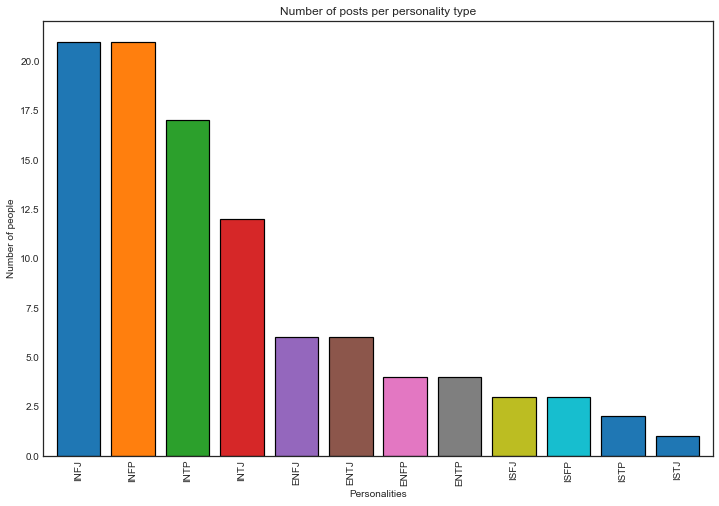

In [15]:
f, ax = plt.subplots(figsize=(12, 8))
count_person['posts'].plot(kind='bar', edgecolor='black',
                           linewidth=1.2, width=0.8)
ax.set_xlabel('Personalities')
ax.set_ylabel('Number of people')
ax.set_title('Number of posts per personality type');


In [16]:
def count_person(df, type, one, two):
    """Count the number of individuals with each of the type personality
    type at each of the four axes

    Parameters:
    -----------
    df -- Input datafram containing posts and personality types
    type -- The personality axis to be assessed
    one -- The first personality in this axis
    two -- The second personality in this axis

    """
    one_count = 0
    two_count = 0
    for i in df[type]:
        if i == one:
            one_count += 1
        else:
            two_count += 1

    return one_count, two_count


In [17]:
i_count, e_count = count_person(all_viz, 'mind', 'I', 'E')
n_count, s_count = count_person(all_viz, 'energy', 'N', 'S')
f_count, t_count = count_person(all_viz, 'nature', 'F', 'T')
j_count, p_count = count_person(all_viz, 'tactics', 'J', 'P')

personality_axes = ['mind', 'energy', 'nature', 'tactics',
                    'mind_l', 'energy_l', 'nature_l', 'tactics_l']

count_axes = pd.DataFrame([[i_count, e_count], [n_count, s_count],
                           [f_count, t_count], [j_count, p_count],
                           ['I', 'E'], ['N', 'S'],
                           ['F', 'T'], ['J', 'P']],
                          index=personality_axes)
count_axes = count_axes.T
count_axes


,mind,energy,nature,tactics,mind_l,energy_l,nature_l,tactics_l
0,80,91,58,49,I,N,F,J
1,20,9,42,51,E,S,T,P


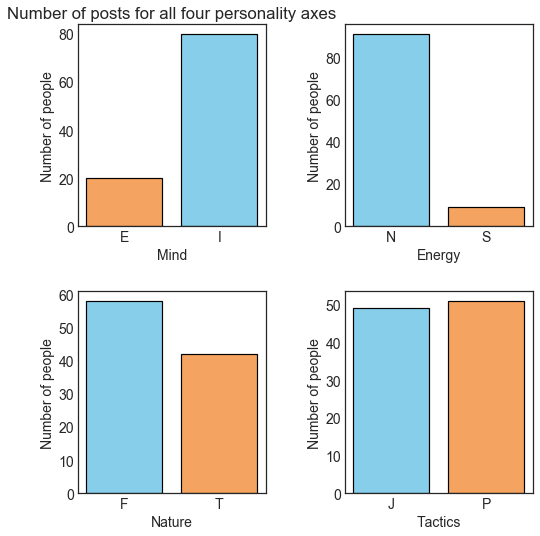

In [18]:
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)
plt.tight_layout(pad=3)
cols = ['skyblue', 'sandybrown']

ax[0, 0].bar(count_axes['mind_l'], count_axes['mind'],
            edgecolor='black', linewidth=1.2, width=0.8, color=cols)
ax[0, 0].set_xlabel('Mind')
ax[0, 0].set_ylabel('Number of people')
ax[0, 0].set_title('Number of posts for all four personality axes')

ax[0, 1].bar(count_axes['energy_l'], count_axes['energy'],
            edgecolor='black', linewidth=1.2, width=0.8, color=cols)
ax[0, 1].set_xlabel('Energy')
ax[0, 1].set_ylabel('Number of people')

ax[1, 0].bar(count_axes['nature_l'], count_axes['nature'],
            edgecolor='black', linewidth=1.2, width=0.8, color=cols)
ax[1, 0].set_xlabel('Nature')
ax[1, 0].set_ylabel('Number of people')

ax[1, 1].bar(count_axes['tactics_l'], count_axes['tactics'],
            edgecolor='black', linewidth=1.2, width=0.8, color=cols)
ax[1, 1].set_xlabel('Tactics')
ax[1, 1].set_ylabel('Number of people');

In [19]:
twt_tkn = TweetTokenizer()
all_viz['tkn_s'] = all_viz.apply(lambda row: twt_tkn.tokenize(row['posts']),
                                 axis=1)
all_viz['lenght_words'] = all_viz['tkn_s'].apply(len)


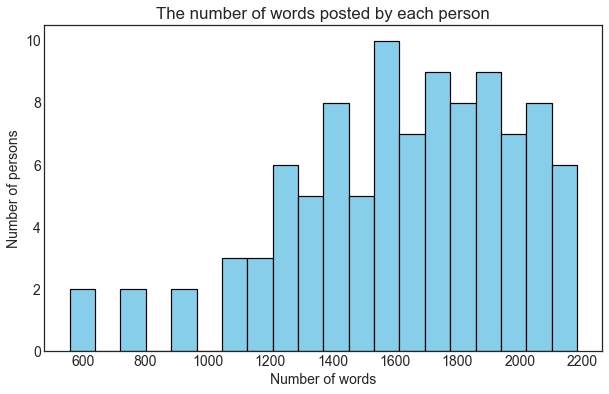

In [20]:
f, ax = plt.subplots(figsize=(10, 6))
all_viz['lenght_words'].hist(bins=20, edgecolor='black',
                             linewidth=1.2, grid=False,
                             color='skyblue')
ax.set_xlabel('Number of words')
ax.set_ylabel('Number of persons')
ax.set_title('The number of words posted by each person');


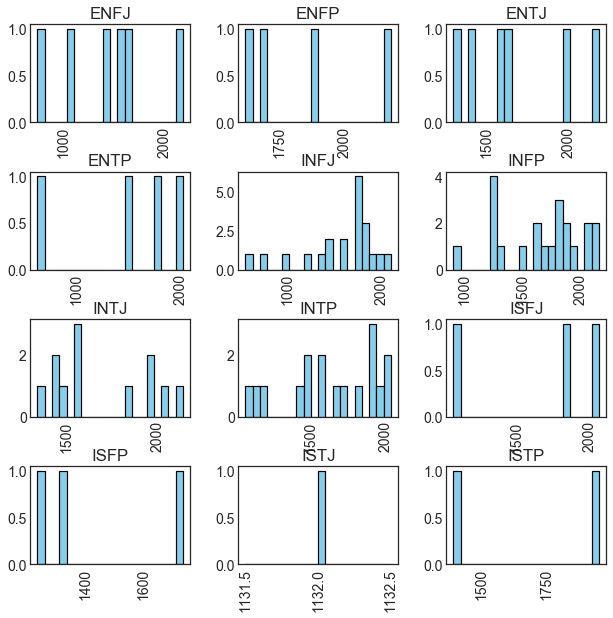

In [21]:
all_viz[['lenght_words', 'type']].hist(bins=20, by='type',
                                       edgecolor='black',
                                       linewidth=1.2,
                                       grid=False,
                                       color='skyblue',
                                       figsize=(10, 10));


# Natural Language Processing 

In [22]:
all_personalities.columns = ['personality', 'post']

all_personalities.head()


,personality,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


Add labels to df which has all the samples and create seperate, subsampled, df's for each of the personality axes

In [23]:
def add_indi_labels(X):
    """Add individual labels for all four personality axes.

    Parameters:
    -----------
    X -- Dataframe containing a column 'type' which contains the Meyers
    Briggs's Type Indicator parsonality in the format 'INFJ'

    Returns:
    -----------
    full_df -- A dataframe which now includes four additional columns for each
    personality axis. These columns are encoded in 0's and 1's, corresponding
    to the labels of the new columns, with 1 indicating that the sample has
    said label and 0 indicating the complement personalit at that asix.
    """

    full_df = X
    full_df['I'] = full_df['type'].apply(lambda x: x[0] == 'I').astype('int')
    full_df['N'] = full_df['type'].apply(lambda x: x[1] == 'N').astype('int')
    full_df['F'] = full_df['type'].apply(lambda x: x[2] == 'F').astype('int')
    full_df['J'] = full_df['type'].apply(lambda x: x[3] == 'J').astype('int')

    return full_df


def subsample(X, pers_axis):
    """Create individual dataframes for each personlaity axis, and subsample
    to the personality which is the lowest in that axis.

    Parameters:
    -----------
    X -- Dataframe containing a column 'personality' which contains the Meyers
    Briggs's Type Indicator parsonality in the format 'INFJ'
    pers_axis -- String with the personality axis of which the the new
    dataframe should be made, options are 'mind', 'energy', 'nature', 'tactics'

    Returns:
    -----------
    subsampled_df -- A Dataframe specific to a personality axis, which contains
    only the posts per individual and a column corresponding to the personality
    axis specified in pers_axis. The labels in the personality axis have been
    binerized, where 1's indicate identity with label and 0's indicate the
    other personality.
    """

    f_df = X.copy()
    f_df['mind'] = [word[0] for word in f_df.loc[:, 'personality']]
    f_df['energy'] = [word[1] for word in f_df.loc[:, 'personality']]
    f_df['nature'] = [word[2] for word in f_df.loc[:, 'personality']]
    f_df['tactics'] = [word[3] for word in f_df.loc[:, 'personality']]

    min_c = f_df.groupby(pers_axis).count().min()
    max_t = f_df.groupby(pers_axis).count().idxmax()
    min_t = f_df.groupby(pers_axis).count().idxmin()

    max_df = f_df[f_df.loc[:, pers_axis] == max_t[0]].sample(int(min_c[0]))
    min_df = f_df[f_df.loc[:, pers_axis] == min_t[0]]
    new_df = pd.concat([max_df, min_df]).sample(frac=1)

    X = new_df.loc[:, 'post']
    y = new_df.loc[:, pers_axis]

    labels = label_binarize(y, classes=[str(min_t[0]), str(max_t[0])])
    code_lbs = np.ravel(labels)
    X_df = pd.DataFrame(X).reset_index(drop=True)
    subsampled_df = X_df.join(pd.DataFrame(code_lbs, columns=[max_t[0]]))
    return subsampled_df


Define functions that allows objects to be saved from python and be reloaded

In [24]:
def save_obj(obj, name):
    """Using pickle, save objects from python.

    Save obj as a pk1 file in the ./obj/ directory within the current
    directory. Create the obj directory before using this function.

    Parameters:
    -----------
    obj -- Object to be saved.
    name -- Name which object is to be saved as.
    """

    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    """Using pickle, load objects to python.

    Load obj from a pk1 file in the ./obj/ directory within the current
    directory.This function specifically loads object created using the
    save_obj function.

    Parameters:
    -----------
    name -- Name of object to be loaded, without its extention.

    Returns:
    -----------
    Python object previously 'pickled'.
    """

    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [25]:
df_mind = subsample(all_personalities, 'mind')
df_nature = subsample(all_personalities, 'nature')
df_energy = subsample(all_personalities, 'energy')
df_tactics = subsample(all_personalities, 'tactics')

train_labeled = []
train_labeled = add_indi_labels(train)

df_mind.head()


,post,I
0,https://www.youtube.com/watch?v=AwgF14ySLpw I...,0
1,'You're fired.|||That's another silly misconce...,0
2,"'No offense to any ESTJs that may read this, b...",1
3,'This. Also flashbacks to times you've been c...,1
4,'I believed in God all my life up until about ...,0


---

### Define functions that will preprocess the data, make lists of stopwords and tokenize sentences or posts

Below are functions to preprocess the twitter posts, make a list of stopwords to be removed, and a custom tokenizer which specifically tokenize tweets, lemmatize words and remove urls to replace them with the domains (e.g., www.youtube.com)

These function are not directly implemented, but are rather called within the vectorize step performed later.

In [26]:
def preprocess(stringss):
    """Preprocess text for Natural Language Processing.

    This function preprocesses text data for Natural Language processing
    by removing punctuation, except emotive punctuation ('!', '?').

    Parameters:
    -----------
    stringss -- Input string which is to be processed.

    Returns:
    -----------
    String of which the punctuation has been removed.
    """

    import string
    keep_punc = ['?', '!']
    punctuation = [str(i) for i in string.punctuation]
    punctuation = [punc for punc in punctuation if punc not in keep_punc]
    s = ''.join([punc for punc in stringss if punc not in punctuation])
    return s


def make_stopwords(other_stopwords, remove_from):
    """Make a list of stopwords to be removed during Natural Language Processing.

    Function which creates a list of words commonly used in the English
    language, which can be supplemented with more specified (other_stopwords)
    words, or from which specified words (remove_from) are removed.

    Parameters:
    -----------
    other_stopwords -- Additional stopwords to be included in the list of
    stopwords.
    remove_from -- Words to be excluded from the list of stopwords

    Returns:
    -----------
    stopwords_punc_personality -- A list of stopwords.
    """

    from nltk.corpus import stopwords
    stopw_all = stopwords.words('english')
    stopwords_punc = [word for word in stopw_all if word not in remove_from]
    stopwords_punc_personality = other_stopwords + stopwords_punc
    return stopwords_punc_personality


Create three lists of stopwords to be assessed for their influence on the ability to classify personalities:

* List 1: Contains words commonly used in the english language, all 16 personality types.

* List 2: Contains words commonly used in the english language, except personal and possessive pronouns.

* List 3: Contains all 16 personality types and words commonly used in the english language, except personal and possessive pronouns.

In [27]:
personalities = ['infj', 'intj', 'isfj', 'istj',
                 'infp', 'intp', 'isfp', 'istp',
                 'enfj', 'entj', 'esfj', 'estj',
                 'enfp', 'entp', 'esfp', 'estp', '...']
empty_list = []
stopwords_all = make_stopwords(personalities, empty_list)

stops = ['...']
words_to_keep = stopwords_all[0:52]
stopwords_no_pro = make_stopwords(stops, words_to_keep)

stopwords_pers_no_pro = make_stopwords(personalities, words_to_keep)


In [28]:
def tokenize(string, token=TweetTokenizer(), lemma=WordNetLemmatizer()):
    """Tokenize sentences into words.

    Create word tokens from strings. This function uses the TweetTokwnizer by
    default to tokenize words from sentences, as well as lemmatizing the words
    and changing full url's to their domains (e.g., change
    https://www.youtube.com/watch?v=TjJUqWXK68Y will return www.youtube.com).

    Parameters:
    -----------
    string -- Input string which is to be processed.
    tokenzier -- Tokenizer to be used in creating tokens,
                 default=TweetTokenizer()
    lemmatizer -- Lemmatizer to be used in lemmatization
                  default=WordNetLemmatizer()

    Returns:
    -----------
    Returns a string of words which have been tokenized, lemmatized and urls
    which has been removed.
    """

    token = TweetTokenizer()
    lemma = WordNetLemmatizer()

    tokens = token.tokenize(string)
    toks = []
    for i in tokens:
        lemmas = lemma.lemmatize(i)
        toks.append(lemmas)

    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    websites = []
    for i in toks:
        websites.append(re.findall(pattern_url, i))
    websites2 = [x for x in websites if x]
    websites3 = []
    for i in websites2:
        if str(i).split('/')[2] not in websites3:
            websites3.append(str(i).split('/')[2])

    for idx, i in enumerate(toks):
        for a in websites3:
            if str(a) in i:
                toks[idx] = a

    df = ' '.join(toks)

    return df


  

## Custom text extraction using pipelines

To truely and accurately perform Natural Language Processing, features other than just word frequencies have to be considered. Other features such as post length, number of words used per post, the readability of the post and sentence length can also provide additional features which can be used classify personalities. 

Below, classes are written to determine:
* Post length
* Average words length
* Average sentence length
* Number of syllables per sentence
* Readability
* Number of words per post
* Number of sentences per post

Additional classes are also written (TextExtractor, CreateListOfLists) to allow for the integration with the SKLearn FeatureUnion, Pipeline and GridSearch. 

In [29]:
class LengthVectorizer(BaseEstimator, TransformerMixin):
    """Determing the length of a post.

    This class determines the length of posts for natural lauguage processing
    and usage in the SciKit-Learn Pipeline.
    """
    length_sum = np.vectorize(len)

    def transform(self, X):
        """Determing lenght of input string.

        Parameters:
        -----------
        X -- String of which the length has to be determined

        Returns:
        -----------
        int -- length of input string

        """
        return self.length_sum(X).astype(float)

    def fit(self, *_):
        return self


class TextExtractor(BaseEstimator, TransformerMixin):
    """Determing the length of a post.

    This class extracts text from an object in python by converting the input
    object to a string
    """

    def __init__(self):
        return None

    def transform(self, X):
        """Extract text.

        Parameters:
        -----------
        X -- Object which has to be converted to string/text

        Returns:
        -----------
        int -- String of text

        """
        return np.asarray(X).astype(str)

    def fit(self, *_):
        return self


class WordLenTransformer(BaseEstimator, TransformerMixin):
    """Determine the average length of words in a string.

    This class determines the length of words for natural lauguage processing
    and usage in the SciKit-Learn Pipeline.

    """

    def __init__(self):
        return None

    def fit(self, *_):
        return self

    def transform(self, words):
        """Apply letter_per_word to dataframe.

        Performs list comprehension to get the average length of words in a
        string for a whole dataframe.

        Parameters:
        -----------
        words -- Dataframe containing strings of words of which the length has
        to be determined

        Returns:
        -----------
        int -- Average length of words in string

        """
        from textstat.textstat import textstat

        def letter_per_word(words):
            """Determing length of input word.

            Parameters:
            -----------
            words -- String of words of which the length has to be determined

            Returns:
            -----------
            int -- Average length of words in string

            """
            return textstat.avg_letter_per_word(words)

        return np.asarray([letter_per_word(word) for word in words])


class SentLenTransformer(BaseEstimator, TransformerMixin):
    """Determing the length of a sentence.

    This class determines the length of posts for natural lauguage processing
    and usage in the SciKit-Learn Pipeline.

    """
    from textstat.textstat import textstat

    def __init__(self):
        return None

    def fit(self, *_):
        return self

    def transform(self, words):
        """Apply sentence_len to dataframe.

        Performs list comprehension to get the average length of sentences in a
        string for a whole dataframe.

        Parameters:
        -----------
        words -- Dataframe containing strings of sentences of which the length
        has to be determined

        Returns:
        -----------
        int -- Average length of sentences in string

        """
        def sentence_len(words):
            """Determing length of input sentence.

            Parameters:
            -----------
            words -- String of sentences of which the length has to be
            determined

            Returns:
            -----------
            int -- Average length of words in string

            """
            return textstat.avg_sentence_length(words)

        return np.asarray([sentence_len(word) for word in words])


class SyllableTransformer(BaseEstimator, TransformerMixin):
    """Determing the number of syllables per word in a string.

    This class determines the number of syllables per word in a string for
    natural lauguage processing and usage in the SciKit-Learn Pipeline.

    """
    from textstat.textstat import textstat

    def __init__(self):
        return None

    def fit(self, *_):
        return self

    def transform(self, words):
        """Apply syllable_len to dataframe.

        Performs list comprehension to get the average number of syllables in
        a string for a whole dataframe.

        Parameters:
        -----------
        words -- Dataframe containing strings of sentences of which the
        syllable count has to be determined

        Returns:
        -----------
        int -- Average number if syllables per word in string

        """
        def syllable_len(words):
            """Determing number of syllables per input word.

            Parameters:
            -----------
            words -- String of words of which the syllable number has to
            be determined

            Returns:
            -----------
            int -- Average length of words in string

            """
            return textstat.avg_syllables_per_word(words)

        return np.asarray([syllable_len(word) for word in words])


class ReadabilityTransformer(BaseEstimator, TransformerMixin):
    """Determing the readability of a string.

    This class determines the readability of strings for natural lauguage
    processing and usage in the SciKit-Learn Pipeline.

    """
    from textstat.textstat import textstat

    def __init__(self):
        return None

    def fit(self, *_):
        return self

    def transform(self, words):
        """Apply reading_qual to dataframe.

        Performs list comprehension to get the readability of words in
        a string for a whole dataframe.

        Parameters:
        -----------
        words -- Dataframe containing strings of sentences of which the
        readability has to be determined

        Returns:
        -----------
        int -- Readability of a dataframe of strings.

        """
        def reading_qual(words):
            """Determing readability of input strings.

            Parameters:
            -----------
            words -- String of words of which the readability has to
            be determined

            Returns:
            -----------
            int -- Flesch readability index

            """
            return textstat.flesch_reading_ease(words)

        return np.asarray([reading_qual(word) for word in words])


class SentCountTransformer(BaseEstimator, TransformerMixin):
    """Determing the number of sentences in a string.

    This class determines the number of sentences in strings posts for
    natural lauguage processing and usage in the SciKit-Learn Pipeline.

    """
    from textstat.textstat import textstat

    def __init__(self):
        return None

    def fit(self, *_):
        return self

    def transform(self, words):
        """Apply sentence_count to dataframe.

        Performs list comprehension to get the number of sentences in
        a string for a whole dataframe.

        Parameters:
        -----------
        words -- Dataframe containing strings of sentences of which the
        number of sentences has to be determined

        Returns:
        -----------
        int -- Number of sentences of a dataframe of strings.

        """
        def sentence_count(words):
            """Determing number of sentences in input strings.

            Parameters:
            -----------
            words -- String of words of which the number of sentences has to
            be determined

            Returns:
            -----------
            int -- Number of sentences in a string

            """
            return float(textstat.sentence_count(words))

        return np.asarray([sentence_count(word) for word in words])


class WordCountTransformer(BaseEstimator, TransformerMixin):
    """Determing the number of words in a string.

    This class determines the number of words in a string for
    natural lauguage processing and usage in the SciKit-Learn Pipeline.

    """
    from textstat.textstat import textstat

    def __init__(self, state=True):
        return None

    def fit(self, *_):
        return self

    def transform(self, words):
        """Apply word_count to dataframe.

        Performs list comprehension to get the number of words in
        a string for a whole dataframe.

        Parameters:
        -----------
        words -- Dataframe containing strings of sentences of which the
        number of words has to be determined

        Returns:
        -----------
        int -- Number of words of a dataframe of strings.

        """
        def word_count(words):
            """Determing number of words in input strings.

            Parameters:
            -----------
            words -- String of words of which the number of words has to
            be determined

            Returns:
            -----------
            int -- Number of words in a string

            """
            return float(textstat.lexicon_count(words))

        return np.asarray([word_count(word) for word in words])


class CreateListOfLists(BaseEstimator, TransformerMixin):
    """Determing the length of a post.

    This class determines the length of posts for natural lauguage processing
    and usage in the SciKit-Learn Pipeline.

    """
    def transform(self, X):
        """Convert (i, j) array to a (j, i) array.

        Parameters:
        -----------
        X -- Input array.

        Returns:
        -----------
        int -- Transformed array.

        """
        try:
            return X.reshape((X.shape[0], 1))
        except:
            pass

    def fit(self, *_):
        return self


# Build classification models

Perform test train splits on df's from all four axes, and create a dictionary of these train and test sets, each corresponding to a personality axis, which will be used when performing classification.

In [30]:
X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(df_mind['post'],
                                                  df_mind['I'])
X_tr_e, X_te_e, y_tr_e, y_te_e = train_test_split(df_energy['post'],
                                                  df_energy['N'])
X_tr_n, X_te_n, y_tr_n, y_te_n = train_test_split(df_nature['post'],
                                                  df_nature['F'])
X_tr_t, X_te_t, y_tr_t, y_te_t = train_test_split(df_tactics['post'],
                                                  df_tactics['P'])


In [31]:
train_tests = {'mind': [X_tr_m, X_te_m, y_tr_m, y_te_m],
                'energy': [X_tr_e, X_te_e, y_tr_e, y_te_e],
                'nature': [X_tr_n, X_te_n, y_tr_n, y_te_n],
                'tactics': [X_tr_t, X_te_t, y_tr_t, y_te_t]}


### Set up pipelines

To perform classification, SKLearn Pipelines were used. In brief, these pipelines allow for full modularization of ML code. This means that within a pipeline preprocessing, vectorization and classification is performed. This allows that raw data can be input into a pipeline, and a fit model will be produced against which predictions can be done. 

Below several pipelines are defined to create the additional features, this includes extracting the text from the strings, performing the specific class transformer defined above, followed by scaling of the data. 

Lastly the additional features are joined together into a single feature vector using FeatureUnion, build into SKLearn.

In [32]:
post_len_featurizer = Pipeline([
  ('desc_extractor',  TextExtractor()),
  ('len_vectorizer',  LengthVectorizer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

word_len_featurizer = Pipeline([
  ('len_vectorizer',  WordLenTransformer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

sent_len_featurizer = Pipeline([
  ('len_vectorizer',  SentLenTransformer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

syllable_featurizer = Pipeline([
  ('len_vectorizer',  SyllableTransformer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

sent_count_featurizer = Pipeline([
  ('len_vectorizer',  SentCountTransformer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

word_count_featurizer = Pipeline([
  ('len_vectorizer',  WordCountTransformer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

readable_featurizer = Pipeline([
  ('len_vectorizer',  ReadabilityTransformer()),
  ('updim_array',     CreateListOfLists()),
  ('scaling', StandardScaler())
])

add_features = FeatureUnion([
        ('post_len', post_len_featurizer),
        ('word_len', word_len_featurizer),
        ('sent_len', sent_len_featurizer),
        ('syllable', syllable_featurizer),
        ('sent_count', sent_count_featurizer),
        ('word_count', word_count_featurizer),
        ('readable', readable_featurizer)
    ])


Below an instance is initialized of the TfidfVectorizer with the custom preprocessor, stopwords and tokenizer. 

This vectorizer is then merged with the additional features transformer. This will result in a feature vector including both the additional features and word vector.

Lastly, this is combined in a very simple pipeline with a Logistic Regression Classifier to provide a baseline classifier. 

In [33]:
vectorizer = TfidfVectorizer(preprocessor=preprocess,
                             stop_words=stopwords_no_pro,
                             tokenizer=tokenize)

features = FeatureUnion([
    ('vectorize', vectorizer),
    ('add_features', add_features)
])

pipeline = Pipeline([
    ('features', vectorizer),
    ('classify', LogisticRegression())
])


### Run pipelines

Below the basic pipeline is run for each of the four personality axes (the reason we have a trains_tests dictionary), and several performance metrics are predicted off the fit model, which is stored in a dictionary, which is subsequently stored in disk. 

In [21]:
scores = {}
for k, i in train_tests.items():
    pipeline.fit(i[0], i[2])
    scores[str(k) + '_score'] = pipeline.score(i[0], i[2])
    predict = pipeline.predict(i[1])
    predict_train = pipeline.predict(i[0])
    scores[str(k) + '_confusion'] = metrics.confusion_matrix(i[3], predict)
    scores[str(k) + '_accuracy_train'] = metrics.accuracy_score(i[2],
                                                                predict_train)
    scores[str(k) + '_accuracy_test'] = metrics.accuracy_score(i[3],
                                                               predict)
    scores[str(k) + '_prec_test'] = metrics.precision_score(i[3],
                                                            predict,
                                                            average='weighted')
    scores[str(k) + '_recall_test'] = metrics.recall_score(i[3],
                                                           predict,
                                                           average='weighted')
    scores[str(k) + '_f1_train'] = metrics.f1_score(i[2],
                                                    predict_train,
                                                    average='weighted')
    scores[str(k) + '_f1_test'] = metrics.f1_score(i[3],
                                                   predict,
                                                   average='weighted')


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
save_obj(scores, 'basic_scores')


In [471]:
basic_scores = load_obj('basic_scores')


In [472]:
accuracy = pd.DataFrame([basic_scores['mind_accuracy_test'],
                         basic_scores['energy_accuracy_test'],
                         basic_scores['nature_accuracy_test'],
                         basic_scores['tactics_accuracy_test']],
                        columns=['accuracy'])
axes = pd.DataFrame(['Mind', 'Energy', 'Nature', 'Tactics'],
                    columns=['type'])
accuracy_b = accuracy.join(axes)

f1 = pd.DataFrame([basic_scores['mind_f1_test'],
                   basic_scores['energy_f1_test'],
                   basic_scores['nature_f1_test'],
                   basic_scores['tactics_f1_test']],
                  columns=['accuracy'])
axes = pd.DataFrame(['Mind', 'Energy', 'Nature', 'Tactics'],
                    columns=['type'])
f1_b = f1.join(axes)


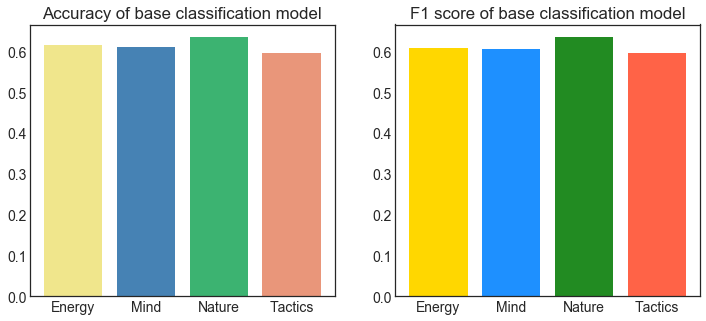

In [473]:
f, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)

ax[0].bar(accuracy_b['type'], accuracy_b['accuracy'],
          color=['steelblue', 'khaki', 'mediumseagreen', 'darksalmon'])
ax[0].set_title('Accuracy of base classification model')
ax[1].bar(f1_b['type'], f1_b['accuracy'],
          color=['dodgerblue', 'gold', 'forestgreen', 'tomato'])
ax[1].set_title('F1 score of base classification model');


# Model selection, validation and evaluation through gridsearches

Because we are going to build numerous models, we will define a function which applies the model to be build to all four personality axes. We will used this function to perform grid searches on each of the personality axes with a set number of parameters.

In [ ]:
def grid_search_p_model(grid, trains_tests):
    """Perform a gridsearch on multiple binary axes.

    This function performs multiple gridsearches on each axis specified in
    the train_tests sets. For each of the axes a gridsearch will be performed
    on the grid instance specified. Following the gridsearch, the models
    are assessed for the parameters, best score, accuracy, recall, precision
    and the f1 score. This all is output into a dictionary, with a key
    specifying the metric and for which model.

    Parameters:
    -----------
    grid -- GridSearchCV instance created with specific parameters to be
    searched
    trains_tests -- dictionary of which the keys are an axes for binary
    classification, and the values are test train splits along that axis.

    Returns:
    -----------
    Dictionary object where keys indicate the axis along with various metrics.
    The metrics assessed are:
        -> Model with best parameters
        -> Accuracy score of the best model
        -> The cross validation results
        -> The train accuracy score
        -> The confusion matrix
        -> Test accuracy score
        -> Precision
        -> Recall
        -> F1 Test score
        -> F1 Train score

    """
    s = {}
    for k, i in trains_tests.items():
        grid.fit(i[0], i[2])
        s[str(k) + '_best_params'] = grid.best_params_
        s[str(k) + '_best_score'] = grid.best_score_
        s[str(k) + '_grid_results'] = grid.cv_results_
        s[str(k) + '_score'] = grid.score(i[0], i[2])
        predict = grid.predict(i[1])
        predict_train = grid.predict(i[0])
        s[str(k) + '_confusion'] = metrics.confusion_matrix(i[3],
                                                            predict)
        s[str(k) + '_accuracy_train'] = metrics.accuracy_score(i[2],
                                                               predict_train)
        s[str(k) + '_accuracy_test'] = metrics.accuracy_score(i[3],
                                                              predict)
        s[str(k) + '_prc_test'] = metrics.precision_score(i[3],
                                                          predict,
                                                          average='weighted')
        s[str(k) + '_recall_test'] = metrics.recall_score(i[3],
                                                          predict,
                                                          average='weighted')
        s[str(k) + '_f1_train'] = metrics.f1_score(i[2],
                                                   predict_train,
                                                   average='weighted')
        s[str(k) + '_f1_test'] = metrics.f1_score(i[3],
                                                  predict,
                                                  average='weighted')
    return s


### Does my own NLP and additional features actually increase the performance of my model?

#### We first check if removing the stopwords has an influence, tokenization using a custom tokenizer and preprocessing the data

Below we perform grid searched, which takes in lists of parameters for which each permutation of those parameters will be used to assess the performance of the classifier. The output of a gridseach is a dictionary which provide test and train metrics for all the models tested. Additionally, the resulting grid object is fit with the best model and can further be used to make predictions as in all sklearn classifiers. 

The aim of this gridsearch is thus to assess whether custom preprocessing, tokenization and removing stopwords have an influence on classification.

In [23]:
param_grid = {'features__stop_words': [stopwords_all,
                                       stopwords_no_pro,
                                       stopwords_pers_no_pro,
                                       None],
              'features__tokenizer': [tokenize, None],
              'features__preprocessor': [preprocess, None]}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [24]:
scr_tkn = grid_search_p_model(grid, train_tests)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',

[Parallel(n_jobs=-1)]: Done  14 out of  48 | elapsed:   17.1s remaining:   41.4s


[CV]  features__preprocessor=None, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn'

[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:   40.4s remaining:   31.4s


[CV]  features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', 

[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed:   49.4s remaining:    9.9s


[CV]  features__preprocessor=None, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn'

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   54.8s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',

[Parallel(n_jobs=-1)]: Done  14 out of  48 | elapsed:   10.0s remaining:   24.3s


[CV]  features__preprocessor=None, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn'

[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:   23.4s remaining:   18.2s


[CV]  features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "sho

[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed:   28.8s remaining:    5.8s


[CV]  features__preprocessor=None, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn'

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   32.4s finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',

[Parallel(n_jobs=-1)]: Done  14 out of  48 | elapsed:   32.9s remaining:  1.3min


[CV] features__preprocessor=None, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o',

[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:  1.3min remaining:  1.0min


[CV]  features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=None, features__tokenizer=<function tokenize at 0x2aaaee18aea0>, accuracy=0.572289156626506, precision=0.5683060109289617, recall=0.6227544910179641, roc_auc=0.6194520050807476, f1=0.5942857142857143, total=  34.3s
[CV]  features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=None, features__tokenizer=<function tokenize at 0x2aaaee18aea0>, accuracy=0.6295180722891566, precision=0.6009174311926605, recall=0.7844311377245509, roc_auc=0.6659408455815642, f1=0.6805194805194804, total=  34.5s
[CV]  features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', '

[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed:  1.6min remaining:   19.4s


[CV]  features__preprocessor=None, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn'

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',

[Parallel(n_jobs=-1)]: Done  14 out of  48 | elapsed:   28.2s remaining:  1.1min


[CV]  features__preprocessor=None, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', '

[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:  1.1min remaining:   52.2s


[CV]  features__preprocessor=<function preprocess at 0x2aaaee133840>, features__stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "sho

[Parallel(n_jobs=-1)]: Done  40 out of  48 | elapsed:  1.4min remaining:   16.4s


[CV]  features__preprocessor=None, features__stop_words=['...', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn'

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.5min finished


In [129]:
save_obj(scr_tkn, 'scores_token_stops')

In [467]:
scr_tkn = load_obj('scores_token_stops')

This is an example of the features selected by the model, the preprocess function, stopwords_all as stopwords and no tokeniation function.

In [468]:
scr_tkn['mind_best_params']

{'features__preprocessor': <function __main__.preprocess>,
 'features__stop_words': ['infj',
  'intj',
  'isfj',
  'istj',
  'infp',
  'intp',
  'isfp',
  'istp',
  'enfj',
  'entj',
  'esfj',
  'estj',
  'enfp',
  'entp',
  'esfp',
  'estp',
  '...',
  'i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'f

Here, overall the model that performed best did not make use of the custor vectorizer, but included the custor preprocessor, and the removal of stopwords (The 1st list of stopwords).

### How are we going to change the vectorizer to increase the performance of the model

The aim of this gridsearch is to find hyperparameters for which the vectorizer performs best.

In [26]:
pipeline = Pipeline([
    ('features', TfidfVectorizer(preprocessor=preprocess,
                                 stop_words=stopwords_all)),
    ('classify', LogisticRegression())
])

param_grid = {'features__min_df': [0.0, 0.1, 0.2, 0.3, 0.4],
              'features__max_features': [1000, 5000, 7500,
                                         10000, 50000, 100000],
              'features__ngram_range': [(1, 1), (1, 2), (1, 3)]}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline, param_grid, refit='accuracy',
                    verbose=4, n_jobs=-1,
                    scoring=scoring, return_train_score=True)


In [27]:
scr_vec = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   37.3s


[CV]  features__max_features=5000, features__min_df=0.1, features__ngram_range=(1, 1), accuracy=0.6411764705882353, precision=0.6395348837209303, recall=0.6470588235294118, roc_auc=0.7024221453287197, f1=0.6432748538011696, total=   4.8s
[CV]  features__max_features=5000, features__min_df=0.0, features__ngram_range=(1, 2), accuracy=0.7058823529411765, precision=0.6804123711340206, recall=0.7764705882352941, roc_auc=0.7500346020761246, f1=0.7252747252747253, total=   6.5s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000, features__min_df=0.0, features__ngram_range=(1, 2), accuracy=0.6470588235294118, precision=0.6436781609195402, recall=0.6588235294117647, roc_auc=0.7273356401384082, f1=0.6511627906976745, total=   6.3s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.8min


[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.6470588235294118, precision=0.6262626262626263, recall=0.7294117647058823, roc_auc=0.6729411764705882, f1=0.6739130434782609, total=   8.3s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.6783625730994152, precision=0.6741573033707865, recall=0.6976744186046512, roc_auc=0.6853625170998632, f1=0.6857142857142857, total=   8.3s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.6294117647058823, precision=0.6122448979591837, recall=0.7058823529411765, roc_auc=0.686643598615917, f1=0.6557377049180328, total=   8.0s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_fea

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.8min finished


Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   21.9s


[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000, features__min_df=0.2, features__ngram_range=(1, 1), accuracy=0.74, precision=0.7142857142857143, recall=0.8490566037735849, roc_auc=0.8253713368125251, f1=0.7758620689655172, total=   2.7s
[CV]  features__max_features=5000, features__min_df=0.2, features__ngram_range=(1, 1), accuracy=0.73, precision=0.6805555555555556, recall=0.9245283018867925, roc_auc=0.8057005218787635, f1=0.784, total=   2.8s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 3) 
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 3) 
[CV]  features__max_features=5000, features__min_df=0.2, features__ngram_range=(1, 1), accuracy=0.68, precision=0.6567164179104478, recall=0.8301886792452831, roc_auc=0.779205138498595, f1=0.7333333333333334, total=   2.8s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 3)

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.1min


[CV]  features__max_features=10000, features__min_df=0.4, features__ngram_range=(1, 2), accuracy=0.6, precision=0.6065573770491803, recall=0.6981132075471698, roc_auc=0.672019269369731, f1=0.6491228070175438, total=   3.9s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=10000, features__min_df=0.4, features__ngram_range=(1, 2), accuracy=0.55, precision=0.5625, recall=0.6792452830188679, roc_auc=0.6467282215977519, f1=0.6153846153846154, total=   3.7s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=10000, features__min_df=0.4, features__ngram_range=(1, 2), accuracy=0.57, precision=0.5714285714285714, recall=0.7547169811320755, roc_auc=0.6415094339622641, f1=0.6504065040650406, total=   4.1s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=50000, features__min_df=0.0, features__ngram_rang

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.6min finished


Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.2min


[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000, features__min_df=0.0, features__ngram_range=(1, 2), accuracy=0.8090909090909091, precision=0.7976878612716763, recall=0.8313253012048193, roc_auc=0.8779385836027035, f1=0.8141592920353983, total=  12.5s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000, features__min_df=0.0, features__ngram_range=(1, 2), accuracy=0.8253012048192772, precision=0.8303030303030303, recall=0.8203592814371258, roc_auc=0.8835420068953004, f1=0.8253012048192772, total=  12.5s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000, features__min_df=0.2, features__ngram_range=(1, 1), accuracy=0.8042168674698795, precision=0.8227848101265823, recall=0.7784431137724551, roc_auc=0.8822355289421158, f1=0.8, total=   9.3s
[CV] features__max_features=5000, features_

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.5min


[CV]  features__max_features=10000, features__min_df=0.4, features__ngram_range=(1, 2), accuracy=0.7121212121212122, precision=0.7052023121387283, recall=0.7349397590361446, roc_auc=0.7906993828974433, f1=0.7197640117994101, total=  13.3s
[CV] features__max_features=50000, features__min_df=0.1, features__ngram_range=(1, 3) 
[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.7710843373493976, precision=0.7724550898203593, recall=0.7724550898203593, roc_auc=0.8538922155688622, f1=0.7724550898203594, total=  16.1s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.7363636363636363, precision=0.7206703910614525, recall=0.7771084337349398, roc_auc=0.8228768733470467, f1=0.7478260869565216, total=  16.0s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_fe

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  5.5min finished


Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 2) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.0, features__ngram_range=(1, 3) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=(1, 1) 
[CV] features__max_features=1000, features__min_df=0.1, features__ngram_range=

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.0min


[CV]  features__max_features=5000, features__min_df=0.0, features__ngram_range=(1, 2), accuracy=0.7147887323943662, precision=0.732824427480916, recall=0.676056338028169, roc_auc=0.7727633406070225, f1=0.7032967032967034, total=  10.5s
[CV]  features__max_features=5000, features__min_df=0.1, features__ngram_range=(1, 1), accuracy=0.7112676056338029, precision=0.717391304347826, recall=0.6971830985915493, roc_auc=0.7865502876413409, f1=0.7071428571428572, total=   8.2s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000, features__min_df=0.1, features__ngram_range=(1, 1), accuracy=0.7067137809187279, precision=0.6883116883116883, recall=0.75177304964539, roc_auc=0.7616621716112276, f1=0.7186440677966103, total=   8.1s
[CV] features__max_features=5000, features__min_df=0.3, features__ngram_range=(1, 2) 
[CV]  features__max_features=5000

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.0min


[CV]  features__max_features=10000, features__min_df=0.4, features__ngram_range=(1, 2), accuracy=0.5759717314487632, precision=0.5714285714285714, recall=0.5957446808510638, roc_auc=0.6241634202377385, f1=0.5833333333333334, total=  11.2s
[CV] features__max_features=50000, features__min_df=0.1, features__ngram_range=(1, 3) 
[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.6537102473498233, precision=0.6369426751592356, recall=0.7092198581560284, roc_auc=0.7141144740785137, f1=0.6711409395973155, total=  14.2s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_features=10000, features__min_df=0.3, features__ngram_range=(1, 3), accuracy=0.6619718309859155, precision=0.6597222222222222, recall=0.6690140845070423, roc_auc=0.718756199166832, f1=0.6643356643356644, total=  14.3s
[CV] features__max_features=50000, features__min_df=0.2, features__ngram_range=(1, 1) 
[CV]  features__max_fea

[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.7min finished


In [28]:
save_obj(scr_vec, 'scores_vector_basics')


In [469]:
scr_vec = load_obj('scores_vector_basics')


In [470]:
print('The mind axis:', scr_vec['mind_best_params'])
print('The energy axis:', scr_vec['energy_best_params'])
print('The nature axis:', scr_vec['nature_best_params'])
print('The tactics axis:', scr_vec['tactics_best_params'])


The mind axis: {'features__max_features': 100000, 'features__min_df': 0.0, 'features__ngram_range': (1, 3)}
The energy axis: {'features__max_features': 5000, 'features__min_df': 0.0, 'features__ngram_range': (1, 2)}
The nature axis: {'features__max_features': 50000, 'features__min_df': 0.0, 'features__ngram_range': (1, 1)}
The tactics axis: {'features__max_features': 10000, 'features__min_df': 0.0, 'features__ngram_range': (1, 3)}


Here, the model that performed best were variable across all axes, with differences in the number of features and n_grams.
When we build a final model, we will assess this again and use the most optimal parameters for each axis. The addition of n_grams to the model greatly increases the memory load, and computational complexity, and will be excluded from the current model.

### Using the parameters selected above, perform a search checking if adding more features to the model (such as readability, number of words, etc.) adds performance to the model

The aim of this girdsearch is to assess whether the additional features added earlier add performance to the classifier.

In [29]:
vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords_all)

param_grid = {'features':[vectorizer, features]}
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [30]:
scr_add = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] features=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function preprocess at 0x2aaaee133840>,
        smooth_idf=True,
        stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None) 
[CV] features=TfidfVectorizer(anal

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   12.0s remaining:   12.0s


[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None))],
       transformer_weights=None), accuracy=0.49122807017543857, precision=0.494949494949495, recall=0.5697674418604651, roc_auc=0.4891928864569084, f1=0.5297297297297298, total= 1.1min
[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.7min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] features=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function preprocess at 0x2aaaee133840>,
        smooth_idf=True,
        stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None) 
[CV] features=TfidfVectorizer(anal

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    7.3s remaining:    7.3s


[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None))],
       transformer_weights=None), accuracy=0.46, precision=0.49333333333333335, recall=0.6981132075471698, roc_auc=0.46688077077478923, f1=0.578125, total=  21.2s
[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler(copy=True, with_mean=

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.3min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] features=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function preprocess at 0x2aaaee133840>,
        smooth_idf=True,
        stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None) 
[CV] features=TfidfVectorizer(anal

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   22.9s remaining:   22.9s


[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None))],
       transformer_weights=None), accuracy=0.5783132530120482, precision=0.5658536585365853, recall=0.6946107784431138, roc_auc=0.6192705498094719, f1=0.6236559139784946, total= 2.3min
[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  5.5min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] features=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function preprocess at 0x2aaaee133840>,
        smooth_idf=True,
        stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None) 
[CV] features=TfidfVectorizer(anal

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   19.7s remaining:   19.7s


[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None))],
       transformer_weights=None), accuracy=0.5724381625441696, precision=0.5704225352112676, recall=0.574468085106383, roc_auc=0.5754669863150534, f1=0.5724381625441696, total= 1.9min
[CV]  features=FeatureUnion(n_jobs=1,
       transformer_list=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<...', StandardScaler(

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.5min finished


In [31]:
save_obj(scr_add, 'scores_add_features')


In [138]:
scr_add = load_obj('scores_add_features')


In [139]:
scr_add['mind_best_params']

{'features': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2',
         preprocessor=<function preprocess at 0x0000023E8DF87A60>,
         smooth_idf=True,
         stop_words=['infj', 'intj', 'isfj', 'istj', 'infp', 'intp', 'isfp', 'istp', 'enfj', 'entj', 'esfj', 'estj', 'enfp', 'entp', 'esfp', 'estp', '...', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
         strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

The above model just makes use of the TfidsVectorizer, and not of the additional features. The same is seen for the other three axes.

Turns out that adding more feautres does not add value to the model, we will not include them for later models.

### Which classifier performs best with base assumptions

Before going into detail with each classifier, we assess which classifier perform best with base assumptions. 
To increase computational performance we reduce the dimentionality of the input dataset using singular value decomposition into 1000 dimnetions, and vectorize using the above identified hyperparameters.

In [32]:
vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords_all)

pipeline_classif = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', LogisticRegression())
])

param_grid = {'classify':[
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=2000)
]}
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_classif, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [33]:
scr_bsc = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           m

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are col

[CV]  classify=GaussianNB(priors=None), accuracy=0.5964912280701754, precision=0.5779816513761468, recall=0.7325581395348837, roc_auc=0.6618331053351574, f1=0.6461538461538462, total= 1.0min
[CV] classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
[CV]  classify=GaussianNB(priors=None), accuracy=0.6529411764705882, precision=0.6120689655172413, recall=0.8352941176470589, roc_auc=0.725674740484429, f1=0.7064676616915423, total= 1.0min
[CV] classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, 

[Parallel(n_jobs=-1)]: Done   4 out of  33 | elapsed:  1.3min remaining:  9.4min


[CV]  classify=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001), accuracy=0.5588235294117647, precision=0.5373134328358209, recall=0.8470588235294118, roc_auc=0.6067820069204152, f1=0.6575342465753425, total= 1.0min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
[CV]  classify=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), accuracy=0.5730994152046783, precision=0.5414012738853503, recall=0.9883720930232558, roc_auc=0.7191518467852258, f1=0.6995884773662552, total= 1.1min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) [CV]  classify=LinearDiscrim

[Parallel(n_jobs=-1)]: Done  13 out of  33 | elapsed:  1.4min remaining:  2.1min


[CV]  classify=SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), accuracy=0.6198830409356725, precision=0.5882352941176471, recall=0.813953488372093, roc_auc=0.7105335157318742, f1=0.6829268292682927, total= 1.1min
[CV]  classify=GaussianNB(priors=None), accuracy=0.5529411764705883, precision=0.5412844036697247, recall=0.6941176470588235, roc_auc=0.5673356401384084, f1=0.6082474226804124, total= 1.1min
[CV]  classify=SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.7305190311418686, f1=0.6666666666666666, total= 1.1min
[CV]  classify=SVC(C=1, cache_size=200, class_weight=None, co

[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:  1.4min remaining:   43.1s


[CV]  classify=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001), accuracy=0.5117647058823529, precision=0.5081967213114754, recall=0.7294117647058823, roc_auc=0.522629757785467, f1=0.5990338164251208, total= 1.1min
[CV]  classify=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), accuracy=0.6235294117647059, precision=0.591304347826087, recall=0.8, roc_auc=0.6674048442906575, f1=0.68, total= 1.1min
[CV]  classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,


[Parallel(n_jobs=-1)]: Done  31 out of  33 | elapsed:  2.1min remaining:    8.3s


[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), accuracy=0.7176470588235294, precision=0.7032967032967034, recall=0.7529411764705882, roc_auc=0.7490657439446367, f1=0.7272727272727272, total=  40.5s
[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1

[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  2.2min finished


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           m

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are col

[CV]  classify=GaussianNB(priors=None), accuracy=0.73, precision=0.782608695652174, recall=0.6792452830188679, roc_auc=0.8386190285026094, f1=0.7272727272727273, total=  36.9s
[CV] classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
[CV]  classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), accuracy=0.64, precision=0.6545454545454545, recall=0.6792452830188679, roc_auc=0.6112003211561621, f1=0.6666666666666666, total=  36.4s
[CV] classify=RandomForestClassifier(bootstrap=True, class_weight=None, criteri

[Parallel(n_jobs=-1)]: Done   4 out of  33 | elapsed:   48.5s remaining:  5.9min


[CV]  classify=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001), accuracy=0.53, precision=0.6666666666666666, recall=0.22641509433962265, roc_auc=0.5616218386190286, f1=0.3380281690140845, total=  39.8s
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
[CV]  classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), accuracy=0.72, precision=0.654320987654321, recall=1.0, roc_auc=0.8711360899237254, f1=0.791044776119403, total=  36.6s
[CV] classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=

[Parallel(n_jobs=-1)]: Done  13 out of  33 | elapsed:   50.8s remaining:  1.3min


[CV]  classify=SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.753512645523886, f1=0.6928104575163399, total=  38.2s
[CV]  classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), accuracy=0.65, precision=0.6046511627906976, recall=0.9811320754716981, roc_auc=0.8221597751906865, f1=0.7482014388489208, total=  38.2s
[CV]  classify=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.6748293857888398, f1=

[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:   55.1s remaining:   27.6s


[CV]  classify=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001), accuracy=0.54, precision=0.5538461538461539, recall=0.6792452830188679, roc_auc=0.5708550782818146, f1=0.6101694915254237, total=  40.4s
[CV]  classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), accuracy=0.56, precision=0.5737704918032787, recall=0.660377358490566, roc_auc=0.5967482938578884, f1=0.6140350877192982, total=  40.1s
[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None), accuracy=0.56, precision=0.68, recall=0.32075471698113206, roc_auc=0.6732236049779206, f1=0.43589743589743585, total=  23.6s
[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_st

[Parallel(n_jobs=-1)]: Done  31 out of  33 | elapsed:  1.3min remaining:    5.2s


[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), accuracy=0.79, precision=0.7758620689655172, recall=0.8490566037735849, roc_auc=0.86029706945002, f1=0.8108108108108107, total=  24.3s
[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose

[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  1.4min finished


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           m

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are col

[CV]  classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), accuracy=0.8132530120481928, precision=0.7837837837837838, recall=0.8682634730538922, roc_auc=0.8971511522409726, f1=0.8238636363636364, total= 2.7min
[CV] classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
[CV]  classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, mul

[Parallel(n_jobs=-1)]: Done   4 out of  33 | elapsed:  3.2min remaining: 23.4min


[CV]  classify=GaussianNB(priors=None), accuracy=0.7650602409638554, precision=0.7354497354497355, recall=0.8323353293413174, roc_auc=0.8315732172019599, f1=0.7808988764044945, total= 2.7min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
[CV]  classify=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001), accuracy=0.6686746987951807, precision=0.6255506607929515, recall=0.8502994011976048, roc_auc=0.7244057339865723, f1=0.7208121827411167, total= 2.7min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
[CV]  classify=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001), accuracy=0.6927710843373494, precision=0.7642276422764228, recall=0.5628

[Parallel(n_jobs=-1)]: Done  13 out of  33 | elapsed:  3.3min remaining:  5.1min


[CV]  classify=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), accuracy=0.7469879518072289, precision=0.7610062893081762, recall=0.7245508982035929, roc_auc=0.7038287062239159, f1=0.7423312883435583, total= 2.7min
[CV]  classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), accuracy=0.6807228915662651, precision=0.6276150627615062, recall=0.8982035928143712, roc_auc=0.7495554345853747, f1=0.7389162561576355, total= 2.7min
[CV]  classify=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001), accura

[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:  3.4min remaining:  1.7min


[CV]  classify=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001), accuracy=0.6121212121212121, precision=0.5879629629629629, recall=0.7650602409638554, roc_auc=0.673266235674405, f1=0.6649214659685863, total= 2.9min
[CV]  classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), accuracy=0.603030303030303, precision=0.5720164609053497, recall=0.8373493975903614, roc_auc=0.6514105201292977, f1=0.6797066014669927, total= 2.7min
[CV]  classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, ran

[Parallel(n_jobs=-1)]: Done  31 out of  33 | elapsed:  5.0min remaining:   19.2s


[CV]  classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None), accuracy=0.7228915662650602, precision=0.8787878787878788, recall=0.5209580838323353, roc_auc=0.832099437488659, f1=0.6541353383458647, total= 1.4min
[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), accuracy=0.8253012048192772, precision=0.8187134502923976, recall=0.8383233532934131, roc_auc=0.8895663219016512, f1=0.8284023668639053, total= 1.5min


[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  5.0min finished


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
[CV] classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           m

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are colli

[CV]  classify=GaussianNB(priors=None), accuracy=0.6690140845070423, precision=0.6558441558441559, recall=0.7112676056338029, roc_auc=0.724608212656219, f1=0.6824324324324325, total= 2.1min
[CV] classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
[CV]  classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), accuracy=0.6901408450704225, precision=0.7076923076923077, recall=0.647887323943662, roc_auc=0.757835

[Parallel(n_jobs=-1)]: Done   4 out of  33 | elapsed:  2.5min remaining: 18.5min


[CV]  classify=GaussianNB(priors=None), accuracy=0.6713780918727915, precision=0.6739130434782609, recall=0.6595744680851063, roc_auc=0.7552192588153032, f1=0.6666666666666667, total= 2.1min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
[CV]  classify=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), accuracy=0.6713780918727915, precision=0.66, recall=0.7021276595744681, roc_auc=0.7533213465188293, f1=0.6804123711340208, total= 2.1min
[CV] classify=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None) 
[CV]  classify=SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', de

[Parallel(n_jobs=-1)]: Done  13 out of  33 | elapsed:  2.6min remaining:  4.0min


[CV]  classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), accuracy=0.607773851590106, precision=0.5882352941176471, recall=0.7092198581560284, roc_auc=0.6226650684247328, f1=0.6430868167202572, total= 2.1min
[CV]  classify=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), accuracy=0.5669014084507042, precision=0.6266666666666667, recall=0.33098591549295775, roc_auc=0.5952192025391787, f1=0.43317972350230416, total= 2.1min
[CV]  classify=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),

[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:  2.6min remaining:  1.3min


[CV]  classify=SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353910698231946, f1=0.0, total= 2.1min
[CV]  classify=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'), accuracy=0.6042402826855123, precision=0.5687203791469194, recall=0.851063829787234, roc_auc=0.6370742183598043, f1=0.6818181818181818, total= 2.1min
[CV]  classify=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_esti

[Parallel(n_jobs=-1)]: Done  31 out of  33 | elapsed:  4.0min remaining:   15.4s


[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), accuracy=0.6855123674911661, precision=0.6666666666666666, recall=0.7375886524822695, roc_auc=0.7700529417640596, f1=0.7003367003367003, total= 1.2min
[CV]  classify=MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1

[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  4.0min finished


In [34]:
save_obj(scr_bsc, 'scores_basic_classify')


In [462]:
scr_bsc = load_obj('scores_basic_classify')


In [463]:
accu = scr_bsc['mind_grid_results']['mean_test_accuracy']
names = []
for i in scr_bsc['mind_grid_results']['param_classify']:
    names.append(str(i)[:7])

accu_b = pd.DataFrame([accu, names], index=['score', 'clf']).T

time = scr_bsc['mind_grid_results']['mean_fit_time']

time_b = pd.DataFrame([time, names], index=['score', 'clf']).T


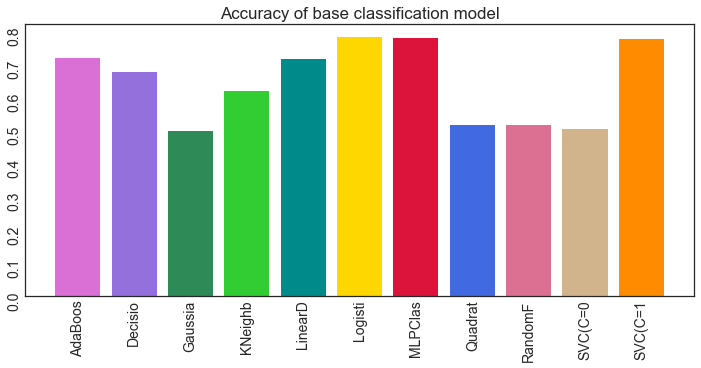

In [464]:
f, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=1)

ax.bar(accu_b['clf'], accu_b['score'],
       color=['gold', 'limegreen', 'tan', 'darkorange',
              'seagreen', 'darkcyan', 'royalblue', 'mediumpurple',
              'palevioletred', 'orchid', 'crimson'])
ax.set_title('Accuracy of base classification model')
ax.tick_params(rotation=90)


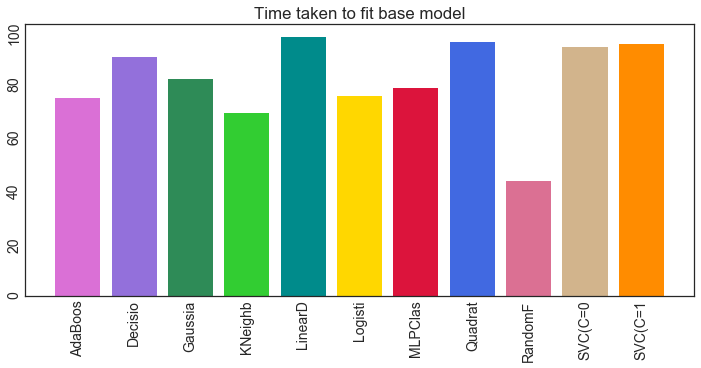

In [465]:
f, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=1)

ax.bar(time_b['clf'], time_b['score'],
       color=['gold', 'limegreen', 'tan', 'darkorange',
              'seagreen', 'darkcyan', 'royalblue', 'mediumpurple',
              'palevioletred', 'orchid', 'crimson'])
ax.set_title('Time taken to fit base model')
ax.tick_params(rotation=90)


From this it looks like the Neural Net performs the best of all classifiers. Followed by SVM, KNN and Losgistic Regression.
Let us run gridsearches for each of these classifiers, and see which one performs best. After which we can compare all the models again and perform an ensamble approach on the best one. 

---

## Logistic Regression

Below we do a gridsearch to optimize the hyperparameters of a logistic regression classifier. We solve for C, penalty, the solver and the maximum number of features for the vecorizer.

In [35]:
vectorizer = TfidfVectorizer(preprocessor=preprocess,
                             stop_words=stopwords_no_pro)

pipeline_logis = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', LogisticRegression())
])

penalty = ['l1', 'l2']
C = np.logspace(0, 3, 4)
solver = ['liblinear', 'saga']

param_grid = {'classify__C': C,
              'classify__penalty': penalty,
              'classify__solver': solver,
              'features__max_features': [1001, 10000, 50000]}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_logis, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)

In [36]:
scr_log = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, c

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6823529411764706, precision=0.6741573033707865, recall=0.7058823529411765, roc_auc=0.7367474048442907, f1=0.6896551724137931, total=  40.4s
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.631578947368421, precision=0.6385542168674698, recall=0.6162790697674418, roc_auc=0.7112175102599179, f1=0.6272189349112426, total=  34.9s
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6470588235294118, precision=0.6470588235294118, recall=0.6470588235294118, roc_auc=0.6878892733564014, f1=0.6470588235294118, total=  39.2s
[CV] classify__C=10.0, classify__penalty=l1, classify__solver

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6823529411764706, precision=0.6703296703296703, recall=0.7176470588235294, roc_auc=0.7400692041522491, f1=0.6931818181818181, total=  58.1s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7176470588235294, precision=0.7283950617283951, recall=0.6941176470588235, roc_auc=0.7508650519031143, f1=0.710843373493976, total=  51.6s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.631578947368421, precision=0.6493506493506493, recall=0.5813953488372093, roc_auc=0.7125854993160055, f1=0.6134969325153374, total=  52.5s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6257309941520468, precision=0.6195652173913043, recall=0.6627906976744186, roc_auc=0.7020519835841313, f1=0.6404494382022472, total= 1.0min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6588235294117647, precision=0.6451612903225806, recall=0.7058823529411765, roc_auc=0.6982698961937716, f1=0.6741573033707865, total= 1.0min
[CV] classify__C=10.0, classify__penalty=l2, classify_

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6470588235294118, precision=0.6436781609195402, recall=0.6588235294117647, roc_auc=0.6826297577854671, f1=0.6511627906976745, total=  28.0s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6140350877192983, precision=0.6190476190476191, recall=0.6046511627906976, roc_auc=0.7088919288645691, f1=0.611764705882353, total=  56.3s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6529411764705882, precision=0.6382978723404256, recall=0.7058823529411765, roc_auc=0.721522491349481, f1=0.670391061452514, total=  51.8s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6941176470588235, precision=0.6853932584269663, recall=0.7176470588235294, roc_auc=0.7392387543252595, f1=0.7011494252873562, total=  57.5s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6549707602339181, precision=0.68, recall=0.5930232558139535, roc_auc=0.7121751025991792, f1=0.6335403726708074, total=  36.7s
[CV] classify__C=100.0, classify__penalty=l1, classify__

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  3.3min


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.7176470588235294, precision=0.7283950617283951, recall=0.6941176470588235, roc_auc=0.7503114186851211, f1=0.710843373493976, total=  44.2s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6257309941520468, precision=0.6410256410256411, recall=0.5813953488372093, roc_auc=0.710123119015048, f1=0.6097560975609757, total=  47.1s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6411764705882353, precision=0.6428571428571429, recall=0.6352941176470588, roc_auc=0.7075432525951557, f1=0.6390532544378699, total=  45.7s
[CV] classify__C=100.0, classify__penalty=l1,

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.6432748538011696, precision=0.6582278481012658, recall=0.6046511627906976, roc_auc=0.7116279069767443, f1=0.6303030303030303, total=  45.6s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7, precision=0.6976744186046512, recall=0.7058823529411765, roc_auc=0.7504498269896195, f1=0.7017543859649124, total=  52.1s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.7, precision=0.6931818181818182, recall=0.7176470588235294, roc_auc=0.7464359861591696, f1=0.7052023121387283, total=  43.9s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.6294117647058823, precision=0.6222222222222222, recall=0.6588235294117647, roc_auc=0.7054671280276816, f1=0.64, total=  55.9s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.6294117647058823, precision=0.6222222222222222, recall=0.6588235294117647, roc_auc=0.7090657439446367, f1=0.64, total=  46.8s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6198830409356725, precision=0.6265060240963856, recall=0.6046511627906976, roc_auc=0.711764705882353, f1=0.6153846153846154, total=  56.5s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.6140350877192983, precision=0.6351351351351351, recall=0.5465116279069767, roc_auc=0.6896032831737345, f1=0.5874999999999999, total=  28.6s
[CV] classify__C=100.0, classify__penalty=l2, classif

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.6352941176470588, precision=0.6263736263736264, recall=0.6705882352941176, roc_auc=0.6746020761245675, f1=0.6477272727272727, total=  37.2s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.7, precision=0.6976744186046512, recall=0.7058823529411765, roc_auc=0.7508650519031141, f1=0.7017543859649124, total=  58.4s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.6176470588235294, precision=0.6219512195121951, recall=0.6, roc_auc=0.6516262975778546, f1=0.6107784431137725, total=  37.8s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6294117647058823, precision=0.6222222222222222, recall=0.6588235294117647, roc_auc=0.7056055363321799, f1=0.64, total= 1.1min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7176470588235294, precision=0.7283950617283951, recall=0.6941176470588235, roc_auc=0.7433910034602076, f1=0.710843373493976, total=  45.0s
[CV] classify__C=100.0, classify__penalty=l2, classify__solve

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6140350877192983, precision=0.625, recall=0.5813953488372093, roc_auc=0.7132694938440493, f1=0.6024096385542168, total=  56.2s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6432748538011696, precision=0.6623376623376623, recall=0.5930232558139535, roc_auc=0.6935704514363885, f1=0.6257668711656442, total=  31.1s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6882352941176471, precision=0.6904761904761905, recall=0.6823529411764706, roc_auc=0.7378546712802767, f1=0.6863905325443787, total=  55.6s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6294117647058823, precision=0.6222222222222222, recall=0.6588235294117647, roc_auc=0.6925951557093426, f1=0.64, total=  29.3s
[CV] classify__C=1000.0, classify__penal

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6176470588235294, precision=0.625, recall=0.5882352941176471, roc_auc=0.6802768166089964, f1=0.6060606060606061, total=  29.1s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.631578947368421, precision=0.6493506493506493, recall=0.5813953488372093, roc_auc=0.7143638850889192, f1=0.6134969325153374, total=  57.9s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.6176470588235294, precision=0.6111111111111112, recall=0.6470588235294118, roc_auc=0.7121107266435986, f1=0.6285714285714287, total=  54.0s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.7, precision=0.6931818181818182, recall=0.7176470588235294, roc_auc=0.7487889273356402, f1=0.7052023121387283, total=  56.7s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.6470588235294118, precision=0.6404494382022472, recall=0.6705882352941176, roc_auc=0.7061591695501731, f1=0.6551724137931035, total=  42.4s
[CV] classify__C=1000.0, classify__penalty=l1, 

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6235294117647059, precision=0.6296296296296297, recall=0.6, roc_auc=0.6834602076124567, f1=0.6144578313253012, total=  37.7s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6432748538011696, precision=0.6623376623376623, recall=0.5930232558139535, roc_auc=0.695485636114911, f1=0.6257668711656442, total=  38.6s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7, precision=0.6976744186046512, recall=0.7058823529411765, roc_auc=0.7496193771626297, f1=0.7017543859649124, total=  54.3s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, featu

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6374269005847953, precision=0.65, recall=0.6046511627906976, roc_auc=0.7129958960328318, f1=0.6265060240963854, total=  55.7s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.6374269005847953, precision=0.6538461538461539, recall=0.5930232558139535, roc_auc=0.7143638850889193, f1=0.6219512195121951, total=  38.4s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6352941176470588, precision=0.6292134831460674, recall=0.6588235294117647, roc_auc=0.7067128027681661, f1=0.6436781609195402, total=  54.2s
[CV] classify__C=1000.0, classify__penalty=l2

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.711764705882353, precision=0.7307692307692307, recall=0.6705882352941176, roc_auc=0.7384083044982699, f1=0.6993865030674846, total=  52.1s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.6352941176470588, precision=0.632183908045977, recall=0.6470588235294118, roc_auc=0.7051903114186852, f1=0.6395348837209304, total=  46.5s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6374269005847953, precision=0.6578947368421053, recall=0.5813953488372093, roc_auc=0.6846785225718195, f1=0.6172839506172839, total=  30.4s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6470588235294118, precision=0.6506024096385542, recall=0.6352941176470588, roc_auc=0.6844290657439446, f1=0.6428571428571428, total=  30.2s
[CV] classify__C=1000.0, classify__penalty=

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.631578947368421, precision=0.6455696202531646, recall=0.5930232558139535, roc_auc=0.7153214774281805, f1=0.6181818181818183, total= 1.0min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6941176470588235, precision=0.6987951807228916, recall=0.6823529411764706, roc_auc=0.7403460207612458, f1=0.6904761904761905, total=  57.5s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6432748538011696, precision=0.6582278481012658, recall=0.6046511627906976, roc_auc=0.7140902872777017, f1=0.6303030303030303, total=  42.3s
[CV] classify__C=1000.0, classify__

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6470588235294118, precision=0.654320987654321, recall=0.6235294117647059, roc_auc=0.6708650519031142, f1=0.6385542168674699, total=  36.7s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6294117647058823, precision=0.6222222222222222, recall=0.6588235294117647, roc_auc=0.6844290657439446, f1=0.64, total=  37.5s
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6941176470588235, precision=0.6941176470588235, recall=0.6941176470588235, roc_auc=0.7417301038062284, f1=0.6941176470588235, total=  49.8s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6257309941520468, precision=0.6447368421052632, recall=0.5697674418604651, roc_auc=0.6846785225718194, f1=0.6049382716049383, total=  4

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.7, precision=0.7023809523809523, recall=0.6941176470588235, roc_auc=0.7393771626297578, f1=0.6982248520710058, total=  39.0s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.6470588235294118, precision=0.6436781609195402, recall=0.6588235294117647, roc_auc=0.7071280276816609, f1=0.6511627906976745, total=  37.6s
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.6941176470588235, precision=0.6896551724137931, recall=0.7058823529411765, roc_auc=0.7483737024221454, f1=0.6976744186046512, total=  56.2s
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.631578947368421, precision=0.6455696202531646, recall=0.5930232558139535, roc_auc=0.7140902872777017, f1=0.6181818181818183, total=  59.0

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6294117647058823, precision=0.625, recall=0.6470588235294118, roc_auc=0.6928719723183391, f1=0.6358381502890174, total=  29.7s


[Parallel(n_jobs=-1)]: Done 134 out of 144 | elapsed:  7.7min remaining:   34.3s


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.6374269005847953, precision=0.6538461538461539, recall=0.5930232558139535, roc_auc=0.7131326949384404, f1=0.6219512195121951, total=  48.9s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6294117647058823, precision=0.6309523809523809, recall=0.6235294117647059, roc_auc=0.6819377162629758, f1=0.6272189349112426, total=  30.2s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7, precision=0.6976744186046512, recall=0.7058823529411765, roc_auc=0.7487889273356401, f1=0.7017543859649124, total=  57.3s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.6352941176470588, precision=0.6292134831460674, recall=0.6588235294117647, roc_auc=0.7092041522491349, f1=0.6436781609195402, total= 

[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  7.9min finished
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, c

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.7, precision=0.6533333333333333, recall=0.9245283018867925, roc_auc=0.820955439582497, f1=0.765625, total=  27.1s
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.65, precision=0.6097560975609756, recall=0.9433962264150944, roc_auc=0.811722199919711, f1=0.7407407407407408, total=  31.3s
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.76, precision=0.7164179104477612, recall=0.9056603773584906, roc_auc=0.8350060216780409, f1=0.7999999999999999, total=  27.7s
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.77, precision=0.75, recall=0.8490566037735849, roc_auc=0.8892011240465677, f1=0.7964601769911505, total=  36.8s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.59, precision=0.5714285714285714, recall=0.9056603773584906, roc_auc=0.7129666800481733, f1=0.7007299270072993, total=  39.2s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.77, precision=0.734375, recall=0.8867924528301887, roc_auc=0.8687274187073464, f1=0.8034188034188035, total=  35.7s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.72, precision=0.6865671641791045, recall=0.8679245283018868, roc_auc=0.8269771176234444, f1=0.7666666666666666, total=  38.2s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.69, precision=0.6571428571428571, recall=0.8679245283018868, roc_auc=0.7820152549177037, f1=0.7479674796747967, total=  36.7s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.76, precision=0.7377049180327869, recall=0.8490566037735849, roc_auc=0.8205539943797672, f1=0.7894736842105263, total=  22.8s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.2min


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.77, precision=0.75, recall=0.8490566037735849, roc_auc=0.8851866720192693, f1=0.7964601769911505, total=  32.9s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.76, precision=0.7377049180327869, recall=0.8490566037735849, roc_auc=0.8221597751906865, f1=0.7894736842105263, total=  28.1s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.76, precision=0.7377049180327869, recall=0.8490566037735849, roc_auc=0.8205539943797672, f1=0.7894736842105263, total=  25.4s
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.77, precision=0.734375, recall=0.8867924528301887, roc_auc=0.8679245283018868, f1=0.8034188034188035, total=  38.5s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.71, precision=0.6714285714285714, recall=0.8867924528301887, roc_auc=0.81413087113609, f1=0.7642276422764227, total=  30.8s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.67, precision=0.6388888888888888, recall=0.8679245283018868, roc_auc=0.7446808510638298, f1=0.736, total=  42.1s
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.67, precision=0.6351351351351351, recall=0.8867924528301887, roc_auc=0.8137294259333602, f1=0.7401574803149605, total=  40.1s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.77, precision=0.734375, recall=0.8867924528301887, roc_auc=0.8498594941790445, f1=0.8034188034188035, total=  27.4s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.67, precision=0.6351351351351351, recall=0.8867924528301887, roc_auc=0.8153352067442793, f1=0.7401574803149605, total=  38.7s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.66, precision=0.6301369863013698, recall=0.8679245283018868, roc_auc=0.739863508631072, f1=0.73015873015873, total=  41.3s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.74, precision=0.7454545454545455, recall=0.7735849056603774, roc_auc=0.7856282617422722, f1=0.7592592592592593, total=  21.3s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.74, precision=0.7142857142857143, recall=0.8490566037735849, roc_auc=0.8301886792452831, f1=0.7758620689655172, total=  28.1s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7, precision=0.6716417910447762, recall=0.8490566037735849, roc_auc=0.7860297069450021, f1=0.7500000000000001, total=  28.5s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.78, precision=0.7540983606557377, recall=0.8679245283018868, roc_auc=0.8121236451224408, f1=0.8070175438596491, total=  25.9s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_fea

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.72, precision=0.711864406779661, recall=0.7924528301886793, roc_auc=0.8057005218787635, f1=0.75, total=  27.1s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.7, precision=0.6666666666666666, recall=0.8679245283018868, roc_auc=0.81413087113609, f1=0.7540983606557377, total=  25.9s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.77, precision=0.75, recall=0.8490566037735849, roc_auc=0.8582898434363709, f1=0.7964601769911505, total=  34.0s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.72, precision=0.6865671641791045, recall=0.8679245283018868, roc_auc=0.823364110798876, f1=0.7666666666666666, total=  35.6s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.7, precision=0.6666666666666666, recall=0.8679245283018868, roc_auc=0.7936571657968687, f1=0.7540983606557377, total=  32.9s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.72, precision=0.6865671641791045, recall=0.8679245283018868, roc_auc=0.7575270975511843, f1=0.7666666666666666, total=  28.1s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.75, precision=0.7333333333333333, recall=0.8301886792452831, roc_auc=0.8635086310718587, f1=0.7787610619469026, total=  32.9s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, fe

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7, precision=0.6949152542372882, recall=0.7735849056603774, roc_auc=0.7988759534323565, f1=0.7321428571428573, total=  20.5s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.75, precision=0.7333333333333333, recall=0.8301886792452831, roc_auc=0.8478522681653955, f1=0.7787610619469026, total=  31.0s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.71, precision=0.6714285714285714, recall=0.8867924528301887, roc_auc=0.8169409875551986, f1=0.7642276422764227, total=  33.3s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.75, precision=0.7333333333333333, recall=0.8301886792452831, roc_auc=0.8542753914090726, f1=0.7787610619469026, total=  27.0s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.74, precision=0.7288135593220338, recall=0.8113207547169812, roc_auc=0.7964672822159775, f1=0.7678571428571428, total=  18.7s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.72, precision=0.6865671641791045, recall=0.8679245283018868, roc_auc=0.7567242071457246, f1=0.7666666666666666, total=  30.7s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.68, precision=0.647887323943662, recall=0.8679245283018868, roc_auc=0.7575270975511843, f1=0.7419354838709677, total=  40.1s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_feat

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.72, precision=0.6865671641791045, recall=0.8679245283018868, roc_auc=0.755921316740265, f1=0.7666666666666666, total=  29.5s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.76, precision=0.7377049180327869, recall=0.8490566037735849, roc_auc=0.8538739462063428, f1=0.7894736842105263, total=  28.2s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.75, precision=0.7258064516129032, recall=0.8490566037735849, roc_auc=0.8462464873544762, f1=0.782608695652174, total=  34.1s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.74, precision=0.7213114754098361, recall=0.8301886792452831, roc_auc=0.8249698916097953, f1=0.7719298245614035, total=  22.0s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, featu

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.73, precision=0.7241379310344828, recall=0.7924528301886793, roc_auc=0.8189482135688478, f1=0.7567567567567567, total=  24.4s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.71, precision=0.6714285714285714, recall=0.8867924528301887, roc_auc=0.81413087113609, f1=0.7642276422764227, total=  34.8s
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.75, precision=0.7258064516129032, recall=0.8490566037735849, roc_auc=0.8470493777599358, f1=0.782608695652174, total=  36.0s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.69, precision=0.6571428571428571, recall=0.8679245283018868, roc_auc=0.7507025291047772, f1=0.7479674796747967, total=  36.8s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, feature

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.71, precision=0.6764705882352942, recall=0.8679245283018868, roc_auc=0.8125250903251707, f1=0.7603305785123967, total=  26.6s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.76, precision=0.7377049180327869, recall=0.8490566037735849, roc_auc=0.8715375351264552, f1=0.7894736842105263, total=  30.0s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.71, precision=0.6818181818181818, recall=0.8490566037735849, roc_auc=0.7912484945804897, f1=0.7563025210084033, total=  28.9s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.76, precision=0.7457627118644068, recall=0.8301886792452831, roc_auc=0.8109193095142514, f1=0.7857142857142858, total=  14.5s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.71, precision=0.7068965517241379, recall=0.7735849056603774, roc_auc=0.7852268165395424, f1=0.7387387387387387, total=  22.9s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.79, precision=0.7758620689655172, recall=0.8490566037735849, roc_auc=0.8574869530309113, f1=0.8108108108108107, total=  36.1s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.69, precision=0.6571428571428571, recall=0.8679245283018868, roc_auc=0.7904456041750301, f1=0.7479674796747967, total=  34.6s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.71, precision=0.7068965517241379, recall=0.7735849056603774, roc_auc=0.8028904054596547, f1=0.7387387387387387, total=  25.2s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.7, precision=0.6666666666666666, recall=0.8679245283018868, roc_auc=0.8057005218787636, f1=0.754098360655737

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.72, precision=0.6865671641791045, recall=0.8679245283018868, roc_auc=0.760337213970293, f1=0.7666666666666666, total=  28.8s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.76, precision=0.7457627118644068, recall=0.8301886792452831, roc_auc=0.8097149739060618, f1=0.7857142857142858, total=  23.8s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.72, precision=0.711864406779661, recall=0.7924528301886793, roc_auc=0.7824167001204335, f1=0.75, total=  23.5s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.76, precision=0.7457627118644068, recall=0.8301886792452831, roc_auc=0.8490566037735849, f1=0.7857142857142858, total=  28.7s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.71, precision=0.7068965517241379, recall=0.7735849056603774, roc_auc=0.7980730630268967, f1=0.7387387387387387, total=  23.9s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.7, precision=0.6666666666666666, recall=0.8679245283018868, roc_auc=0.7595343235648334, f1=0.7540983606557377, total=  34.3s
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.75, precision=0.7333333333333333, recall=0.8301886792452831, roc_auc=0.8466479325572059, f1=0.7787610619469026, total=  37.0s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.71, precision=0.6764705882352942, recall=0.8679245283018868, roc_auc=0.8097149739060618, f1=0.7603305785123967, total=  29.7s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.77, precision=0.75, recall=0.8490566037735849, roc_auc=0.8458450421517463, f1=0.7964601769911505, total=  30.7s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.72, precision=0.711864406779661, recall=0.7924528301886793, roc_auc=0.79084704937776, f1=0.75, total=  19.5s
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.71, precision=0.6714285714285714, recall=0.8867924528301887, roc_auc=0.8113207547169812, f1=0.7642276422764227, total=  36.2s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga,

[Parallel(n_jobs=-1)]: Done 134 out of 144 | elapsed:  4.9min remaining:   21.9s


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.72, precision=0.7192982456140351, recall=0.7735849056603774, roc_auc=0.800080289040546, f1=0.7454545454545455, total=  21.2s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.74, precision=0.7076923076923077, recall=0.8679245283018868, roc_auc=0.7587314331593737, f1=0.7796610169491526, total=  34.5s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.71, precision=0.6714285714285714, recall=0.8867924528301887, roc_auc=0.8125250903251706, f1=0.7642276422764227, total=  36.9s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.75, precision=0.7333333333333333, recall=0.8301886792452831, roc_auc=0.8522681653954235, f1=0.7787610619469026, total=  24.6s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7, precision=0.6666666666666666, recall=0.8679245283018868, roc_auc=0.7543155359293455, f1=0.7540983606557377, total=  35.4s
[CV]  classify__C=1000.0, classify

[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  5.1min finished
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, c

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.8042168674698795, precision=0.8035714285714286, recall=0.8083832335329342, roc_auc=0.8950462710941751, f1=0.8059701492537314, total= 1.2min
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.8, precision=0.7873563218390804, recall=0.8253012048192772, roc_auc=0.8746326770496621, f1=0.8058823529411765, total= 1.2min
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.8132530120481928, precision=0.8220858895705522, recall=0.8023952095808383, roc_auc=0.8743966612230085, f1=0.8121212121212121, total= 1.2min
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, feature

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.8012048192771084, precision=0.772972972972973, recall=0.8562874251497006, roc_auc=0.8881509707857013, f1=0.8125, total= 1.8min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.8042168674698795, precision=0.7712765957446809, recall=0.8682634730538922, roc_auc=0.8872799854835784, f1=0.8169014084507042, total= 1.9min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.7818181818181819, precision=0.7611111111111111, recall=0.8253012048192772, roc_auc=0.8587275933000293, f1=0.791907514450867, total= 2.0min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.7680722891566265, precision=0.7678571428571429, recall=0.7724550898203593, roc_auc=0.8608600979858465, f1=0.7701492537313434, total=  59.7s
[CV] classify__C=10.0, classify__penalty=l2, classify__solve

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.8, precision=0.7777777777777778, recall=0.8433734939759037, roc_auc=0.8772406699970614, f1=0.8092485549132947, total= 1.8min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.8192771084337349, precision=0.8128654970760234, recall=0.8323353293413174, roc_auc=0.910215931772818, f1=0.8224852071005917, total= 2.0min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.822289156626506, precision=0.8292682926829268, recall=0.8143712574850299, roc_auc=0.8898203592814371, f1=0.8217522658610271, total= 2.2min
[CV] classify__C=10.0, classify__penalty=l2, classify__s

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  6.4min


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.8072289156626506, precision=0.8121212121212121, recall=0.8023952095808383, roc_auc=0.8708401379060063, f1=0.8072289156626505, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.8192771084337349, precision=0.8407643312101911, recall=0.7904191616766467, roc_auc=0.8906913445835601, f1=0.8148148148148149, total= 1.5min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7818181818181819, precision=0.7732558139534884, recall=0.8012048192771084, roc_auc=0.8688289744343226, f1=0.7869822485207101, total= 1.3min
[CV] classify__C=100.0, classify__p

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.8102409638554217, precision=0.825, recall=0.7904191616766467, roc_auc=0.8852476864452913, f1=0.8073394495412844, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.8012048192771084, precision=0.7759562841530054, recall=0.8502994011976048, roc_auc=0.9050988931228452, f1=0.8114285714285715, total= 1.6min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.8192771084337349, precision=0.8282208588957055, recall=0.8083832335329342, roc_auc=0.8833605516240247, f1=0.8181818181818183, total= 1.9min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.803030303030303, precision=0.7853107344632768, recall=0.8373493975903614, roc_auc=0.8813546870408463, f1=0.8104956268221575, total= 2.1min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.7650602409638554, precision=0.7763975155279503, recall=0.7485029940119761, roc_auc=0.8433678098348757, f1=0.7621951219512194, total=  57.4s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.7333333333333333, precision=0.7142857142857143, recall=0.7831325301204819, roc_auc=0.8006905671466353, f1=0.7471264367816092, total= 1.2min
[CV] classify__C=100.0, class

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7909090909090909, precision=0.7803468208092486, recall=0.8132530120481928, roc_auc=0.871436967381722, f1=0.7964601769911503, total= 1.4min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.8102409638554217, precision=0.8291139240506329, recall=0.7844311377245509, roc_auc=0.8878606423516603, f1=0.806153846153846, total= 1.5min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.822289156626506, precision=0.8333333333333334, recall=0.8083832335329342, roc_auc=0.883142805298494, f1=0.8206686930091186, total= 1.9min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.8072289156626506, precision=0.8121212121212121, recall=0.8023952095808383, roc_auc=0.9012157503175469, f1=0.8072289156626505, total= 1.6min
[CV] classify__C=100.0, classify_

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7951807228915663, precision=0.8, recall=0.7904191616766467, roc_auc=0.8530212302667393, f1=0.7951807228915663, total= 1.0min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.803030303030303, precision=0.791907514450867, recall=0.8253012048192772, roc_auc=0.8779385836027035, f1=0.808259587020649, total= 1.4min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.822289156626506, precision=0.8292682926829268, recall=0.8143712574850299, roc_auc=0.9014334966430775, f1=0.8217522658610271, total= 1.4min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=s

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7636363636363637, precision=0.7417582417582418, recall=0.8132530120481928, roc_auc=0.8449162503673229, f1=0.7758620689655173, total=  54.9s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.8132530120481928, precision=0.8220858895705522, recall=0.8023952095808383, roc_auc=0.8886953365995283, f1=0.8121212121212121, total= 1.9min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.8102409638554217, precision=0.7921348314606742, recall=0.844311377245509, roc_auc=0.9043367809834876, f1=0.817391304347826, total= 2.0min
[CV] classify__C=1000.0, classify__

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.8102409638554217, precision=0.8209876543209876, recall=0.7964071856287425, roc_auc=0.8856831790963529, f1=0.8085106382978723, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.803030303030303, precision=0.7853107344632768, recall=0.8373493975903614, roc_auc=0.8855421686746988, f1=0.8104956268221575, total= 2.1min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.806060606060606, precision=0.7931034482758621, recall=0.8313253012048193, roc_auc=0.8810240963855422, f1=0.8117647058823529, total= 1.2min
[CV] classify__C=1000.0, classify__

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.8192771084337349, precision=0.8128654970760234, recall=0.8323353293413174, roc_auc=0.8998366902558519, f1=0.8224852071005917, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.7951807228915663, precision=0.8, recall=0.7904191616766467, roc_auc=0.8549083650880059, f1=0.7951807228915663, total= 1.3min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.7666666666666667, precision=0.7405405405405405, recall=0.8253012048192772, roc_auc=0.8480384954451954, f1=0.7806267806267806, total= 1.2min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.7831325301204819, precision=0.7810650887573964, recall=0.7904191616766467, roc_auc=0.8527309018326982, f1=0.7857142857142857, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.8162650602409639, precision=0.8154761904761905, recall=0.8203592814371258, roc_auc=0.8858646343676284, f1=0.817910447761194, total= 1.8min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.822289156626506, precision=0.813953488372093, recall=0.8383233532934131, roc_auc=0.8999092723643622, f1=0.8259587020648967, total= 1.6min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.8132530120481928, precision=0.8260869565217391, recall=0.7964071856287425, roc_auc=0.8856831790963527, f1=0.8109756097560975, total= 1.5min
[CV] classify__C=1000.0, classify__penalty=l1

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.8072289156626506, precision=0.8121212121212121, recall=0.8023952095808383, roc_auc=0.8996552349845763, f1=0.8072289156626505, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.8102409638554217, precision=0.825, recall=0.7904191616766467, roc_auc=0.8876428960261296, f1=0.8073394495412844, total= 1.4min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.8132530120481928, precision=0.8143712574850299, recall=0.8143712574850299, roc_auc=0.8853565596080566, f1=0.8143712574850299, total= 1.8min
[CV] classify__C=1000.0, classify__pen

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.7740963855421686, precision=0.7674418604651163, recall=0.7904191616766467, roc_auc=0.850916349119942, f1=0.7787610619469026, total= 1.0min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.7801204819277109, precision=0.7865853658536586, recall=0.7724550898203593, roc_auc=0.8459081836327345, f1=0.7794561933534744, total= 1.0min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.7545454545454545, precision=0.7297297297297297, recall=0.8132530120481928, roc_auc=0.8393329415221863, f1=0.7692307692307693, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.8283132530120482, precision=0.8313253012048193, recall=0.8263473053892215, roc_auc=0.9094175285792052, f1=0.8288288288288288, total= 1.9min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.803030303030303, precision=0.7853107344632768, recall=0.8373493975903614, roc_auc=0.8823464590067589, f1=0.8104956268221575, total= 1.9min
[CV] classify__C=1000.0, classify__p

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7620481927710844, precision=0.7650602409638554, recall=0.7604790419161677, roc_auc=0.8379967338051171, f1=0.7627627627627627, total=  58.2s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7771084337349398, precision=0.7719298245614035, recall=0.7904191616766467, roc_auc=0.8452912357103973, f1=0.7810650887573964, total= 1.1min
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.8072289156626506, precision=0.8238993710691824, recall=0.7844311377245509, roc_auc=0.8916349119941934, f1=0.8036809815950919, total= 2.1min
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.8, precision=0.7873563218390804, recall=0.8253012048192772, roc_auc=0.8805465765501028, f1=0.8058823529411765, total= 1.5min
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.8283132530120482, precision=0.8235294117647058, recall=0.8383233532934131, roc_auc=0.9016512429686082, f1=0.8308605341246291, total= 1.6mi

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.803030303030303, precision=0.791907514450867, recall=0.8253012048192772, roc_auc=0.8784528357331766, f1=0.808259587020649, total= 1.3min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.8283132530120482, precision=0.8235294117647058, recall=0.8383233532934131, roc_auc=0.8976592270005443, f1=0.8308605341246291, total= 1.4min
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.803030303030303, precision=0.791907514450867, recall=0.8253012048192772, roc_auc=0.8820526006464885, f1=0.808259587020649, total= 1.9min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.7951807228915663, precision=0.8, recall=0.7904191616766467, roc_auc=0.8539285066231173, f1=0.7951807228915663, total= 1.0min
[CV]

[Parallel(n_jobs=-1)]: Done 134 out of 144 | elapsed: 15.1min remaining:  1.1min
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.7575757575757576, precision=0.7311827956989247, recall=0.8192771084337349, roc_auc=0.8448060534822215, f1=0.7727272727272727, total=  56.9s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.8102409638554217, precision=0.8095238095238095, recall=0.8143712574850299, roc_auc=0.8859009254218835, f1=0.8119402985074626, total= 1.7min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.8102409638554217, precision=0.7954545454545454, recall=0.8383233532934131, roc_auc=0.9044456541462529, f1=0.8163265306122448, total= 1.7min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.8042168674698795, precision=0.8148148148148148, recall=0.7904191616766467, roc_auc=0.8861186717474143, f1=0.8024316109422491, total= 1.1min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.822289156626506, precision=0.8214285714285714, recall=0.8263473053892215, roc_auc=0.9003447650154237, f1=0.823880597014925

[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 15.5min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV] classify__C=1.0, c

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.704225352112676, precision=0.7164179104477612, recall=0.676056338028169, roc_auc=0.7930966078159096, f1=0.6956521739130436, total= 1.1min
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6890459363957597, precision=0.6625766871165644, recall=0.7659574468085106, roc_auc=0.7687543701927879, f1=0.7105263157894737, total= 1.1min
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.676056338028169, precision=0.6953125, recall=0.6267605633802817, roc_auc=0.7674072604641937, f1=0.6592592592592592, total= 1.1min
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000 
[CV] classify__C=10.0, classify__penalty=l1, classify__solver=saga, fea

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.6749116607773852, precision=0.6580645161290323, recall=0.723404255319149, roc_auc=0.7653581060833083, f1=0.6891891891891891, total= 1.7min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.6607773851590106, precision=0.6666666666666666, recall=0.6382978723404256, roc_auc=0.736389971031865, f1=0.6521739130434782, total= 1.7min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=1.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.6607773851590106, precision=0.6666666666666666, recall=0.6382978723404256, roc_auc=0.7351912895814604, f1=0.6521739130434782, total= 1.6min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6890459363957597, precision=0.6754966887417219, recall=0.723404255319149, roc_auc=0.7613125561881929, f1=0.6986301369863014, total=  45.6s
[CV] classify__C=10.0, classify__penalty=l2, classify__s

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6855123674911661, precision=0.6733333333333333, recall=0.7163120567375887, roc_auc=0.7707022275496954, f1=0.6941580756013745, total=  45.6s
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6925795053003534, precision=0.6708860759493671, recall=0.75177304964539, roc_auc=0.7949255818599541, f1=0.7090301003344481, total= 1.4min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.7077464788732394, precision=0.7251908396946565, recall=0.6690140845070423, roc_auc=0.7898234477286252, f1=0.6959706959706959, total= 1.5min
[CV] classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.6749116607773852, precision=0.6622516556291391, recall=0.7092198581560284, roc_auc=0.7704025571870942, f1=0.6849315068493151, total= 1.8min
[CV] classify__C=10.0, classify__penalty=

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  5.6min


[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.704225352112676, precision=0.7196969696969697, recall=0.6690140845070423, roc_auc=0.7965185479071613, f1=0.6934306569343066, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6855123674911661, precision=0.6756756756756757, recall=0.7092198581560284, roc_auc=0.7791429427629607, f1=0.6920415224913495, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=10.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6996466431095406, precision=0.6917808219178082, recall=0.7163120567375887, roc_auc=0.7900809109979022, f1=0.7038327526132405, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l1

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.6971830985915493, precision=0.7153846153846154, recall=0.6549295774647887, roc_auc=0.7941380678436819, f1=0.6838235294117647, total= 1.1min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.7137809187279152, precision=0.689873417721519, recall=0.7730496453900709, roc_auc=0.7935271201678155, f1=0.7290969899665553, total= 1.1min
[CV] classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7067137809187279, precision=0.68125, recall=0.7730496453900709, roc_auc=0.7905803616022375, f1=0.7242524916943521, total= 1.4min
[CV] classify__C=100.0, classify__penalty=l1, classify__sol

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7077464788732394, precision=0.7286821705426356, recall=0.6619718309859155, roc_auc=0.7849633009323547, f1=0.6937269372693726, total= 1.5min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.6855123674911661, precision=0.6733333333333333, recall=0.7163120567375887, roc_auc=0.7778943162521227, f1=0.6941580756013745, total=  58.9s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.696113074204947, precision=0.6950354609929078, recall=0.6950354609929078, roc_auc=0.7681550294675857, f1=0.6950354609929078, total= 1.5min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.6713780918727915, precision=0.6518987341772152, recall=0.7304964539007093, roc_auc=0.7366396963340326, f1=0.6889632107023411, total= 1.0min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.6725352112676056, precision=0.6814814814814815, recall=0.647887323943662, roc_auc=0.7504959333465582, f1=0.6642599277978338, total=  53.0s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=1001, accuracy=0.6819787985865724, precision=0.673469387755102, recall=0.7021276595744681, roc_auc=0.7404355209269804, f1=0.6875000000000001, total= 1.0min
[CV] classify__C=100.0, class

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.6784452296819788, precision=0.6666666666666666, recall=0.7092198581560284, roc_auc=0.7735490959944061, f1=0.6872852233676976, total= 1.1min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.7077464788732394, precision=0.7286821705426356, recall=0.6619718309859155, roc_auc=0.7850624876016663, f1=0.6937269372693726, total= 1.4min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7077464788732394, precision=0.7251908396946565, recall=0.6690140845070423, roc_auc=0.7977583812735569, f1=0.6959706959706959, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=10.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.7067137809187279, precision=0.68125, recall=0.7730496453900709, roc_auc=0.7906802517231045, f1=0.7242524916943521, total= 1.7min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7031802120141343, precision=0.6993006993006993, recall=0.7092198581560284, roc_auc=0.7877334931575267, f1=0.704225352112676, total= 1.4min
[CV] classify__C=100.0, classify__penalty=l2, cl

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.6819787985865724, precision=0.6645161290322581, recall=0.7304964539007093, roc_auc=0.7812905803616024, f1=0.695945945945946, total= 1.2min
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.696113074204947, precision=0.6729559748427673, recall=0.7588652482269503, roc_auc=0.7605633802816901, f1=0.7133333333333334, total=  50.3s
[CV] classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7147887323943662, precision=0.7364341085271318, recall=0.6690140845070423, roc_auc=0.7913608411029558, f1=0.7011070110701106, total=  51.3s
[CV] classify__C=1000.0, classify__penalty=

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.6784452296819788, precision=0.6666666666666666, recall=0.7092198581560284, roc_auc=0.7445809609429629, f1=0.6872852233676976, total=  50.4s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.7112676056338029, precision=0.7272727272727273, recall=0.676056338028169, roc_auc=0.7886828010315413, f1=0.7007299270072992, total= 1.7min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.6996466431095406, precision=0.6728395061728395, recall=0.7730496453900709, roc_auc=0.7969233842772949, f1=0.7194719471947194, total= 1.6min
[CV] classify__C=1000.0, classify_

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.7147887323943662, precision=0.7401574803149606, recall=0.6619718309859155, roc_auc=0.7933445744891887, f1=0.6988847583643123, total=  57.8s
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.7137809187279152, precision=0.6973684210526315, recall=0.75177304964539, roc_auc=0.789581460393567, f1=0.7235494880546075, total= 1.2min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.6819787985865724, precision=0.6645161290322581, recall=0.7304964539007093, roc_auc=0.7773948656477874, f1=0.695945945945946, total= 1.2min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6890459363957597, precision=0.6687898089171974, recall=0.7446808510638298, roc_auc=0.7627609629407651, f1=0.7046979865771812, total= 1.1min
[CV] classify__C=1000.0, classify__penalty=l

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.7147887323943662, precision=0.7401574803149606, recall=0.6619718309859155, roc_auc=0.7938901011704027, f1=0.6988847583643123, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.7173144876325088, precision=0.6993464052287581, recall=0.7588652482269503, roc_auc=0.7901808011187693, f1=0.727891156462585, total= 1.3min
[CV] classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.6855123674911661, precision=0.6688311688311688, recall=0.7304964539007093, roc_auc=0.7779942063729898, f1=0.6983050847457627, total= 1.2min
[CV] classify__C=1000.0, classify__penalty=l1, c

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7077464788732394, precision=0.7286821705426356, recall=0.6619718309859155, roc_auc=0.8005852013489386, f1=0.6937269372693726, total= 1.0min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.7173144876325088, precision=0.7103448275862069, recall=0.7304964539007093, roc_auc=0.7867845370092899, f1=0.7202797202797203, total= 1.1min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=10000, accuracy=0.6855123674911661, precision=0.6733333333333333, recall=0.7163120567375887, roc_auc=0.77105184297273, f1=0.6941580756013745, total= 1.1min
[CV] classify__C=1000

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=100.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000, accuracy=0.704225352112676, precision=0.7230769230769231, recall=0.6619718309859155, roc_auc=0.7889307677048204, f1=0.6911764705882353, total= 1.7min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.721830985915493, precision=0.7441860465116279, recall=0.676056338028169, roc_auc=0.7930470144812538, f1=0.7084870848708487, total=  58.1s
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6996466431095406, precision=0.675, recall=0.7659574468085106, roc_auc=0.7553191489361701, f1=0.717607973421927, total= 1.1min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=1001, accuracy=0.6643109540636042, precision=0.6575342465753424, recall=0.6808510638297872, roc_auc=0.749375686744581, f1=0.6689895470383275, total= 1.0min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.7007042253521126, precision=0.7175572519083969, recall=0.6619718309859155, roc_auc=0.7862031342987503, f1=0.6886446886446885, total= 1.7min
[CV] classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=50000 
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=liblinear, features__max_features=50000, accuracy=0.7137809187279152, precision=0.689873417721519, recall=0.7730496453900709, roc_auc=0.7914793726900409, f1=0.7290969899665553, total= 1.6min
[CV] classify__C=1000.0, classify__pe

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7253521126760564, precision=0.7461538461538462, recall=0.6830985915492958, roc_auc=0.7804999008133308, f1=0.7132352941176471, total=  59.8s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=1001, accuracy=0.7031802120141343, precision=0.6727272727272727, recall=0.7872340425531915, roc_auc=0.7507741484367196, f1=0.7254901960784313, total= 1.0min
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=10000, accuracy=0.7067137809187279, precision=0.6883116883116883, recall=0.75177304964539, roc_auc=0.7911297572670063, f1=0.7186440677966103, total= 1.4min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.7112676056338029, precision=0.7419354838709677, recall=0.647887323943662, roc_auc=0.7913112477683001, f1=0.6917293233082707, total= 1.1min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.7137809187279152, precision=0.7, recall=0.7446808510638298, roc_auc=0.7863350314653881, f1=0.7216494845360825, total= 1.2min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=10000, accuracy=0.6890459363957597, precision=0.673202614379085, recall=0.7304964539007093, roc_auc=0.7761961841973829, f1=0.7006802721088436, total= 1.2min
[CV]  classify__C=1000.0, classify__penalty=l1, classify__solver=saga, features__max_features=50000, accuracy=0.7102473498233216, precision=0.6878980891719745, recall=0.7659574468085106, roc_auc=0.7949755269203875, f1=0.7248322147651005, total= 1

[Parallel(n_jobs=-1)]: Done 134 out of 144 | elapsed: 12.8min remaining:   57.4s
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=1001, accuracy=0.6819787985865724, precision=0.6711409395973155, recall=0.7092198581560284, roc_auc=0.7501248626510838, f1=0.6896551724137931, total=  51.6s
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7077464788732394, precision=0.7286821705426356, recall=0.6619718309859155, roc_auc=0.7877405276730808, f1=0.6937269372693726, total= 1.6min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=liblinear, features__max_features=50000, accuracy=0.7208480565371025, precision=0.6987179487179487, recall=0.7730496453900709, roc_auc=0.7920287683548098, f1=0.734006734006734, total= 1.5min
[CV]  classify__C=1000.0, classify__penalty=l2, classify__solver=saga, features__max_features=10000, accuracy=0.7208480565371025, precision=0.7039473684210527, recall=0.7588652482269503, roc_auc=0.7910798122065728, f1=0.7303754266211605

[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 13.3min finished
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [37]:
save_obj(scr_log, 'scores_logis')


In [466]:
scr_log = load_obj('scores_logis')

print('Mind test F1 score:', scr_log['mind_f1_test'])
print('Energy test F1 score:', scr_log['energy_f1_test'])
print('Nature test F1 score:', scr_log['nature_f1_test'])
print('Tactics test F1 score:', scr_log['tactics_f1_test'])


Mind test F1 score: 0.8209331763627005
Energy test F1 score: 0.8031615508125576
Nature test F1 score: 0.8494614103502748
Tactics test F1 score: 0.7664351596949465


---

## K-Nearest Neighbours

Below we do a gridsearch to optimize the hyperparameters of a K-nearest Neighbours classifier. We solve for the number of neighbours to include.

In [38]:
vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords_all)

pipeline_knn = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', KNeighborsClassifier())
])

neighbours = [2, 5, 10, 20, 30, 50, 100]

param_grid = {'classify__n_neighbors': neighbours}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_knn, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [39]:
scr_knn = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=30 ........................................
[CV] classify__n_

[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:  1.2min remaining:  5.2min


[CV]  classify__n_neighbors=10, accuracy=0.5588235294117647, precision=0.5581395348837209, recall=0.5647058823529412, roc_auc=0.5714878892733564, f1=0.5614035087719299, total=  57.5s
[CV]  classify__n_neighbors=20, accuracy=0.5672514619883041, precision=0.5566037735849056, recall=0.686046511627907, roc_auc=0.620656634746922, f1=0.6145833333333333, total=  56.5s
[CV]  classify__n_neighbors=10, accuracy=0.6198830409356725, precision=0.6329113924050633, recall=0.5813953488372093, roc_auc=0.6323529411764706, f1=0.6060606060606061, total=  56.5s
[CV]  classify__n_neighbors=100, accuracy=0.5555555555555556, precision=0.53125, recall=0.9883720930232558, roc_auc=0.705950752393981, f1=0.6910569105691057, total=  57.4s
[CV]  classify__n_neighbors=5, accuracy=0.5764705882352941, precision=0.5607476635514018, recall=0.7058823529411765, roc_auc=0.595916955017301, f1=0.625, total=  57.4s
[CV]  classify__n_neighbors=100, accuracy=0.5647058823529412, precision=0.5390070921985816, recall=0.894117647058

[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:  1.2min remaining:  1.4min


[CV]  classify__n_neighbors=10, accuracy=0.5176470588235295, precision=0.514018691588785, recall=0.6470588235294118, roc_auc=0.5782006920415225, f1=0.5729166666666667, total=  58.7s
[CV]  classify__n_neighbors=2, accuracy=0.5058823529411764, precision=0.5116279069767442, recall=0.25882352941176473, roc_auc=0.5001384083044982, f1=0.34375000000000006, total=  55.9s
[CV]  classify__n_neighbors=30, accuracy=0.5588235294117647, precision=0.5480769230769231, recall=0.6705882352941176, roc_auc=0.6382006920415225, f1=0.6031746031746031, total=  57.7s
[CV]  classify__n_neighbors=2, accuracy=0.5705882352941176, precision=0.6875, recall=0.25882352941176473, roc_auc=0.5863667820069205, f1=0.3760683760683761, total=  58.7s
[CV]  classify__n_neighbors=50, accuracy=0.5529411764705883, precision=0.5328467153284672, recall=0.8588235294117647, roc_auc=0.6239446366782007, f1=0.6576576576576577, total=  58.3s
[CV]  classify__n_neighbors=30, accuracy=0.6081871345029239, precision=0.5772357723577236, recall

[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:  1.2min remaining:   23.3s


[CV]  classify__n_neighbors=20, accuracy=0.5764705882352941, precision=0.5643564356435643, recall=0.6705882352941176, roc_auc=0.5874048442906573, f1=0.6129032258064516, total=  58.7s
[CV]  classify__n_neighbors=100, accuracy=0.6, precision=0.5620437956204379, recall=0.9058823529411765, roc_auc=0.6642906574394464, f1=0.6936936936936937, total=  58.9s


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.3min finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=30 ........................................
[CV] classify__n_

[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:   45.7s remaining:  3.2min


[CV]  classify__n_neighbors=100, accuracy=0.61, precision=0.5813953488372093, recall=0.9433962264150944, roc_auc=0.7707747892412687, f1=0.7194244604316548, total=  33.7s
[CV]  classify__n_neighbors=2, accuracy=0.51, precision=0.6111111111111112, recall=0.20754716981132076, roc_auc=0.5987555198715375, f1=0.3098591549295775, total=  35.7s
[CV]  classify__n_neighbors=20, accuracy=0.63, precision=0.6904761904761905, recall=0.5471698113207547, roc_auc=0.7017262143717383, f1=0.6105263157894737, total=  36.3s
[CV]  classify__n_neighbors=50, accuracy=0.59, precision=0.5652173913043478, recall=0.9811320754716981, roc_auc=0.7515054195102369, f1=0.7172413793103447, total=  35.3s
[CV]  classify__n_neighbors=100, accuracy=0.54, precision=0.5353535353535354, recall=1.0, roc_auc=0.7254114813327981, f1=0.6973684210526315, total=  36.0s
[CV]  classify__n_neighbors=10, accuracy=0.56, precision=0.6216216216216216, recall=0.4339622641509434, roc_auc=0.6240465676435166, f1=0.5111111111111112, total=  35.4s

[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:   46.5s remaining:   51.1s


[CV]  classify__n_neighbors=2, accuracy=0.64, precision=0.7741935483870968, recall=0.4528301886792453, roc_auc=0.6459253311922922, f1=0.5714285714285714, total=  35.8s
[CV]  classify__n_neighbors=5, accuracy=0.57, precision=0.6086956521739131, recall=0.5283018867924528, roc_auc=0.5742673625050181, f1=0.5656565656565657, total=  35.7s
[CV]  classify__n_neighbors=20, accuracy=0.68, precision=0.647887323943662, recall=0.8679245283018868, roc_auc=0.7356483340024087, f1=0.7419354838709677, total=  35.1s
[CV]  classify__n_neighbors=10, accuracy=0.63, precision=0.7222222222222222, recall=0.49056603773584906, roc_auc=0.690887193898033, f1=0.5842696629213483, total=  34.2s
[CV]  classify__n_neighbors=20, accuracy=0.62, precision=0.7272727272727273, recall=0.4528301886792453, roc_auc=0.6860698514652749, f1=0.5581395348837209, total=  35.4s


[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:   47.0s remaining:   14.7s


[CV]  classify__n_neighbors=30, accuracy=0.69, precision=0.7619047619047619, recall=0.6037735849056604, roc_auc=0.7583299879566439, f1=0.6736842105263159, total=  35.9s
[CV]  classify__n_neighbors=50, accuracy=0.7, precision=0.6716417910447762, recall=0.8490566037735849, roc_auc=0.79084704937776, f1=0.7500000000000001, total=  36.1s
[CV]  classify__n_neighbors=2, accuracy=0.59, precision=0.75, recall=0.33962264150943394, roc_auc=0.6266559614612606, f1=0.4675324675324676, total=  36.9s
[CV]  classify__n_neighbors=50, accuracy=0.68, precision=0.6909090909090909, recall=0.7169811320754716, roc_auc=0.7063428342031314, f1=0.7037037037037037, total=  36.9s


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   47.8s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=30 ........................................
[CV] classify__n_

[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:  2.9min remaining: 12.2min


[CV]  classify__n_neighbors=50, accuracy=0.5575757575757576, precision=0.532258064516129, recall=0.9939759036144579, roc_auc=0.8376432559506317, f1=0.6932773109243698, total= 2.3min
[CV]  classify__n_neighbors=20, accuracy=0.5662650602409639, precision=0.5392491467576792, recall=0.9461077844311377, roc_auc=0.7802213754309563, f1=0.6869565217391305, total= 2.3min
[CV]  classify__n_neighbors=10, accuracy=0.5993975903614458, precision=0.5708333333333333, recall=0.8203592814371258, roc_auc=0.6790600616947922, f1=0.6732186732186731, total= 2.3min
[CV]  classify__n_neighbors=30, accuracy=0.5813253012048193, precision=0.5472972972972973, recall=0.9700598802395209, roc_auc=0.8026492469606242, f1=0.6997840172786176, total= 2.4min
[CV]  classify__n_neighbors=100, accuracy=0.5666666666666667, precision=0.5374592833876222, recall=0.9939759036144579, roc_auc=0.8651006464883927, f1=0.6976744186046512, total= 2.4min
[CV]  classify__n_neighbors=30, accuracy=0.5843373493975904, precision=0.549152542372

[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:  2.9min remaining:  3.2min


[CV]  classify__n_neighbors=5, accuracy=0.6174698795180723, precision=0.588495575221239, recall=0.7964071856287425, roc_auc=0.6725458174559971, f1=0.6768447837150127, total= 2.4min
[CV]  classify__n_neighbors=10, accuracy=0.6265060240963856, precision=0.5817490494296578, recall=0.9161676646706587, roc_auc=0.7737071311921611, f1=0.7116279069767442, total= 2.3min
[CV]  classify__n_neighbors=50, accuracy=0.5602409638554217, precision=0.5351170568561873, recall=0.9580838323353293, roc_auc=0.8268735256759209, f1=0.686695278969957, total= 2.3min
[CV]  classify__n_neighbors=20, accuracy=0.6060606060606061, precision=0.5629370629370629, recall=0.9698795180722891, roc_auc=0.7656295915368792, f1=0.7123893805309733, total= 2.4min


[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:  2.9min remaining:   54.5s


[CV]  classify__n_neighbors=5, accuracy=0.6151515151515151, precision=0.5758754863813229, recall=0.891566265060241, roc_auc=0.6713377901851307, f1=0.6997635933806147, total= 2.4min
[CV]  classify__n_neighbors=20, accuracy=0.5963855421686747, precision=0.5587188612099644, recall=0.9401197604790419, roc_auc=0.7673017601161314, f1=0.7008928571428571, total= 2.4min
[CV]  classify__n_neighbors=2, accuracy=0.5933734939759037, precision=0.6403508771929824, recall=0.437125748502994, roc_auc=0.6198693522046815, f1=0.5195729537366548, total= 2.4min
[CV]  classify__n_neighbors=100, accuracy=0.5542168674698795, precision=0.5307443365695793, recall=0.9820359281437125, roc_auc=0.8468698965704955, f1=0.6890756302521008, total= 2.4min
[CV]  classify__n_neighbors=30, accuracy=0.5818181818181818, precision=0.5469798657718121, recall=0.9819277108433735, roc_auc=0.7783389656185719, f1=0.7025862068965518, total= 2.4min


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  2.9min finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=2 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=5 .........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=10 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=20 ........................................
[CV] classify__n_neighbors=30 ........................................
[CV] classify__n_

[Parallel(n_jobs=-1)]: Done   4 out of  21 | elapsed:  2.3min remaining:  9.6min


[CV]  classify__n_neighbors=5, accuracy=0.5795053003533569, precision=0.5632183908045977, recall=0.6950354609929078, roc_auc=0.6434422135650785, f1=0.6222222222222222, total= 1.9min
[CV]  classify__n_neighbors=10, accuracy=0.607773851590106, precision=0.5806451612903226, recall=0.7659574468085106, roc_auc=0.685171311557287, f1=0.6605504587155964, total= 1.9min
[CV]  classify__n_neighbors=50, accuracy=0.6289752650176679, precision=0.59375, recall=0.8085106382978723, roc_auc=0.7103685945459993, f1=0.6846846846846846, total= 1.8min
[CV]  classify__n_neighbors=5, accuracy=0.528169014084507, precision=0.524390243902439, recall=0.6056338028169014, roc_auc=0.5261604840309462, f1=0.5620915032679739, total= 1.8min
[CV]  classify__n_neighbors=50, accuracy=0.6584507042253521, precision=0.6642335766423357, recall=0.6408450704225352, roc_auc=0.6952737552073002, f1=0.6523297491039426, total= 1.8min
[CV]  classify__n_neighbors=2, accuracy=0.5724381625441696, precision=0.6190476190476191, recall=0.368

[Parallel(n_jobs=-1)]: Done  10 out of  21 | elapsed:  2.3min remaining:  2.5min


[CV]  classify__n_neighbors=10, accuracy=0.5598591549295775, precision=0.5702479338842975, recall=0.4859154929577465, roc_auc=0.5824489188653045, f1=0.5247148288973383, total= 1.9min
[CV]  classify__n_neighbors=20, accuracy=0.6537102473498233, precision=0.6080402010050251, recall=0.8581560283687943, roc_auc=0.720057936270103, f1=0.711764705882353, total= 1.9min
[CV]  classify__n_neighbors=20, accuracy=0.5492957746478874, precision=0.5546875, recall=0.5, roc_auc=0.5957647292203929, f1=0.5259259259259259, total= 1.9min
[CV]  classify__n_neighbors=100, accuracy=0.6183745583038869, precision=0.5774647887323944, recall=0.8723404255319149, roc_auc=0.6836979322744983, f1=0.6949152542372881, total= 1.9min
[CV]  classify__n_neighbors=10, accuracy=0.6148409893992933, precision=0.6095890410958904, recall=0.6312056737588653, roc_auc=0.6514334232344421, f1=0.6202090592334495, total= 1.9min


[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:  2.3min remaining:   43.4s


[CV]  classify__n_neighbors=30, accuracy=0.6289752650176679, precision=0.601123595505618, recall=0.7588652482269503, roc_auc=0.6913145539906104, f1=0.6708463949843261, total= 1.9min
[CV]  classify__n_neighbors=100, accuracy=0.6549295774647887, precision=0.6466666666666666, recall=0.6830985915492958, roc_auc=0.7256744693513192, f1=0.6643835616438355, total= 1.9min
[CV]  classify__n_neighbors=100, accuracy=0.6289752650176679, precision=0.5967741935483871, recall=0.7872340425531915, roc_auc=0.7134901608230946, f1=0.6788990825688074, total= 1.9min
[CV]  classify__n_neighbors=20, accuracy=0.6254416961130742, precision=0.6011560693641619, recall=0.7375886524822695, roc_auc=0.703700928978124, f1=0.6624203821656052, total= 1.9min
[CV]  classify__n_neighbors=50, accuracy=0.6219081272084805, precision=0.5904255319148937, recall=0.7872340425531915, roc_auc=0.715338128059135, f1=0.6747720364741642, total= 1.9min


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  2.3min finished


In [40]:
save_obj(scores_knn, 'scores_knn')


In [474]:
scores_knn = load_obj('scores_knn')

print('Mind test F1 score:', scores_knn['mind_f1_test'])
print('Energy test F1 score:', scores_knn['energy_f1_test'])
print('Nature test F1 score:', scores_knn['nature_f1_test'])
print('Tactics test F1 score:', scores_knn['tactics_f1_test'])

Mind test F1 score: 0.46527165106774043
Energy test F1 score: 0.655432161785378
Nature test F1 score: 0.5572720372969943
Tactics test F1 score: 0.5362755102040816


In [475]:
accu = scores_knn['mind_grid_results']['mean_test_accuracy']
neigh = list(scores_knn['mind_grid_results']['param_classify__n_neighbors'])

accu_b = pd.DataFrame([accu, neigh], index=['score', 'neigh']).T


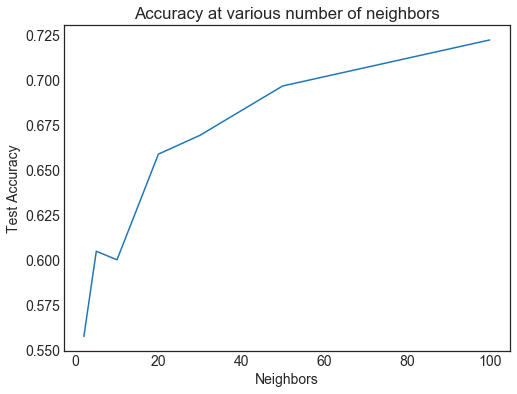

In [476]:
f, ax = plt.subplots(figsize=(8, 6))

plt.plot(accu_b['neigh'], accu_b['score'])
ax.set_title('Accuracy at various number of neighbors')
ax.set_xlabel('Neighbors')
ax.set_ylabel('Test Accuracy');


---

## Support Vector Machine

Below we do a gridsearch to optimize the hyperparameters of a Support Vector Machine classifier. We solve for C, gamma and the kernel to use.

In [41]:
vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords_all)

pipeline_svm = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', SVC())
])

kernel = ['linear',  'rbf']
C = np.logspace(-2, 2, 5)
gamma = np.logspace(-4, 1, 5)

param_grid = {'classify__kernel': kernel,
              'classify__C': C,
              'classify__gamma': gamma}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_svm, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [42]:
scores_svm = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=r

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  4.5min


[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear, accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.7307958477508651, f1=0.6666666666666666, total= 1.3min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=10.0, classify__kernel=linear, accuracy=0.6198830409356725, precision=0.5882352941176471, recall=0.813953488372093, roc_auc=0.7105335157318742, f1=0.6829268292682927, total= 1.2min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=1.0, classify__gamma=0.0001, classify__kernel=rbf, accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.7321799307958476, f1=0.6666666666666666, total= 1.2min
[CV] classify__C=1.0, classify__gamma=0.5623413251903491, classify__kernel=linear 
[CV]  classify__C=0.1, classify__gamma=10.0, classify__kernel=linear, accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.7307958477508651, f1=0.6666666666666666, total= 1

[Parallel(n_jobs=-1)]: Done 141 out of 150 | elapsed:  9.8min remaining:   37.5s


[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.6549707602339181, precision=0.6216216216216216, recall=0.8023255813953488, roc_auc=0.73406292749658, f1=0.700507614213198, total=  60.0s
[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.711764705882353, precision=0.6764705882352942, recall=0.8117647058823529, roc_auc=0.746712802768166, f1=0.7379679144385027, total=  53.2s
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.6608187134502924, precision=0.6707317073170732, recall=0.6395348837209303, roc_auc=0.7212038303693571, f1=0.6547619047619049, total=  37.0s
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.7176470588235294, precision=0.7032967032967034, recall=0.7529411764705882, roc_auc=0.7457439446366783, f1=0.7272727272727272, total=  35.5s
[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.1min finished


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=r

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.7min


[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7599357687675632, f1=0.6928104575163399, total=  44.5s
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear 
[CV]  classify__C=0.1, classify__gamma=10.0, classify__kernel=linear, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.8699317543155359, f1=0.6928104575163399, total=  41.1s
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.8305901244480128, f1=0.6928104575163399, total=  40.9s
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.8643115214773184, f1=0.6928104575163399, total=  45.2s
[CV] clas

[Parallel(n_jobs=-1)]: Done 141 out of 150 | elapsed:  6.2min remaining:   23.7s


[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.79, precision=0.7666666666666667, recall=0.8679245283018868, roc_auc=0.857888398233641, f1=0.8141592920353983, total=  35.2s
[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.72, precision=0.676056338028169, recall=0.9056603773584906, roc_auc=0.8169409875551987, f1=0.7741935483870968, total=  28.4s
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.78, precision=0.7719298245614035, recall=0.8301886792452831, roc_auc=0.851063829787234, f1=0.8, total=  25.5s
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.69, precision=0.6617647058823529, recall=0.8490566037735849, roc_auc=0.7880369329586513, f1=0.7438016528925621, total=  23.8s
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.71, precision=0.6714285714285714, recall=0.8867924528301887, roc_auc=0.812123

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.4min finished


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=r

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  9.9min


[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear, accuracy=0.5030120481927711, precision=0.5030120481927711, recall=1.0, roc_auc=0.8761023407729995, f1=0.6693386773547094, total= 2.9min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear 
[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.5030120481927711, precision=0.5030120481927711, recall=1.0, roc_auc=0.8599891126837235, f1=0.6693386773547094, total= 2.9min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear, accuracy=0.503030303030303, precision=0.503030303030303, recall=1.0, roc_auc=0.8378269174258008, f1=0.6693548387096775, total= 2.9min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.5030303

[Parallel(n_jobs=-1)]: Done 141 out of 150 | elapsed: 22.1min remaining:  1.4min


[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.7951807228915663, precision=0.7538461538461538, recall=0.8802395209580839, roc_auc=0.8929776810016331, f1=0.8121546961325967, total= 2.5min
[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.8132530120481928, precision=0.766497461928934, recall=0.9041916167664671, roc_auc=0.9082562148430413, f1=0.8296703296703296, total= 2.5min
[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.7696969696969697, precision=0.725, recall=0.8734939759036144, roc_auc=0.8797751983543932, f1=0.7923497267759564, total= 1.6min
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=rbf, accuracy=0.5060240963855421, precision=0.5045317220543807, recall=1.0, roc_auc=0.8516784612592997, f1=0.6706827309236948, total= 1.3min
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.8102409638554217, precis

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.8min finished


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0001, classify__kernel=rbf ..
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=rbf 
[CV] classify__C=0.01, classify__gamma=0.0017782794100389228, classify__kernel=r

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/

[CV]  classify__C=0.01, classify__gamma=0.03162277660168379, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353910698231946, f1=0.0, total= 2.0min
[CV] classify__C=0.01, classify__gamma=10.0, classify__kernel=linear .
[CV]  classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.1min
[CV] classify__C=0.01, classify__gamma=10.0, classify__kernel=linear .
[CV]  classify__C=0.01, classify__gamma=0.0001, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353910698231946, f1=0.0, total= 2.1min
[CV] classify__C=0.01, classify__gamma=10.0, classify__kernel=linear .
[CV]  classify__C=0.01, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7291212061098988, f1=0.0, total= 2.1min
[CV] classify__C=0.01, classify__gamma=10.0, classify__kernel=rb

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/

[CV]  classify__C=0.1, classify__gamma=0.0017782794100389228, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.2min
[CV] classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear 
[CV]  classify__C=0.01, classify__gamma=10.0, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.3min
[CV] classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear 
[CV]  classify__C=0.01, classify__gamma=10.0, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7303466187194086, f1=0.0, total= 2.3min
[CV] classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear 
[CV]  classify__C=0.01, classify__gamma=10.0, classify__kernel=linear, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7311049394961316, f1=0.0, total= 2.3min
[CV] classify__C=0.1, classify__gamma=0.56234

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/

[CV]  classify__C=1.0, classify__gamma=0.0001, classify__kernel=linear, accuracy=0.6890459363957597, precision=0.6709677419354839, recall=0.7375886524822695, roc_auc=0.7820397562681051, f1=0.7027027027027026, total= 2.2min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear 
[CV]  classify__C=0.1, classify__gamma=10.0, classify__kernel=linear, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7308073794881969, f1=0.0, total= 2.3min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear 


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  8.2min


[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.3min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=linear, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7308073794881969, f1=0.0, total= 2.4min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=10.0, classify__kernel=linear, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.3min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=10.0, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7715512935770652, f1=0.0, total= 2.3min
[CV] classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf 
[CV]  classify__C=0.1, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7291212061098988, f1=0.0, total= 2.4min
[CV] classify__C=1.0, classify__gamma=0.5623413251903491, cla

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=1.0, classify__gamma=0.0001, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353910698231946, f1=0.0, total= 2.4min
[CV] classify__C=10.0, classify__gamma=0.0001, classify__kernel=linear 
[CV]  classify__C=1.0, classify__gamma=0.0017782794100389228, classify__kernel=rbf, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7311049394961316, f1=0.0, total= 2.4min
[CV] classify__C=10.0, classify__gamma=0.0001, classify__kernel=linear 
[CV]  classify__C=1.0, classify__gamma=0.0017782794100389228, classify__kernel=linear, accuracy=0.6749116607773852, precision=0.6540880503144654, recall=0.7375886524822695, roc_auc=0.7600139846169214, f1=0.6933333333333332, total= 2.5min
[CV] classify__C=10.0, classify__gamma=0.0001, classify__kernel=rbf ..
[CV]  classify__C=1.0, classify__gamma=0.0017782794100389228, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.4min
[CV] cl

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/

[CV]  classify__C=1.0, classify__gamma=0.0017782794100389228, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353411247627609, f1=0.0, total= 1.9min
[CV] classify__C=10.0, classify__gamma=0.0001, classify__kernel=rbf ..


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python

[CV]  classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.735141344521027, f1=0.0, total= 2.3min
[CV] classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV]  classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear, accuracy=0.7007042253521126, precision=0.708029197080292, recall=0.6830985915492958, roc_auc=0.7699861138662965, f1=0.6953405017921146, total= 2.3min
[CV] classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV]  classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=linear, accuracy=0.6890459363957597, precision=0.6709677419354839, recall=0.7375886524822695, roc_auc=0.7820397562681051, f1=0.7027027027027026, total= 2.3min
[CV] classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=linear 
[CV]  classify__C=1.0, classify__gamma=0.03162277660168379, classify__kernel=rbf,

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/py

[CV]  classify__C=10.0, classify__gamma=0.0001, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353910698231946, f1=0.0, total= 2.3min
[CV] classify__C=10.0, classify__gamma=10.0, classify__kernel=rbf ....


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7486764558985116, f1=0.0, total= 2.3min
[CV] classify__C=100.0, classify__gamma=0.0001, classify__kernel=linear 
[CV]  classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=linear, accuracy=0.704225352112676, precision=0.7338709677419355, recall=0.6408450704225352, roc_auc=0.7781690140845071, f1=0.6842105263157895, total= 2.4min
[CV] classify__C=100.0, classify__gamma=0.0001, classify__kernel=linear 
[CV]  classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=linear, accuracy=0.7067137809187279, precision=0.6933333333333334, recall=0.7375886524822695, roc_auc=0.7790430526420936, f1=0.7147766323024054, total= 2.3min
[CV] classify__C=100.0, classify__gamma=0.0001, classify__kernel=linear 
[CV]  classify__C=10.0, classify__gamma=0.0017782794100389228, classify__kernel=linear, accuracy=0.68904593639575

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/py

[CV]  classify__C=100.0, classify__gamma=0.0001, classify__kernel=linear, accuracy=0.7067137809187279, precision=0.6933333333333334, recall=0.7375886524822695, roc_auc=0.7790430526420936, f1=0.7147766323024054, total= 2.2min
[CV] classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf 
[CV]  classify__C=10.0, classify__gamma=10.0, classify__kernel=rbf, accuracy=0.519434628975265, precision=0.7272727272727273, recall=0.05673758865248227, roc_auc=0.7304964539007093, f1=0.10526315789473685, total= 2.5min
[CV] classify__C=100.0, classify__gamma=10.0, classify__kernel=linear 
[CV]  classify__C=100.0, classify__gamma=0.0001, classify__kernel=rbf, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7309065661575085, f1=0.0, total= 2.3min
[CV] classify__C=100.0, classify__gamma=10.0, classify__kernel=linear 
[CV]  classify__C=100.0, classify__gamma=0.0001, classify__kernel=rbf, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.7353910698231946, f1=0.0, total=

[Parallel(n_jobs=-1)]: Done 141 out of 150 | elapsed: 18.2min remaining:  1.2min


[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.7077464788732394, precision=0.7218045112781954, recall=0.676056338028169, roc_auc=0.7754909740130927, f1=0.6981818181818181, total= 1.8min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=100.0, classify__gamma=0.5623413251903491, classify__kernel=rbf, accuracy=0.6855123674911661, precision=0.6547619047619048, recall=0.7801418439716312, roc_auc=0.7816901408450704, f1=0.7119741100323626, total= 1.8min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.6890459363957597, precision=0.6687898089171974, recall=0.7446808510638298, roc_auc=0.7703526121266606, f1=0.7046979865771812, total= 1.0min
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=rbf, accuracy=0.519434628975265, precision=0.7272727272727273, recall=0.05673758865248227, roc_auc=0.7304964539007093, f1=0.10526315789473685, total= 1.0min
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.7067137809187279, precision=0.6933333333333334, recall=0.7375886524822695, roc_auc=0.7790430526420936, f1=0.7147766323024054, total= 1.1min
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=rbf, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7018944653838524, f1=0.0, total= 1.1min
[CV]  classify__C=100.0, classify__gamma=10.0, classify__kernel=linear, accuracy=0.704225352112676, precision=0.7338709677419355, recall=0.6408450704225352, roc_auc=0.778169

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.5min finished


In [43]:
save_obj(scores_svm, 'scores_svm')


In [477]:
scores_svm = load_obj('scores_svm')

print('Mind test F1 score:', scores_svm['mind_f1_test'])
print('Energy test F1 score:', scores_svm['energy_f1_test'])
print('Nature test F1 score:', scores_svm['nature_f1_test'])
print('Tactics test F1 score:', scores_svm['tactics_f1_test'])


Mind test F1 score: 0.7069729974777441
Energy test F1 score: 0.8366745912549558
Nature test F1 score: 0.8499566305453072
Tactics test F1 score: 0.7364014198676998


---

## Linear Discriminant Analysis

Below we do a gridsearch to optimize the hyperparameters of a Linear Discriminant Analysis. We solve for the number of components to be included in the value decomposition.

In [44]:
vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords_all)

pipeline_lda = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', LinearDiscriminantAnalysis())
])

solver = ['svd', 'lsqr']
n_components = [2, 50, 100, 500, None]

param_grid = {'classify__solver': solver,
              'classify__n_components': n_components}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_lda, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [45]:
scores_lda = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=100, classify__solver=svd ................
[CV] classify__n

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are

[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.403044982698962, f1=0.0, total= 1.1min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.4, precision=0.3111111111111111, recall=0.16470588235294117, roc_auc=0.3619377162629758, f1=0.2153846153846154, total= 1.1min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.5029239766081871, precision=0.5029940119760479, recall=0.9767441860465116, roc_auc=0.3436388508891929, f1=0.6640316205533596, total= 1.1min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.5146198830409356, precision=0.512396694214876, recall=0.7209302325581395, roc_auc=0.5541723666210671, f1=0.5990338164251207, total= 1.1min
[CV] classify__n_components=None, clas

[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  1.4min remaining:  4.5min


[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.4, precision=0.3111111111111111, recall=0.16470588235294117, roc_auc=0.3619377162629758, f1=0.2153846153846154, total= 1.1min
[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.5029239766081871, precision=0.5029940119760479, recall=0.9767441860465116, roc_auc=0.3436388508891929, f1=0.6640316205533596, total= 1.1min
[CV]  classify__n_components=100, classify__solver=svd, accuracy=0.5588235294117647, precision=0.5373134328358209, recall=0.8470588235294118, roc_auc=0.6067820069204152, f1=0.6575342465753425, total= 1.1min
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.403044982698962, f1=0.0, total= 1.1min
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.5588235294117647, precision=0.5373134328358209, recall=0.8470588235294118, roc_auc=0.6067820069204152, f1=0.6575342465753425, total= 1.1min
[CV]  classify__n_components=100, classif

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.4min remaining:  1.4min


[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.4, precision=0.3111111111111111, recall=0.16470588235294117, roc_auc=0.3619377162629758, f1=0.2153846153846154, total= 1.1min
[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.5146198830409356, precision=0.512396694214876, recall=0.7209302325581395, roc_auc=0.5541723666210671, f1=0.5990338164251207, total= 1.1min
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.5146198830409356, precision=0.512396694214876, recall=0.7209302325581395, roc_auc=0.5541723666210671, f1=0.5990338164251207, total= 1.1min
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.5029239766081871, precision=0.5029940119760479, recall=0.9767441860465116, roc_auc=0.3436388508891929, f1=0.6640316205533596, total= 1.1min
[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.403044982698962, f1=0.0, total= 1.1min
[CV]  classify__n_components=2, classify_

[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.5min remaining:   27.2s


[CV]  classify__n_components=100, classify__solver=svd, accuracy=0.5882352941176471, precision=0.5619834710743802, recall=0.8, roc_auc=0.6499653979238753, f1=0.6601941747572815, total= 1.2min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, 

[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.6352941176470588, precision=0.5934959349593496, recall=0.8588235294117647, roc_auc=0.6804152249134948, f1=0.7019230769230769, total=  25.4s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7413148788927336, f1=0.0, total=  25.4s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.49122807017543857, precision=0.3333333333333333, recall=0.011627906976744186, roc_auc=0.5363885088919289, f1=0.02247191011235955, total=  27.9s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.5882352941176471, precision=0.5619834710743802, recall=0.8, roc_auc=0.6499653979238753, f1=0.6601941747572815, total=  27.2s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.5588235294117647, precision=0.5373134328358209, recall=0.8470588235294118, roc_auc=0.6067820069204152, f1=0.6575342465753425, total=  27.4s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.5146198830409356, precision=0.512396694214876, recall=0.7209302325581395, roc_auc=0.5541723666210671, f1=0.5990338164251207, total=  28.2s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=100, classify__solver=svd ................
[CV] classify__n

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are

[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7093536732236051, f1=0.6928104575163399, total=  37.2s
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.55, precision=0.5416666666666666, recall=0.9811320754716981, roc_auc=0.5054195102368527, f1=0.697986577181208, total=  37.5s
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.55, precision=0.5416666666666666, recall=0.9811320754716981, roc_auc=0.5054195102368527, f1=0.697986577181208, total=  39.9s
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.6748293857888398, f1=0.6928104575163399, total=  40.8s
[CV] classify__n_components=None, classify__solver=lsqr ..............
[CV]  clas

[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   52.2s remaining:  2.9min


[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.71, precision=0.6621621621621622, recall=0.9245283018867925, roc_auc=0.811722199919711, f1=0.7716535433070866, total=  40.1s
[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.64, precision=0.6, recall=0.9622641509433962, roc_auc=0.7928542753914091, f1=0.7391304347826086, total=  39.8s
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.64, precision=0.6, recall=0.9622641509433962, roc_auc=0.7928542753914091, f1=0.7391304347826086, total=  40.5s
[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.71, precision=0.6621621621621622, recall=0.9245283018867925, roc_auc=0.811722199919711, f1=0.7716535433070866, total=  41.2s
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.6748293857888398, f1=0.6928104575163399, total=  39.6s
[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.64, precision=0.6, recall=0.

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   53.6s remaining:   53.6s


[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.3873946206342834, f1=0.6928104575163399, total=  41.5s
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.3873946206342834, f1=0.6928104575163399, total=  42.1s
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7093536732236051, f1=0.6928104575163399, total=  41.7s
[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.71, precision=0.6621621621621622, recall=0.9245283018867925, roc_auc=0.811722199919711, f1=0.7716535433070866, total=  41.8s
[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.3873946206342834, f1=0.6928104575163399, total=  41.7s
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.55, precision=0.5416666666666666, recall=0.9811320754716981, roc_auc=0.5054195102368

[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   56.8s remaining:   17.3s


[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.6748293857888398, f1=0.6928104575163399, total=  43.4s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.6748293857888398, f1=0.6928104575163399, total=  17.4s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.55, precision=0.5416666666666666, recall=0.9811320754716981, roc_auc=0.5054195102368527, f1=0.697986577181208, total=  16.8s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.71, precision=0.6621621621621622, recall=0.9245283018867925, roc_auc=0.811722199919711, f1=0.7716535433070866, total=  16.2s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7093536732236051, f1=0.6928104575163399, total=  17.3s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.31834604576475306, f1=0.6928104575163399, total=  17.3s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.60497

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=100, classify__solver=svd ................
[CV] classify__n

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are

[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.45454545454545453, precision=0.45, recall=0.3795180722891566, roc_auc=0.4366000587716721, f1=0.4117647058823529, total= 2.7min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.503030303030303, precision=0.503030303030303, recall=1.0, roc_auc=0.8423082574199235, f1=0.6693548387096775, total= 2.7min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.7921686746987951, precision=0.7916666666666666, recall=0.7964071856287425, roc_auc=0.8574487388858646, f1=0.7940298507462688, total= 2.8min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.6957831325301205, precision=0.6701030927835051, recall=0.7784431137724551, roc_auc=0.7757212847033207, f1=0.7202216066481995, tot

[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  3.4min remaining: 11.0min


[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.49698795180722893, precision=0.0, recall=0.0, roc_auc=0.23712574850299403, f1=0.0, total= 2.7min
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.49698795180722893, precision=0.0, recall=0.0, roc_auc=0.23712574850299403, f1=0.0, total= 2.7min
[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.7921686746987951, precision=0.7916666666666666, recall=0.7964071856287425, roc_auc=0.8574487388858646, f1=0.7940298507462688, total= 2.8min
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.5878787878787879, precision=0.5652173913043478, recall=0.7831325301204819, roc_auc=0.6488025271818983, f1=0.6565656565656566, total= 2.8min
[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.49698795180722893, precision=0.0, recall=0.0, roc_auc=0.23712574850299403, f1=0.0, total= 2.8min
[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.6957831325301205, precision=0.6

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  3.4min remaining:  3.4min


[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.7921686746987951, precision=0.7916666666666666, recall=0.7964071856287425, roc_auc=0.8574487388858646, f1=0.7940298507462688, total= 2.8min
[CV]  classify__n_components=100, classify__solver=svd, accuracy=0.6957831325301205, precision=0.6701030927835051, recall=0.7784431137724551, roc_auc=0.7757212847033207, f1=0.7202216066481995, total= 2.8min
[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.6686746987951807, precision=0.6255506607929515, recall=0.8502994011976048, roc_auc=0.7244057339865723, f1=0.7208121827411167, total= 2.8min
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.6686746987951807, precision=0.6255506607929515, recall=0.8502994011976048, roc_auc=0.7244057339865723, f1=0.7208121827411167, total= 2.8min
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.6686746987951807, precision=0.6255506607929515, recall=0.8502994011976048, roc_auc=0.7244057339865723, f1=0

[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.4min remaining:  1.0min


[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.49698795180722893, precision=0.0, recall=0.0, roc_auc=0.23712574850299403, f1=0.0, total= 2.9min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, 

[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.6957831325301205, precision=0.6701030927835051, recall=0.7784431137724551, roc_auc=0.7757212847033207, f1=0.7202216066481995, total=  57.4s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.5878787878787879, precision=0.5652173913043478, recall=0.7831325301204819, roc_auc=0.6488025271818983, f1=0.6565656565656566, total=  56.8s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.6686746987951807, precision=0.6255506607929515, recall=0.8502994011976048, roc_auc=0.7244057339865723, f1=0.7208121827411167, total=  57.8s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.49698795180722893, precision=0.0, recall=0.0, roc_auc=0.13376882598439482, f1=0.0, total=  55.7s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.46060606060606063, precision=0.3235294117647059, recall=0.06626506024096386, roc_auc=0.3751101968851014, f1=0.11000000000000001, total=  57.6s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.5030120481927711, precision=1.0, recall=0.011976047904191617, roc_auc=0.7848666303756123, f1=0.023668639053254437, total=  58.3s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.6min finished
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=svd ..................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=2, classify__solver=lsqr .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=svd .................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=50, classify__solver=lsqr ................
[CV] classify__n_components=100, classify__solver=svd ................
[CV] classify__n

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are

[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.47703180212014135, precision=0.45454545454545453, recall=0.24822695035460993, roc_auc=0.5277694536010389, f1=0.3211009174311927, total= 2.1min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=2, classify__solver=svd, accuracy=0.5017667844522968, precision=0.5, recall=0.7021276595744681, roc_auc=0.5575866546798521, f1=0.584070796460177, total= 2.1min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.5598591549295775, precision=0.5602836879432624, recall=0.5563380281690141, roc_auc=0.5742908153144218, f1=0.5583038869257951, total= 2.2min
[CV] classify__n_components=None, classify__solver=svd ...............
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.5017667844522968, precision=0.0, recall=0.0, roc_auc=0.5181300569373689, f1=0.0, total= 2.2min
[CV] classify__n_com

[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  2.7min remaining:  8.8min


[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.4911660777385159, precision=0.49466192170818507, recall=0.9858156028368794, roc_auc=0.43527120167815403, f1=0.6587677725118484, total= 2.2min
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.47703180212014135, precision=0.45454545454545453, recall=0.24822695035460993, roc_auc=0.5277694536010389, f1=0.3211009174311927, total= 2.2min
[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.5759717314487632, precision=0.5418326693227091, recall=0.9645390070921985, roc_auc=0.7507242033762861, f1=0.693877551020408, total= 2.2min
[CV]  classify__n_components=500, classify__solver=lsqr, accuracy=0.5211267605633803, precision=0.8, recall=0.056338028169014086, roc_auc=0.7127058123388217, f1=0.10526315789473684, total= 2.2min
[CV]  classify__n_components=100, classify__solver=svd, accuracy=0.5017667844522968, precision=0.5, recall=0.7021276595744681, roc_auc=0.5575866546798521, f1=0.584070796460177, tot

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.7min remaining:  2.7min


[CV]  classify__n_components=50, classify__solver=lsqr, accuracy=0.5211267605633803, precision=0.8, recall=0.056338028169014086, roc_auc=0.7127058123388217, f1=0.10526315789473684, total= 2.2min
[CV]  classify__n_components=100, classify__solver=lsqr, accuracy=0.5759717314487632, precision=0.5418326693227091, recall=0.9645390070921985, roc_auc=0.7507242033762861, f1=0.693877551020408, total= 2.2min
[CV]  classify__n_components=2, classify__solver=lsqr, accuracy=0.5211267605633803, precision=0.8, recall=0.056338028169014086, roc_auc=0.7127058123388217, f1=0.10526315789473684, total= 2.2min
[CV]  classify__n_components=50, classify__solver=svd, accuracy=0.5598591549295775, precision=0.5602836879432624, recall=0.5563380281690141, roc_auc=0.5742908153144218, f1=0.5583038869257951, total= 2.2min
[CV]  classify__n_components=500, classify__solver=svd, accuracy=0.5017667844522968, precision=0.5, recall=0.7021276595744681, roc_auc=0.5575866546798521, f1=0.584070796460177, total= 2.2min
[CV]  c

[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  2.7min remaining:   50.1s


[CV]  classify__n_components=100, classify__solver=svd, accuracy=0.47703180212014135, precision=0.45454545454545453, recall=0.24822695035460993, roc_auc=0.5277694536010389, f1=0.3211009174311927, total= 2.3min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.5017667844522968, precision=0.5, recall=0.7021276595744681, roc_auc=0.5575866546798521, f1=0.584070796460177, total=  51.0s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.5598591549295775, precision=0.5602836879432624, recall=0.5563380281690141, roc_auc=0.5742908153144218, f1=0.5583038869257951, total=  51.8s


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.508833922261484, precision=1.0, recall=0.014184397163120567, roc_auc=0.5181300569373689, f1=0.027972027972027972, total=  49.2s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.31448763250883394, precision=0.29133858267716534, recall=0.2624113475177305, roc_auc=0.23314354210368593, f1=0.27611940298507465, total=  48.8s
[CV]  classify__n_components=None, classify__solver=lsqr, accuracy=0.4964788732394366, precision=0.49823321554770317, recall=0.9929577464788732, roc_auc=0.34035905574290815, f1=0.6635294117647058, total=  49.7s
[CV]  classify__n_components=None, classify__solver=svd, accuracy=0.47703180212014135, precision=0.45454545454545453, recall=0.24822695035460993, roc_auc=0.5277694536010389, f1=0.3211009174311927, total=  50.9s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.7min finished


In [46]:
save_obj(scores_lda, 'scores_lda')


In [478]:
scores_lda = load_obj('scores_lda')

print('Mind test F1 score:', scores_lda['mind_f1_test'])
print('Energy test F1 score:', scores_lda['energy_f1_test'])
print('Nature test F1 score:', scores_lda['nature_f1_test'])
print('Tactics test F1 score:', scores_lda['tactics_f1_test'])


Mind test F1 score: 0.6908637494647891
Energy test F1 score: 0.36586840832123857
Nature test F1 score: 0.8354016803864827
Tactics test F1 score: 0.7363526211655554


---

## Neural Network

Below we do a gridsearch to optimize the hyperparameters of a Neural Network classifier. We solve for the number and size of the neuronal layers, the alpha, and the activation function to use.

In [47]:
vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords_all)

pipeline_nn = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', MLPClassifier(max_iter=2000))
])

layers = [(1000,), (500,), (100, ), (50, )]
alpha = np.logspace(-6, 0, 7)
activation = ['logistic', 'relu']

param_grid = {'classify__hidden_layer_sizes': layers,
              'classify__alpha': alpha,
              'classify__activation': activation}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_nn, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [48]:
scores_nn = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hi

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 10.9min


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(1000,), accuracy=0.6432748538011696, precision=0.6237623762376238, recall=0.7325581395348837, roc_auc=0.723939808481532, f1=0.6737967914438502, total= 2.6min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(50,), accuracy=0.7176470588235294, precision=0.6989247311827957, recall=0.7647058823529411, roc_auc=0.7403460207612456, f1=0.7303370786516853, total= 2.8min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(100,), accuracy=0.6588235294117647, precision=0.6483516483516484, recall=0.6941176470588235, roc_auc=0.7240138408304498, f1=0.6704545454545454, total= 3.2min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidde

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.7294117647058823, precision=0.7096774193548387, recall=0.7764705882352941, roc_auc=0.7469896193771626, f1=0.7415730337078652, total= 4.9min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.6783625730994152, precision=0.6823529411764706, recall=0.6744186046511628, roc_auc=0.731326949384405, f1=0.6783625730994152, total= 5.0min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,), accuracy=0.6666666666666666, precision=0.6526315789473685, recall=0.7209302325581395, roc_auc=0.7317373461012311, f1=0.6850828729281767, total= 4.2min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.6647058823529411, precision=0.6555555555555556, recall=0.6941176470588235, roc_auc=0.7276124567474048, f1=0.6742857142857143, total= 4.9min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_lay

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,), accuracy=0.7235294117647059, precision=0.7065217391304348, recall=0.7647058823529411, roc_auc=0.7486505190311419, f1=0.7344632768361581, total= 4.5min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(50,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,), accuracy=0.6705882352941176, precision=0.6593406593406593, recall=0.7058823529411765, roc_auc=0.728719723183391, f1=0.6818181818181818, total= 4.9min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(50,) 
[CV]  classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,), accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.7285813148788927, f1=0.6666666666666666, total= 1.1min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(50,) 
[CV]  classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,), accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.7276124567474048, f1=0.6666666666666666, total= 1.2min
[CV] classify__activation=relu, classify__alpha=1e-05, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=1.0, classify__hidden_la

[Parallel(n_jobs=-1)]: Done 164 out of 168 | elapsed: 21.0min remaining:   30.7s


[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,), accuracy=0.7294117647058823, precision=0.7052631578947368, recall=0.788235294117647, roc_auc=0.7478200692041522, f1=0.7444444444444445, total= 1.5min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.6842105263157895, precision=0.6904761904761905, recall=0.6744186046511628, roc_auc=0.7350205198358413, f1=0.6823529411764705, total= 1.1min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.7235294117647059, precision=0.6979166666666666, recall=0.788235294117647, roc_auc=0.7472664359861592, f1=0.7403314917127071, total= 1.0min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.6705882352941176, precision=0.6593406593406593, recall=0.7058823529411765, roc_auc=0.7323183391003459, f1=0.6818181818181818, total=  58.4s


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed: 21.1min finished


Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hi

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.0001, classify__hidden_layer_sizes=(1000,), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.692894419911682, f1=0.6928104575163399, total=  50.5s
[CV] classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(1000,), accuracy=0.62, precision=0.5949367088607594, recall=0.8867924528301887, roc_auc=0.6587715776796467, f1=0.7121212121212119, total= 1.0min
[CV] classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.0001, classify__hidden_layer_sizes=(500,), accuracy=0.47, precision=0.0, recall=0.0, roc_auc=0.6824568446407066, f1=0.0, total=  59.2s
[CV] classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_laye

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(500,), accuracy=0.68, precision=0.647887323943662, recall=0.8679245283018868, roc_auc=0.7551184263348053, f1=0.7419354838709677, total= 1.5min
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(500,), accuracy=0.7, precision=0.6825396825396826, recall=0.8113207547169812, roc_auc=0.7695704536330792, f1=0.7413793103448275, total= 1.5min
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.0001, classify__hidden_layer_sizes=(1000,), accuracy=0.67, precision=0.6612903225806451, recall=0.7735849056603774, roc_auc=0.7739863508631072, f1=0.7130434782608696, total= 1.7min
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,) 
[CV]  classify__

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(50,), accuracy=0.69, precision=0.6774193548387096, recall=0.7924528301886793, roc_auc=0.7603372139702931, f1=0.7304347826086955, total= 1.2min
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(50,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7599357687675634, f1=0.6928104575163399, total=  40.9s
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(500,), accuracy=0.47, precision=0.0, recall=0.0, roc_auc=0.7430750702529105, f1=0.0, total=  37.2s
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  5.1min


[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(500,), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7021276595744681, f1=0.6928104575163399, total=  47.9s
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.76756322761943, f1=0.6928104575163399, total=  50.8s
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(500,), accuracy=0.53, precision=0.53, recall=1.0, roc_auc=0.7555198715375352, f1=0.6928104575163399, total=  58.5s
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(100,), accuracy=0

[Parallel(n_jobs=-1)]: Done 164 out of 168 | elapsed: 11.7min remaining:   17.1s


[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.72, precision=0.676056338028169, recall=0.9056603773584906, roc_auc=0.816539542352469, f1=0.7741935483870968, total=  47.2s
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.69, precision=0.6571428571428571, recall=0.8679245283018868, roc_auc=0.7771979124849459, f1=0.7479674796747967, total=  47.0s


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed: 11.7min finished


Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hi

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(1000,), accuracy=0.5030120481927711, precision=0.5030120481927711, recall=1.0, roc_auc=0.8618036653964797, f1=0.6693386773547094, total= 5.0min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(100,), accuracy=0.8313253012048193, precision=0.8284023668639053, recall=0.8383233532934131, roc_auc=0.8904373072037743, f1=0.8333333333333334, total= 6.1min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 25.2min


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(1000,), accuracy=0.49696969696969695, precision=0.0, recall=0.0, roc_auc=0.8576256244490155, f1=0.0, total= 5.1min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(100,), accuracy=0.6626506024096386, precision=0.9365079365079365, recall=0.3532934131736527, roc_auc=0.88198149156233, f1=0.5130434782608696, total= 4.7min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(100,), accuracy=0.8102409638554217, precision=0.7888888888888889, recall=0.8502994011976048, roc_auc=0.9059698784249681, f1=0.8184438040345821, total= 6.0min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activat

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(500,), accuracy=0.796969696969697, precision=0.776536312849162, recall=0.8373493975903614, roc_auc=0.8802527181898324, f1=0.8057971014492754, total= 9.2min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(50,), accuracy=0.8283132530120482, precision=0.8197674418604651, recall=0.844311377245509, roc_auc=0.8905461803665397, f1=0.831858407079646, total= 5.2min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(50,), accuracy=0.806060606060606, precision=0.7931034482758621, recall=0.8313253012048193, roc_auc=0.8787834263884807, f1=0.8117647058823529, total= 5.2min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.796969696969697, precision=0.776536312849162, recall=0.8373493975903614, roc_auc=0.8805833088451366, f1=0.8057971014492754, total=10.8min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(50,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(1000,), accuracy=0.8313253012048193, precision=0.8284023668639053, recall=0.8383233532934131, roc_auc=0.8918526583197243, f1=0.8333333333333334, total=11.5min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(50,) 
[CV]  classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,), accuracy=0.5030120481927711, precision=0.5030120481927711, recall=1.0, roc_auc=0.8510978043912175, f1=0.6693386773547094, total= 2.9min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(50,) 
[C

[Parallel(n_jobs=-1)]: Done 164 out of 168 | elapsed: 48.0min remaining:  1.2min


[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(100,), accuracy=0.8162650602409639, precision=0.8045977011494253, recall=0.8383233532934131, roc_auc=0.9069134458356015, f1=0.8211143695014662, total= 2.6min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,), accuracy=0.7848484848484848, precision=0.7567567567567568, recall=0.8433734939759037, roc_auc=0.8760285042609461, f1=0.7977207977207977, total= 3.0min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,), accuracy=0.8283132530120482, precision=0.8235294117647058, recall=0.8383233532934131, roc_auc=0.8890945381963347, f1=0.8308605341246291, total= 3.1min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.803030303030303, precision=0.791907514450867, recall=0.8253012048192772, roc_auc=0.8780487804878048, f1=0.808259587020649, total= 2.4min


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed: 48.1min finished


Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(1000,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV] classify__activation=logistic, classify__alpha=1e-06, classify__hi

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 19.7min


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(1000,), accuracy=0.6408450704225352, precision=0.8448275862068966, recall=0.34507042253521125, roc_auc=0.7543146201150566, f1=0.49, total= 4.9min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(50,), accuracy=0.6819787985865724, precision=0.660377358490566, recall=0.7446808510638298, roc_auc=0.7731495355109379, f1=0.7, total= 5.4min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(50,), accuracy=0.7077464788732394, precision=0.7286821705426356, recall=0.6619718309859155, roc_auc=0.7782682007538186, f1=0.6937269372693726, total= 5.4min
[CV] classify__activation=logistic, classify__alpha=1.0, classify__hidden_layer_sizes=(500,) 
[CV]  c

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.01, classify__hidden_layer_sizes=(500,), accuracy=0.6784452296819788, precision=0.6582278481012658, recall=0.7375886524822695, roc_auc=0.773249425631805, f1=0.6956521739130435, total= 8.0min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(50,), accuracy=0.6819787985865724, precision=0.660377358490566, recall=0.7446808510638298, roc_auc=0.7713515133353311, f1=0.7, total= 5.6min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(500,) 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/pyth

[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,), accuracy=0.6996466431095406, precision=0.6944444444444444, recall=0.7092198581560284, roc_auc=0.7810908001198681, f1=0.7017543859649124, total= 8.9min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,), accuracy=0.6819787985865724, precision=0.656441717791411, recall=0.7588652482269503, roc_auc=0.7718509639396663, f1=0.7039473684210525, total= 8.9min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_sizes=(100,) 
[CV]  classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(500,), accuracy=0.7007042253521126, precision=0.7567567567567568, recall=0.5915492957746479, roc_auc=0.7789129141043444, f1=0.6640316205533597, total= 9.2min
[CV] classify__activation=relu, classify__alpha=1e-06, classify__hidden_layer_s

[Parallel(n_jobs=-1)]: Done 164 out of 168 | elapsed: 38.4min remaining:   56.1s


[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.6819787985865724, precision=0.6624203821656051, recall=0.7375886524822695, roc_auc=0.7807911297572669, f1=0.6979865771812079, total= 2.1min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(1000,), accuracy=0.6784452296819788, precision=0.6644736842105263, recall=0.7163120567375887, roc_auc=0.7702027769453601, f1=0.689419795221843, total= 2.6min
[CV]  classify__activation=relu, classify__alpha=1.0, classify__hidden_layer_sizes=(50,), accuracy=0.6819787985865724, precision=0.6624203821656051, recall=0.7375886524822695, roc_auc=0.7714514034561982, f1=0.6979865771812079, total= 2.0min


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed: 38.5min finished


In [49]:
save_obj(scores_nn, 'scores_nn')


In [479]:
scores_nn = load_obj('scores_nn')

print('Mind test F1 score:', scores_nn['mind_f1_test'])
print('Energy test F1 score:', scores_nn['energy_f1_test'])
print('Nature test F1 score:', scores_nn['nature_f1_test'])
print('Tactics test F1 score:', scores_nn['tactics_f1_test'])


Mind test F1 score: 0.7209074759220108
Energy test F1 score: 0.7977764423076923
Nature test F1 score: 0.8295593712949706
Tactics test F1 score: 0.7549489795918368


---

## Decision tree based

Below we do a gridsearch to optimize the hyperparameters of a decision tree based ensemble approach, random forests. We solve for the number of estimators, the maximum number of features, the selection criterion, whether to bootstrap and the depth of the forest.

In [50]:
vectorizer = TfidfVectorizer(preprocessor=preprocess,
                             stop_words=stopwords_no_pro)

pipeline_rf = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD(n_components=1000)),
    ('classify', RandomForestClassifier())
])

n_estimators = [1, 10, 100, 250, 500, 1000]
max_features = ['auto', 'log2', 'sqrt']
criterion = ["gini", "entropy"]
bootstrap = [True, False]
max_depth = [3, 5, None]

param_grid = {'classify__n_estimators': n_estimators,
              'classify__max_features': max_features,
              'classify__criterion': criterion,
              'classify__bootstrap': bootstrap,
              'classify__max_depth': max_depth}

scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_rf, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)

In [51]:
scores_rnf = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_est

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.5, f1=0.0, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5, precision=0.5, recall=0.9882352941176471, roc_auc=0.5058131487889274, f1=0.6640316205533597, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100, accuracy=0.5029239766081871, precision=1.0, recall=0.011627906976744186, roc_auc=0.612311901504788, f1=0.02298850574712

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/py

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5294117647058824, precision=0.7777777777777778, recall=0.08235294117647059, roc_auc=0.6318339100346021, f1=0.14893617021276592, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5029239766081871, precision=1.0, recall=0.011627906976744186, roc_auc=0.6157318741450069, f1=0.022988505747126436, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5, precisi

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/pyth

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.52046783625731, precision=1.0, recall=0.046511627906976744, roc_auc=0.5232558139534884, f1=0.08888888888888888, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5764705882352941, precision=0.6857142857142857, recall=0.2823529411764706, roc_auc=0.7093425605536332, f1=0.39999999999999997, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  4.4min


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=10, accuracy=0.5470588235294118, precision=0.6176470588235294, recall=0.24705882352941178, roc_auc=0.6111418685121107, f1=0.35294117647058826, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.5235294117647059, precision=0.5238095238095238, recall=0.5176470588235295, roc_auc=0.5180622837370242, f1=0.5207100591715976, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=100, accuracy=0.491

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.49411764705882355, precision=0.4, recall=0.023529411764705882, roc_auc=0.7031141868512111, f1=0.044444444444444446, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/pyth

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5029239766081871, precision=1.0, recall=0.011627906976744186, roc_auc=0.5058139534883721, f1=0.022988505747126436, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5941176470588235, precision=0.6739130434782609, recall=0.36470588235294116, roc_auc=0.677923875432526, f1=0.4732824427480916, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1, accuracy=0.49411764705882

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5529411764705883, precision=0.7647058823529411, recall=0.15294117647058825, roc_auc=0.5854671280276816, f1=0.25490196078431376, total=  51.7s
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5176470588235295, precision=0.7142857142857143, recall=0.058823529411764705, roc_auc=0.5566089965397925, f1=0.10869565217391305, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.49707602339181284, precision=0.5, recall=0.011627906976744186, roc_auc=0.638577291381669, f1=0.022727272727272724, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.61

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.5117647058823529, precision=0.6, recall=0.07058823529411765, roc_auc=0.6326643598615918, f1=0.12631578947368421, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1, accuracy=0.4823529411764706, precision=0.0, recall=0.0, roc_auc=0.4823529411764706, f1=0.0, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5529411764705883, precision=0.68, recall=0.2, roc

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1, accuracy=0.5321637426900585, precision=0.6153846153846154, recall=0.18604651162790697, roc_auc=0.5341997264021887, f1=0.2857142857142857, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6577291381668947, f1=0.0, total= 1.3min
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1, accuracy=0.47058823529411764, precision=0.48322147651006714, recall=0.8470588235294118, roc_auc=0.47058823529411764, f1=0.6153846153846154, total= 1.2min
[CV] classify__bootstrap=True, cl

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6898084815321477, f1=0.0, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/py

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5647058823529412, precision=0.7391304347826086, recall=0.2, roc_auc=0.6913494809688582, f1=0.3148148148148149, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python

[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.49411764705882355, precision=0.0, recall=0.0, roc_auc=0.6145328719723183, f1=0.0, total= 1.4min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.5, f1=0.0, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6856361149110808, f1=0.0, total= 1

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.49411764705882355, precision=0.496551724137931, recall=0.8470588235294118, roc_auc=0.49411764705882355, f1=0.6260869565217392, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5, precision=0.5, recall=0.011764705882352941, roc_auc=0.7017301038062284, f1=0.02298850574712644, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.44117647058823

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.5471956224350205, f1=0.0, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6968536251709986, f1=0.0, total= 1.4min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None,

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5058823529411764, precision=0.5333333333333333, recall=0.09411764705882353, roc_auc=0.6695501730103807, f1=0.16, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.611764705882353, precision=0.7209302325581395, recall=0.36470588235294116, roc_auc=0.7069204152249136, f1=0.484375, total= 1.4min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5, p

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.6730103806228375, f1=0.023255813953488372, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6866621067031464, f1=0.0, total=  58.4s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5321637426900585, precision=0.6071428571428571, recall=0.19767441860465115, roc_auc=0.5352941176470588, f1=0.2982456140350877, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.6176470588235294, precision=0.717391304347826, recall=0.38823529411764707, roc_auc=0.7148788927335641, f1=0.5038167938931297, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5235294117647059, precision=0.75, recall=0.07058823529411765, roc_auc=0.5510034602076124, f1=0.12903225806451613, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5411764705882353, precision=0.5241379310344828, recall=0.8941176470588236, roc_auc=0.5411764705882353, f1=0.6608695652173914, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.4619883040935672, precision=0.45161290322580644, recall=0.32558139534883723, roc_auc=0.46279069767441866, f1=0.3783783783783784, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.5058823529411764, precision=0.5263157894736842, recall=0.11764705882352941, roc_auc=0.5561245674740485, f1=0.1923076923076923, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5294117647058824, precision=1.0, recall=0.058823529411764705, roc_auc=0.7172318339100345, f1=0.1111111111111111, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, accur

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.6, precision=0.7297297297297297, recall=0.3176470588235294, roc_auc=0.7204152249134947, f1=0.4426229508196722, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6914500683994529, f1=0.0, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7250519031141868, f1=0.0, total= 1.4min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1, accuracy=0.5176470588235295, precision=0.5095541401273885, recall=0.9411764705882353, roc_auc=0.5307958477508651, f1=0.6611570247933883, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10, accuracy=0.5614035087719298, precision=0.5514018691588785, recall=0.686046511627907, roc_auc=0.5978112175102599, f1=0.6113989637305699, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1, accuracy=0.5117647058823529, precision=0.75, recall=0.03529411764705882, roc_auc=0.511764705882353, f1=0.06741573033707865, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10, accuracy=0.55

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 13.0min


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6058823529411764, precision=0.725, recall=0.3411764705882353, roc_auc=0.7173702422145328, f1=0.46399999999999997, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5529411764705883, precision=0.6551724137931034, recall=0.2235294117647059, roc_auc=0.6715570934256054, f1=0.33333333333333337, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accurac

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5, precision=0.5, recall=0.011764705882352941, roc_auc=0.5, f1=0.02298850574712644, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.611764705882353, precision=0.7567567567567568, recall=0.32941176470588235, roc_auc=0.7158477508650519, f1=0.45901639344262296, total= 1.5min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5235294117647059, precisi

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5146198830409356, precision=0.512396694214876, recall=0.7209302325581395, roc_auc=0.5059507523939808, f1=0.5990338164251207, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5058823529411764, precision=0.5714285714285714, recall=0.047058823529411764, roc_auc=0.5539792387543252, f1=0.08695652173913043, total=  59.2s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5235294117647059, precision=0.5333333333333333, recall=0.3764705882352941, roc_auc=0.5242906574394464, f1=0.4413793103448276, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5146198830409356, precision=0.8, recall=0.046511627906976744, roc_auc=0.5957592339261286, f1=0.0879120879120879, total=  56.2s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5529411764705883, precision=0.68, recall=0.2, roc_auc=0.6465051903114187, f1=0.3090909090909091, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6361149110807113, f1=0.0, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.7184775086505191, f1=0.023255813953488372, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5352941176470588, precision=0.625, rec

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5705882352941176, precision=0.6764705882352942, recall=0.27058823529411763, roc_auc=0.6894117647058825, f1=0.3865546218487395, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5117647058823529, precision=1.0, recall=0.023529411764705882, roc_auc=0.6824913494809689, f1=0.04597701149425288, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.49411764705882355, precision=0.4970414201183432, recall=0.9882352941176471, roc_auc=0.4406920415224914, f1=0.6614173228346457, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.51

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.6529411764705882, precision=0.7241379310344828, recall=0.49411764705882355, roc_auc=0.7004844290657439, f1=0.5874125874125875, total= 1.5min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=100, accuracy=0.5087719298245614, precision=1.0, recall=0.023255813953488372, roc_auc=0.6411764705882352, f1=0.04545454545454545, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=10, accura

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5058823529411764, precision=0.6, recall=0.03529411764705882, roc_auc=0.7295501730103806, f1=0.06666666666666667, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=250, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6414500683994527, f1=0.0, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5705882352941176, precision=0.6428571428571429, recall=0.3176470588235294, roc_auc=0.702560553633218, f1=0.42519685039370075, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=500, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.7095759233926129, f1=0.0, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.7658131487889273, f1=0.023255813953488372, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.5, f1=0.0, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1, accuracy=0.4823529411764706, precision=0.44, recall=0.12941176470588237, roc_auc=0.48422145328719723, f1=0.19999999999999998, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10, accuracy=0.4764705882352941, precision=0.46153846153846156, recall=0.2823529411764706, roc_auc=0.553356401384083, f1=0.35036496350364965, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000, accuracy=

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5352941176470588, precision=0.65, recall=0.15294117647058825, roc_auc=0.633840830449827, f1=0.24761904761904766, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5117647058823529, precision=0.5116279069767442, recall=0.5176470588235295, roc_auc=0.5160553633217992, f1=0.5146198830409358, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=250 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.743114186851211, f1=0.023255813953488372, total= 1.6min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=100, accuracy=0.49411764705882355, precision=0.3333333333333333, recall=0.011764705882352941, roc_auc=0.6730795847750863, f1=0.022727272727272728, total= 1.1min
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10, accuracy=0.6198830409356725, precision=0.647887323943662, recall=0.5348837209302325, roc_auc=0.6365937072503419, f1=0.5859872611464968, total=

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6418604651162791, f1=0.0, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.49411764705882355, precision=0.0, recall=0.0, roc_auc=0.6621453287197231, f1=0.0, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5705882352941176, precision=0.7307692307692307, recall=0.2235294117647

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5058823529411764, precision=0.5714285714285714, recall=0.047058823529411764, roc_auc=0.557439446366782, f1=0.08695652173913043, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.5235294117647059, precision=0.5909090909090909, recall=0.15294117647058825, roc_auc=0.6801384083044983, f1=0.2429906542056075, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_est

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5029239766081871, precision=1.0, recall=0.011627906976744186, roc_auc=0.6908344733242134, f1=0.022988505747126436, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.5588235294117647, precision=0.75, recall=0.17647058823529413, roc_auc=0.6829065743944637, f1=0.2857142857142857, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.6176470588235294, precision=0.7380952380952381, recall=0.36470588235294116, roc_auc=0.7285813148788928, f1=0.4881889763779527, total= 1.4min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1, accuracy=0.5647058823529412, precision=0.5873015873015873, recall=0.43529411764705883, roc_auc=0.5647058823529412, f1=0.5000000000000001, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estima

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.7087551299589603, f1=0.0, total= 1.6min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=100, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6258549931600547, f1=0.0, total=  55.2s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.7118339100346021, f1=0.023255813953488372, total= 1.5min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=10, accuracy=0.5263157894736842, precision=0.5373134328358209, recall=0.4186046511627907, roc_auc=0.6149794801641586, f1=0.47058823529411764, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimator

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=100, accuracy=0.5176470588235295, precision=1.0, recall=0.03529411764705882, roc_auc=0.6242214532871972, f1=0.06818181818181818, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6790697674418605, f1=0.0, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5823529411764706, precision=0.6296296296296297, recall=0.4, roc_auc=0.6662283737024222, f1=0.4892086330935252, total= 1.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.6588927335640137, f1=0.023255813953488372, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5411764705882353, precision=0.8181818181818182, recall=0.10588235294117647, roc_auc=0.7057439446366782, f1=0.18750000000000003, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.7192886456908345, f1=0.0, total= 1.3min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5847953216374269, precision=0.5789473684210527, recall=0.6395348837209303, roc_auc=0.5844733242134063, f1=0.6077348066298343, total=  59.1s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5058823529411764, precision=0.5052631578947369, recall=0.5647058823529412, roc_auc=0.5058823529411764, f1=0.5333333333333333, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.6726643598615917, f1=0.023255813953488372, total= 1.4min
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5117647058823529, precision=0.6666666666666666, recall=0.047058823529411764, roc_auc=0.6427681660899653, f1=0.08791208791208792, total=  59.0s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimat

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5058823529411764, precision=0.5094339622641509, recall=0.3176470588235294, roc_auc=0.49557093425605536, f1=0.391304347826087, total= 1.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7031141868512111, f1=0.0, total= 1.6min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.49707602339181284, precision

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5294117647058824, precision=0.8571428571428571, recall=0.07058823529411765, roc_auc=0.6678892733564014, f1=0.13043478260869565, total= 1.7min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6559507523939809, f1=0.0, total=  56.9s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5058823529

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.6940484429065744, f1=0.023255813953488372, total= 1.0min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5, precision=0.5, recall=0.011764705882352941, roc_auc=0.7076124567474048, f1=0.02298850574712644, total= 1.0min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6213406292749659, f1=0.0, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.6777854671280277, f1=0.0, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5730994152046783, precision=0.549618320610687, recall=0.8372093023255814, roc_auc=0.571545827633379, f1=0.663594470046083, total=  58.2s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5176470588235295, precision=0.5148514851485149, r

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6688098495212038, f1=0.0, total= 1.3min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5411764705882353, precision=0.6, recall=0.24705882352941178, roc_auc=0.5841522491349481, f1=0.35, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.5087719298245614, precision=1.0, recall=0.023255813

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7008304498269895, f1=0.0, total= 1.5min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.5117647058823529, precision=0.75, recall=0.03529411764705882, roc_auc=0.625121107266436, f1=0.06741573033707865, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5058823529411764, precision=0.6666666666666666, rec

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5529411764705883, precision=0.6956521739130435, recall=0.18823529411764706, roc_auc=0.7088581314878893, f1=0.2962962962962963, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5087719298245614, precision=1.0, recall=0.023255813953488372, roc_auc=0.6948016415868674, f1=0.04545454545454545, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5058823529411764, precision=1.0, recall=0.011764705882352941, roc_auc=0.7012456747404845, f1=0.023255813953488372, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5411764705882353, precision=0.7333333333333333, recall=0.12941176470588237, roc_auc=0.7184775086505191, f1=0.22000000000000003, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, acc

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1, accuracy=0.4823529411764706, precision=0.48484848484848486, recall=0.5647058823529412, roc_auc=0.4791695501730104, f1=0.5217391304347826, total= 1.0min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10, accuracy=0.6294117647058823, precision=0.6222222222222222, recall=0.6588235294117647, roc_auc=0.6782698961937716, f1=0.64, total=  58.6s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.5, pre

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 26.4min


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5882352941176471, precision=0.6923076923076923, recall=0.3176470588235294, roc_auc=0.6758477508650519, f1=0.4354838709677419, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5, precision=0.5, recall=1.0, roc_auc=0.5, f1=0.6666666666666666, total= 1.0min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5647058823529412, precision=0.6170212765957447, recall=0

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5029239766081871, precision=1.0, recall=0.011627906976744186, roc_auc=0.652530779753762, f1=0.022988505747126436, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5176470588235295, precision=1.0, recall=0.03529411764705882, roc_auc=0.6743944636678201, f1=0.06818181818181818, total= 1.4min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.6294117647058823, precision=0.7291666666666666, recall=0.4117647058823529, roc_auc=0.7355017301038062, f1=0.5263157894736842, total= 1.3min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accu

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5058823529411764, precision=0.6666666666666666, recall=0.023529411764705882, roc_auc=0.6824221453287198, f1=0.045454545454545456, total= 1.3min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5029239766081871, precision=0.6, recall=0.03488372093023256, roc_auc=0.5883036935704514, f1=0.06593406593406594, total= 1.0min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accur

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5117647058823529, precision=0.5166666666666667, recall=0.36470588235294116, roc_auc=0.5117647058823529, f1=0.42758620689655175, total=  57.5s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5087719298245614, precision=1.0, recall=0.023255813953488372, roc_auc=0.6693570451436388, f1=0.04545454545454545, total= 1.5min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5, precision=0.5, recall=0.023529411764705882, roc_auc=0.475363321799308, f1=0.0449438202247191, total=  56.4s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.6411764705882353, precision=0.7142857142857143, recall=0.47058823529411764, roc_auc=0.7313494809688581, f1=0.5673758865248227, total= 1.5min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5058823529411764, precision=0.6666666666666666, recall=0.023529411764705882, roc_auc=0.6588927335640138, f1=0.045454545454545456, total=  55.1s
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.650341997264022, f1=0.0, total= 1.0min
[CV] classify__boot

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5058823529411764, precision=0.6, recall=0.03529411764705882, roc_auc=0.6788927335640138, f1=0.06666666666666667, total= 1.6min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5588235294117647, precision=0.7083333333333334, recall=0.2, roc_auc=0.671833910034602, f1=0.3119266055045872, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6891928864569083, f1=0.0, total=  58.0s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.6957093425605536, f1=0.0, total=  57.0s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5235294117647059, precision=0.6666666666666666, recall=0.09411764705882353, roc_a

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6884404924760602, f1=0.0, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5235294117647059, precision=0.8333333333333334, recall=0.058823529411764705, roc_auc=0.7076816608996539, f1=0.10989010989010989, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5, precision=0.0, recall

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5029239766081871, precision=1.0, recall=0.011627906976744186, roc_auc=0.6660054719562243, f1=0.022988505747126436, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5647058823529412, precision=0.7037037037037037, recall=0.2235294117647059, roc_auc=0.7367474048442906, f1=0.3392857142857143, total=  59.7s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250,

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5263157894736842, precision=1.0, recall=0.05813953488372093, roc_auc=0.6779753761969904, f1=0.10989010989010987, total= 1.3min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.6588235294117647, precision=0.7288135593220338, recall=0.5058823529411764, roc_auc=0.7381314878892734, f1=0.5972222222222222, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=500, accurac

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.5614035087719298, precision=0.6896551724137931, recall=0.23255813953488372, roc_auc=0.652530779753762, f1=0.34782608695652173, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.7058823529411765, precision=0.6767676767676768, recall=0.788235294117647, roc_auc=0.7230449826989619, f1=0.7282608695652174, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_esti

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6058823529411764, precision=0.725, recall=0.3411764705882353, roc_auc=0.6618685121107266, f1=0.46399999999999997, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5789473684210527, precision=0.675, recall=0.313953488372093, roc_auc=0.6443228454172367, f1=0.42857142857142855, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.57647058

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5321637426900585, precision=1.0, recall=0.06976744186046512, roc_auc=0.6465116279069768, f1=0.13043478260869565, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250, accuracy=0.6705882352941176, precision=0.6986301369863014, recall=0.6, roc_auc=0.7206920415224913, f1=0.6455696202531646, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=500, accuracy=0.543859649122807, precision=0.7857142857142857, recall=0.12790697674418605, roc_auc=0.6392612859097129, f1=0.22000000000000003, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5764705882352941, precision=0.76, recall=0.2235294117647059, roc_auc=0.6560553633217993, f1=0.34545454545454546, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=500, acc

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.6023391812865497, precision=0.6730769230769231, recall=0.4069767441860465, roc_auc=0.6703146374829001, f1=0.5072463768115941, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.6, precision=0.7073170731707317, recall=0.3411764705882353, roc_auc=0.6373702422145329, f1=0.46031746031746035, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250, acc

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.5497076023391813, precision=0.6666666666666666, recall=0.20930232558139536, roc_auc=0.629548563611491, f1=0.3185840707964602, total= 1.4min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.6941176470588235, precision=0.6666666666666666, recall=0.7764705882352941, roc_auc=0.721522491349481, f1=0.717391304347826, total= 1.4min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 43.5min


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5117647058823529, precision=1.0, recall=0.023529411764705882, roc_auc=0.662560553633218, f1=0.04597701149425288, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.6235294117647059, precision=0.6909090909090909, recall=0.4470588235294118, roc_auc=0.7105882352941176, f1=0.5428571428571429, total=  58.2s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, acc

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5087719298245614, precision=1.0, recall=0.023255813953488372, roc_auc=0.6584131326949385, f1=0.04545454545454545, total= 1.3min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.5117647058823529, precision=0.75, recall=0.03529411764705882, roc_auc=0.6772318339100346, f1=0.06741573033707865, total= 1.3min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5529411764705883, precision=0.6551724137931034, recall=0.2235294117647059, roc_auc=0.7161245674740484, f1=0.33333333333333337, total= 1.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=500,

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5263157894736842, precision=0.6086956521739131, recall=0.16279069767441862, roc_auc=0.5284541723666211, f1=0.25688073394495414, total=  56.7s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5411764705882353, precision=0.5263157894736842, recall=0.8235294117647058, roc_auc=0.5411764705882353, f1=0.6422018348623852, total=  56.0s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=1, accuracy=0.5470588235294118, precision=0.5487804878048781, recall=0.5294117647058824, roc_auc=0.5470588235294117, f1=0.5389221556886229, total=  55.1s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5146198830409356, precision=1.0, recall=0.03488372093023256, roc_auc=0.7003419972640219, f1=0.06741573033707865, total= 1.6min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.6294117647058823, precision=0.6896551724137931, recall=0.47058823529411764, roc_auc=0.7207612456747404, f1=0.5594405594405594, total= 1.5min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=500, accuracy=0.5117647058823529, precision=0.75, recall=0.03529411764705882, roc_auc=0.6822145328719723, f1=0.06741573033707865, total= 1.6min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.6, precision=0.660377358490566, recall=0.4117647058823529, roc_auc=0.6849134948096886, f1=0.5072463768115942, total=  56.5s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5058823529411764, precision=0.5161290322580645, recall=0.18823529411764706, roc_auc=0.5449826989619376, f1=0.27586206896551724, total=  58.2s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5263157894736842, precision=0.6190476190476191, recall=0.1511627906976744, roc_auc=0.49965800273597816, f1=0.24299065420560745, total= 1.0min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.49707602339181284, precision=0.0, recall=0.0, roc_auc=0.6197674418604651, f1=0.0, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.5588235294117647, precision=0.6388888888888888, recall=0.27058823529411763, roc_auc=0.7196539792387544, f1=0.3801652892561983, total= 1.9min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=100, accuracy=0.623529

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5, precision=0.0, recall=0.0, roc_auc=0.7029757785467129, f1=0.0, total= 1.2min


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.49122807017543857, precision=0.48717948717948717, recall=0.22093023255813954, roc_auc=0.4928180574555403, f1=0.30400000000000005, total=  53.7s
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.4647058823529412, precision=0.4117647058823529, recall=0.16470588235294117, roc_auc=0.4647058823529412, f1=0.23529411764705885, total=  50.3s
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5235294117647059, precision=0.5208333333333334, recall=0.5882352941176471, roc_auc=0.5235294117647059, f1=0.5524861878453039, total=  59.5s
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=None, classify__max_features=l

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 49.3min finished


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_est

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.8min


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.56, precision=0.5473684210526316, recall=0.9811320754716981, roc_auc=0.7213970293054998, f1=0.7027027027027027, total=  43.3s
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500, accuracy=0.56, precision=0.5473684210526316, recall=0.9811320754716981, roc_auc=0.6527498996386992, f1=0.7027027027027027, total=  46.7s
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.55, precision=0.55, recall=0.830

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8.2min


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.55, precision=0.5416666666666666, recall=0.9811320754716981, roc_auc=0.6270574066639903, f1=0.697986577181208, total=  45.5s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.58, precision=0.5591397849462365, recall=0.9811320754716981, roc_auc=0.6435166599759133, f1=0.7123287671232875, total=  42.1s
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.64, precision=

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 16.3min


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.54, precision=0.5376344086021505, recall=0.9433962264150944, roc_auc=0.6298675230830991, f1=0.684931506849315, total=  41.0s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.57, precision=0.5531914893617021, recall=0.9811320754716981, roc_auc=0.690887193898033, f1=0.7074829931972789, total=  37.8s
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.7, precision=0.6769230769

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1000, accuracy=0.63, precision=0.6081081081081081, recall=0.8490566037735849, roc_auc=0.7067442794058612, f1=0.7086614173228346, total=  54.2s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100, accuracy=0.7, precision=0.6619718309859155, recall=0.8867924528301887, roc_auc=0.7523083099156964, f1=0.7580645161290323, total=  35.5s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.7, prec

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10, accuracy=0.58, precision=0.569620253164557, recall=0.8490566037735849, roc_auc=0.6382978723404256, f1=0.6818181818181819, total=  40.2s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100, accuracy=0.59, precision=0.5681818181818182, recall=0.9433962264150944, roc_auc=0.5933360096346848, f1=0.7092198581560285, total=  36.6s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.56, prec

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 26.6min


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=100, accuracy=0.53, precision=0.5333333333333333, recall=0.9056603773584906, roc_auc=0.5335206744279406, f1=0.6713286713286712, total=  41.1s
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.58, precision=0.569620253164557, recall=0.8490566037735849, roc_auc=0.6961059815335207, f1=0.6818181818181819, total= 1.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.58, pre

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 30.1min finished


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_est

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 10.1min


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.5303030303030303, precision=0.5533980582524272, recall=0.3433734939759036, roc_auc=0.552159858947987, f1=0.4237918215613382, total= 2.9min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1, accuracy=0.6295180722891566, precision=0.594017094017094, recall=0.8323353293413174, roc_auc=0.6304300489929233, f1=0.6932668329177056, total= 2.9min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=10, accuracy=0.696969696

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5484848484848485, precision=0.546448087431694, recall=0.6024096385542169, roc_auc=0.5481560387893036, f1=0.5730659025787966, total= 2.9min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, accuracy=0.5451807228915663, precision=0.5303030303030303, recall=0.8383233532934131, roc_auc=0.5434041008891308, f1=0.6496519721577726, total= 2.9min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=100 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=1, acc

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5120481927710844, precision=0.6923076923076923, recall=0.05389221556886228, roc_auc=0.6229722373434948, f1=0.09999999999999999, total= 2.9min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.7650602409638554, precision=0.7986577181208053, recall=0.7125748502994012, roc_auc=0.850081654872074, f1=0.7531645569620252, total= 2.9min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 29.3min


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.7379518072289156, precision=0.75, recall=0.718562874251497, roc_auc=0.8144438395935402, f1=0.7339449541284404, total= 3.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.7515151515151515, precision=0.7333333333333333, recall=0.7951807228915663, roc_auc=0.8397737290625918, f1=0.7630057803468209, total= 3.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1, accuracy=0.50

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 60.0min


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.7620481927710844, precision=0.7417582417582418, recall=0.8083832335329342, roc_auc=0.8275812012338958, f1=0.7736389684813754, total= 3.0min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5421686746987951, precision=0.6363636363636364, recall=0.20958083832335328, roc_auc=0.5930139720558882, f1=0.3153153153153153, total= 2.4min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accur

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.7740963855421686, precision=0.7948717948717948, recall=0.7425149700598802, roc_auc=0.8425694066412629, f1=0.7678018575851393, total= 2.7min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.7108433734939759, precision=0.8514851485148515, recall=0.5149700598802395, roc_auc=0.7898747958628197, f1=0.6417910447761194, total= 2.7min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estima

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.7891566265060241, precision=0.8050314465408805, recall=0.7664670658682635, roc_auc=0.8588822355289422, f1=0.7852760736196319, total= 2.7min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.7198795180722891, precision=0.8189655172413793, recall=0.5688622754491018, roc_auc=0.8039557249138087, f1=0.6713780918727915, total= 3.0min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=None, classify__max_features=sqrt, classify__n_esti

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 99.5min


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=250, accuracy=0.7198795180722891, precision=0.7341772151898734, recall=0.6946107784431138, roc_auc=0.7872981310107059, f1=0.7138461538461539, total= 2.5min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.7560240963855421, precision=0.7388888888888889, recall=0.7964071856287425, roc_auc=0.8314280529849392, f1=0.7665706051873198, total= 4.3min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estim

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 112.8min finished


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=10 
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_est

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5845070422535211, precision=0.6304347826086957, recall=0.4084507042253521, roc_auc=0.6419361237849633, f1=0.49572649572649574, total= 2.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=10, accuracy=0.5387323943661971, precision=0.5617977528089888, recall=0.352112676056338, roc_auc=0.5502628446736758, f1=0.4329004329004329, total= 2.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=500, accuracy=0.

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  8.2min


[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6830985915492958, precision=0.7407407407407407, recall=0.5633802816901409, roc_auc=0.7300138861337035, f1=0.64, total= 2.3min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=10, accuracy=0.5371024734982333, precision=0.6136363636363636, recall=0.19148936170212766, roc_auc=0.5929977025272202, f1=0.29189189189189185, total= 2.4min
[CV] classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=10 
[CV]  classify__bootstrap=True, classify__criterion=gini, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=10, accuracy=0.6607773851590106

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 23.9min


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500, accuracy=0.6971830985915493, precision=0.7545454545454545, recall=0.5845070422535211, roc_auc=0.7308569728228527, f1=0.6587301587301587, total= 2.5min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6501766784452296, precision=0.6615384615384615, recall=0.6099290780141844, roc_auc=0.7299470582359404, f1=0.6346863468634686, total= 2.5min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=5

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.6056338028169014, precision=0.6086956521739131, recall=0.5915492957746479, roc_auc=0.6200654632017457, f1=0.6, total= 1.9min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5300353356890459, precision=0.5175438596491229, recall=0.8368794326241135, roc_auc=0.5933473179502547, f1=0.6395663956639566, total= 2.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.5795053003533569, precision=0.5859375, recall=0.5319148936170213, roc_auc=0.6124263310358605, f1=0.5576208178438662, total= 2.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=250, accu

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=500, accuracy=0.5774647887323944, precision=0.75, recall=0.2323943661971831, roc_auc=0.6922733584606229, f1=0.3548387096774193, total= 2.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=500, accuracy=0.6713780918727915, precision=0.6621621621621622, recall=0.6950354609929078, roc_auc=0.7306462890820098, f1=0.6782006920415224, total= 2.1min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=500, accuracy=0.6183745583038869, precision=0.6601941747572816, recall=0.48226950354609927, roc_auc=0.6800019978024173, f1=0.5573770491803279, total= 2.2min
[CV] classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimato

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=100, accuracy=0.6466431095406361, precision=0.6413793103448275, recall=0.6595744680851063, roc_auc=0.6668914194386174, f1=0.6503496503496503, total= 2.3min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=500 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.6267605633802817, precision=0.8214285714285714, recall=0.323943661971831, roc_auc=0.7228972426105932, f1=0.46464646464646464, total= 2.4min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.5547703180212014, precision=0.5700934579439252, recall=0.4326241134751773, roc_auc=0.6066327040255718, f1=0.49193548387096775, total= 2.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_estimators=250, accuracy=0.6360424028268551, precision=0.6319444444444444, recall=0.6453900709219859, roc_auc=0.698881230646289, f1=0.6385964912280703, total= 2.2min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000 
[CV]  classify__bootstrap=True, classify__criterion=entropy, classify__max_depth=None, classify__max_features=sqrt, classify__n_esti

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 48.8min


[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.657243816254417, precision=0.7037037037037037, recall=0.5390070921985816, roc_auc=0.7136150234741784, f1=0.6104417670682731, total= 2.4min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=100 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accuracy=0.5159010600706714, precision=0.5454545454545454, recall=0.1702127659574468, roc_auc=0.5015233243432224, f1=0.2594594594594594, total= 2.0min
[CV] classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=250 
[CV]  classify__bootstrap=False, classify__criterion=gini, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=10, accurac

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.602112676056338, precision=0.5923566878980892, recall=0.6549295774647887, roc_auc=0.6354889902797065, f1=0.6220735785953178, total= 2.0min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=100, accuracy=0.6113074204946997, precision=0.6448598130841121, recall=0.48936170212765956, roc_auc=0.6381979822195585, f1=0.5564516129032259, total= 1.9min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estima

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=500, accuracy=0.6325088339222615, precision=0.6504065040650406, recall=0.5673758865248227, roc_auc=0.6960843072620118, f1=0.6060606060606061, total= 2.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=500, accuracy=0.6466431095406361, precision=0.664, recall=0.5886524822695035, roc_auc=0.683598042153631, f1=0.6240601503759399, total= 2.3min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=3, classify__max_features=log2, classify__n_estimators=1000, accurac

/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6126760563380281, precision=0.5824742268041238, recall=0.795774647887324, roc_auc=0.698968458639159, f1=0.6726190476190476, total= 2.2min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6501766784452296, precision=0.6329113924050633, recall=0.7092198581560284, roc_auc=0.6842473279392669, f1=0.6688963210702341, total= 2.4min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1000 


/home/avanderwalt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=250, accuracy=0.6643109540636042, precision=0.6885245901639344, recall=0.5957446808510638, roc_auc=0.7140645290180802, f1=0.6387832699619772, total= 2.5min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=1000 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=500, accuracy=0.6197183098591549, precision=0.5876288659793815, recall=0.8028169014084507, roc_auc=0.6995139853203729, f1=0.6785714285714287, total= 3.0min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=1 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimat

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 80.7min


[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=log2, classify__n_estimators=100, accuracy=0.6219081272084805, precision=0.6231884057971014, recall=0.6099290780141844, roc_auc=0.6574767755468984, f1=0.6164874551971327, total= 2.1min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estimators=1000, accuracy=0.6126760563380281, precision=0.5792079207920792, recall=0.823943661971831, roc_auc=0.7071513588573696, f1=0.6802325581395348, total= 3.5min
[CV] classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=sqrt, classify__n_estimators=500 
[CV]  classify__bootstrap=False, classify__criterion=entropy, classify__max_depth=5, classify__max_features=auto, classify__n_estima

[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 91.7min finished


In [52]:
save_obj(scores_rnf, 'scores_rnf')


In [480]:
scores_rnf = load_obj('scores_rnf')

print('Mind test F1 score:', scores_rnf['mind_f1_test'])
print('Energy test F1 score:', scores_rnf['energy_f1_test'])
print('Nature test F1 score:', scores_rnf['nature_f1_test'])
print('Tactics test F1 score:', scores_rnf['tactics_f1_test'])


Mind test F1 score: 0.693493353904581
Energy test F1 score: 0.6378943637008152
Nature test F1 score: 0.7277087657959941
Tactics test F1 score: 0.6904260286076994


---

## Now compare the best models from each classifier and see how the classifiers stack up

In [481]:
accu_m = [scr_log['mind_f1_test'], scores_knn['mind_f1_test'],
          scores_lda['mind_f1_test'], scores_svm['mind_f1_test'],
          scores_nn['mind_f1_test'], scores_rnf['mind_f1_test']]

accu_e = [scr_log['energy_f1_test'], scores_knn['energy_f1_test'],
          scores_lda['energy_f1_test'], scores_svm['energy_f1_test'],
          scores_nn['energy_f1_test'], scores_rnf['energy_f1_test']]

accu_n = [scr_log['nature_f1_test'], scores_knn['nature_f1_test'],
          scores_lda['nature_f1_test'], scores_svm['nature_f1_test'],
          scores_nn['nature_f1_test'], scores_rnf['nature_f1_test']]

accu_t = [scr_log['tactics_f1_test'], scores_knn['tactics_f1_test'],
          scores_lda['tactics_f1_test'], scores_svm['tactics_f1_test'],
          scores_nn['tactics_f1_test'], scores_rnf['tactics_f1_test']]

names = ['Logistic', 'KNN', 'LDA', 'SVM', 'NeuralNetw', 'RandomF']

accu_mind = pd.DataFrame([accu_m, names], index=['score', 'clf']).T
accu_energy = pd.DataFrame([accu_e, names], index=['score', 'clf']).T
accu_nature = pd.DataFrame([accu_n, names], index=['score', 'clf']).T
accu_tactics = pd.DataFrame([accu_t, names], index=['score', 'clf']).T


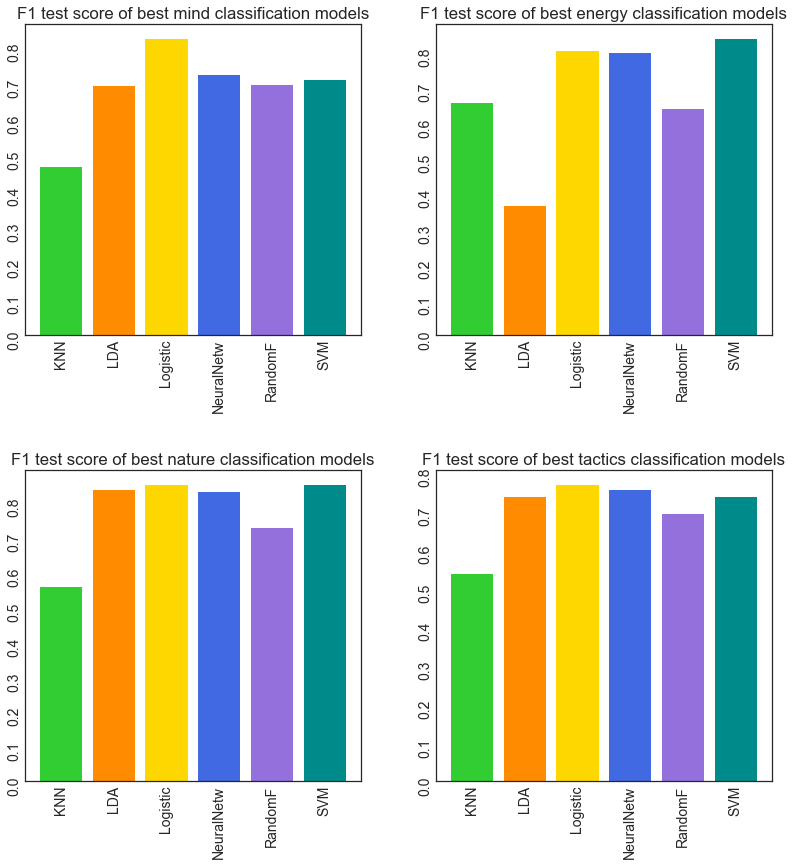

In [482]:
f, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)
plt.tight_layout(pad=3, h_pad=8)
cols = ['gold', 'limegreen', 'darkorange',
        'darkcyan', 'royalblue', 'mediumpurple']
ax[0, 0].bar(accu_mind['clf'], accu_mind['score'], color=cols)
ax[0, 0].set_title('F1 test score of best mind classification models')
ax[0, 0].tick_params(rotation=90)

ax[0, 1].bar(accu_energy['clf'], accu_energy['score'], color=cols)
ax[0, 1].set_title('F1 test score of best energy classification models')
ax[0, 1].tick_params(rotation=90)

ax[1, 0].bar(accu_nature['clf'], accu_nature['score'], color=cols)
ax[1, 0].set_title('F1 test score of best nature classification models')
ax[1, 0].tick_params(rotation=90)

ax[1, 1].bar(accu_tactics['clf'], accu_tactics['score'], color=cols)
ax[1, 1].set_title('F1 test score of best tactics classification models')
ax[1, 1].tick_params(rotation=90);


From this it is clear that Nearal Networks, Logistic regression and Support Vector Machines consistently performs better than the other classifiers. Especially on the datasets which has les samples due to class balancing.

---

## Lastly, lets reduce the dimensions

For all the models performed so far, we included a dimentionality reduction method to reduce the computational load and collinearity. This also greatly improved the performance of the model, and here we optimize which number of components are ideal for reducing the dimentionality of the data.

In [19]:
vectorizer = TfidfVectorizer(preprocessor=preprocess,
                             stop_words=stopwords_no_pro)

pipeline_svd = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD()),
    ('classify', LogisticRegression(penalty='l1', C=1000))
])

num_components = [50, 100, 500, 1000, 5000]

param_grid = {
    'svd__n_components': num_components
}
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_svd, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [21]:
scores_svd = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=5000 ..........................................
[CV] svd__n_compo

[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   56.1s remaining:  2.6min


[CV]  svd__n_components=100, accuracy=0.7719298245614035, precision=0.7894736842105263, recall=0.7228915662650602, roc_auc=0.8287239868565169, f1=0.7547169811320756, total=  35.0s
[CV]  svd__n_components=100, accuracy=0.6686390532544378, precision=0.696969696969697, recall=0.5609756097560976, roc_auc=0.7844126717129241, f1=0.6216216216216217, total=  34.4s
[CV]  svd__n_components=500, accuracy=0.7455621301775148, precision=0.76, recall=0.6951219512195121, roc_auc=0.8153910849453322, f1=0.7261146496815286, total=  40.7s
[CV]  svd__n_components=1000, accuracy=0.7455621301775148, precision=0.76, recall=0.6951219512195121, roc_auc=0.8155312587608634, f1=0.7261146496815286, total=  39.2s
[CV]  svd__n_components=500, accuracy=0.7543859649122807, precision=0.759493670886076, recall=0.7228915662650602, roc_auc=0.8116100766703176, f1=0.7407407407407407, total=  41.0s


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   59.9s remaining:   52.4s


[CV]  svd__n_components=500, accuracy=0.7485380116959064, precision=0.75, recall=0.7228915662650602, roc_auc=0.8191401971522453, f1=0.7361963190184048, total=  42.1s
[CV]  svd__n_components=1000, accuracy=0.7485380116959064, precision=0.75, recall=0.7228915662650602, roc_auc=0.8191401971522454, f1=0.7361963190184048, total=  43.5s
[CV]  svd__n_components=1000, accuracy=0.7485380116959064, precision=0.7564102564102564, recall=0.7108433734939759, roc_auc=0.8111993428258489, f1=0.732919254658385, total=  44.2s


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.0min remaining:   15.3s


[CV]  svd__n_components=5000, accuracy=0.7455621301775148, precision=0.76, recall=0.6951219512195121, roc_auc=0.8153910849453322, f1=0.7261146496815286, total=  58.5s
[CV]  svd__n_components=5000, accuracy=0.7485380116959064, precision=0.75, recall=0.7228915662650602, roc_auc=0.8114731653888281, f1=0.7361963190184048, total= 1.0min
[CV]  svd__n_components=5000, accuracy=0.7485380116959064, precision=0.75, recall=0.7228915662650602, roc_auc=0.8190032858707558, f1=0.7361963190184048, total= 1.1min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=5000 ..........................................
[CV] svd__n_compo

[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   36.3s remaining:  1.7min


[CV]  svd__n_components=100, accuracy=0.71, precision=0.6666666666666666, recall=0.84, roc_auc=0.7536, f1=0.743362831858407, total=  22.0s
[CV]  svd__n_components=500, accuracy=0.69, precision=0.6610169491525424, recall=0.78, roc_auc=0.7827999999999999, f1=0.7155963302752293, total=  24.8s


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   37.0s remaining:   32.4s


[CV]  svd__n_components=1000, accuracy=0.81, precision=0.7818181818181819, recall=0.86, roc_auc=0.9028, f1=0.819047619047619, total=  26.1s
[CV]  svd__n_components=1000, accuracy=0.75, precision=0.7551020408163265, recall=0.74, roc_auc=0.8099999999999999, f1=0.7474747474747474, total=  26.5s
[CV]  svd__n_components=1000, accuracy=0.69, precision=0.6610169491525424, recall=0.78, roc_auc=0.7832, f1=0.7155963302752293, total=  26.9s
[CV]  svd__n_components=500, accuracy=0.81, precision=0.7818181818181819, recall=0.86, roc_auc=0.904, f1=0.819047619047619, total=  25.0s


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   39.9s remaining:   10.0s


[CV]  svd__n_components=5000, accuracy=0.69, precision=0.6610169491525424, recall=0.78, roc_auc=0.78, f1=0.7155963302752293, total=  37.5s
[CV]  svd__n_components=5000, accuracy=0.81, precision=0.7818181818181819, recall=0.86, roc_auc=0.9036000000000001, f1=0.819047619047619, total=  42.2s
[CV]  svd__n_components=5000, accuracy=0.75, precision=0.7551020408163265, recall=0.74, roc_auc=0.8103999999999999, f1=0.7474747474747474, total=  43.1s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   47.7s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=5000 ..........................................
[CV] svd__n_compo

[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.8min remaining:  5.0min


[CV]  svd__n_components=100, accuracy=0.8333333333333334, precision=0.8055555555555556, recall=0.8787878787878788, roc_auc=0.9033608815426997, f1=0.8405797101449276, total= 1.1min
[CV]  svd__n_components=100, accuracy=0.8042168674698795, precision=0.7988165680473372, recall=0.8132530120481928, roc_auc=0.8770866598925824, f1=0.8059701492537313, total= 1.1min
[CV]  svd__n_components=500, accuracy=0.786144578313253, precision=0.7844311377245509, recall=0.7891566265060241, roc_auc=0.8742923501233851, f1=0.7867867867867868, total= 1.5min
[CV]  svd__n_components=500, accuracy=0.8012048192771084, precision=0.8125, recall=0.7831325301204819, roc_auc=0.8695746842792857, f1=0.7975460122699387, total= 1.4min


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.0min remaining:  1.8min


[CV]  svd__n_components=500, accuracy=0.8212121212121212, precision=0.7944444444444444, recall=0.8666666666666667, roc_auc=0.8931864095500459, f1=0.8289855072463769, total= 1.5min
[CV]  svd__n_components=1000, accuracy=0.7951807228915663, precision=0.80625, recall=0.7771084337349398, roc_auc=0.869356945855712, f1=0.7914110429447854, total= 1.5min
[CV]  svd__n_components=1000, accuracy=0.8012048192771084, precision=0.8012048192771084, recall=0.8012048192771084, roc_auc=0.8798083901872551, f1=0.8012048192771084, total= 1.6min
[CV]  svd__n_components=1000, accuracy=0.8454545454545455, precision=0.8352941176470589, recall=0.8606060606060606, roc_auc=0.909605142332415, f1=0.8477611940298508, total= 1.6min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.1min remaining:   31.0s


[CV]  svd__n_components=5000, accuracy=0.7951807228915663, precision=0.7951807228915663, recall=0.7951807228915663, roc_auc=0.8793366236028453, f1=0.7951807228915663, total= 2.0min
[CV]  svd__n_components=5000, accuracy=0.8424242424242424, precision=0.8304093567251462, recall=0.8606060606060606, roc_auc=0.9096786042240586, f1=0.8452380952380952, total= 2.0min
[CV]  svd__n_components=5000, accuracy=0.7951807228915663, precision=0.80625, recall=0.7771084337349398, roc_auc=0.8697924227028596, f1=0.7914110429447854, total= 2.0min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.3min finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=50 ............................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=100 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=500 ...........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=1000 ..........................................
[CV] svd__n_components=5000 ..........................................
[CV] svd__n_compo

[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.5min remaining:  4.2min


[CV]  svd__n_components=100, accuracy=0.7092198581560284, precision=0.696551724137931, recall=0.7266187050359713, roc_auc=0.8059566332947627, f1=0.7112676056338029, total=  56.7s
[CV]  svd__n_components=100, accuracy=0.7007042253521126, precision=0.7099236641221374, recall=0.6642857142857143, roc_auc=0.7742559523809524, f1=0.6863468634686346, total=  58.3s
[CV]  svd__n_components=500, accuracy=0.7198581560283688, precision=0.7112676056338029, recall=0.7266187050359713, roc_auc=0.8107360265633647, f1=0.7188612099644128, total= 1.2min
[CV]  svd__n_components=1000, accuracy=0.7112676056338029, precision=0.6959459459459459, recall=0.7357142857142858, roc_auc=0.7892857142857144, f1=0.7152777777777777, total= 1.3min


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.7min remaining:  1.5min


[CV]  svd__n_components=1000, accuracy=0.7323943661971831, precision=0.7318840579710145, recall=0.7214285714285714, roc_auc=0.7911706349206349, f1=0.7266187050359713, total= 1.2min
[CV]  svd__n_components=500, accuracy=0.7394366197183099, precision=0.726027397260274, recall=0.7571428571428571, roc_auc=0.7901289682539683, f1=0.7412587412587412, total= 1.3min
[CV]  svd__n_components=500, accuracy=0.7112676056338029, precision=0.7132352941176471, recall=0.6928571428571428, roc_auc=0.7798611111111111, f1=0.7028985507246378, total= 1.3min
[CV]  svd__n_components=1000, accuracy=0.7163120567375887, precision=0.7092198581560284, recall=0.7194244604316546, roc_auc=0.8059566332947629, f1=0.7142857142857142, total= 1.3min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.7min remaining:   25.9s


[CV]  svd__n_components=5000, accuracy=0.7112676056338029, precision=0.6959459459459459, recall=0.7357142857142858, roc_auc=0.789781746031746, f1=0.7152777777777777, total= 1.6min
[CV]  svd__n_components=5000, accuracy=0.7163120567375887, precision=0.7092198581560284, recall=0.7194244604316546, roc_auc=0.8056547768777985, f1=0.7142857142857142, total= 1.7min
[CV]  svd__n_components=5000, accuracy=0.7323943661971831, precision=0.7318840579710145, recall=0.7214285714285714, roc_auc=0.7911706349206349, f1=0.7266187050359713, total= 1.7min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.9min finished


In [22]:
save_obj(scores_svd, 'scores_svd')

In [254]:
scores_svd = load_obj('scores_svd')

print('Mind test F1 score:', scores_svd['mind_f1_test'])
print('Energy test F1 score:', scores_svd['energy_f1_test'])
print('Nature test F1 score:', scores_svd['nature_f1_test'])
print('Tactics test F1 score:', scores_svd['tactics_f1_test'])


Mind test F1 score: 0.7131170608739587
Energy test F1 score: 0.7499749974997499
Nature test F1 score: 0.8523761558634834
Tactics test F1 score: 0.7320358768837286


In [258]:
accu = scores_svd['mind_grid_results']['mean_test_accuracy']
neigh = list(scores_svd['mind_grid_results']['param_svd__n_components'])

accu_b = pd.DataFrame([accu, neigh], index=['score', 'neigh']).T


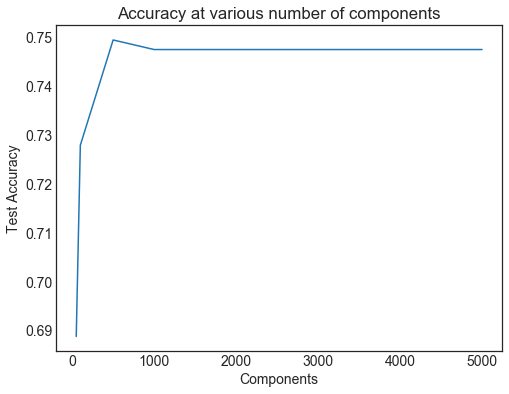

In [260]:
f, ax = plt.subplots(figsize=(8, 6))

plt.plot(accu_b['neigh'], accu_b['score'])
ax.set_title('Accuracy at various number of components')
ax.set_xlabel('Components')
ax.set_ylabel('Test Accuracy');


---

## Emsemble Methods

Lastly, we perform emsemble approached to see if they can improve the performace of our model, and optimize some hyperparameters for these models.

In [32]:
vectorizer = TfidfVectorizer(preprocessor=preprocess,
                             stop_words=stopwords_no_pro)
classifier = LogisticRegression(penalty='l1', C=1000)

pipeline_svd = Pipeline([
    ('features', vectorizer),
    ('densify', DenseTransformer()),
    ('svd', TruncatedSVD()),
    ('classify', AdaBoostClassifier())
])

booster = [GradientBoostingClassifier(),
           AdaBoostClassifier(classifier),
           BaggingClassifier(classifier)]
n_estimators = [50, 100, 500, 1000]
learning_rate = [0.1, 0.01, 0.001]
param_grid = {
    'classify': booster,
    'classify__n_estimators': n_estimators,
    'classify__learning_rate': learning_rate
}
scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']
grid = GridSearchCV(pipeline_svd, param_grid, refit='accuracy', verbose=4,
                    n_jobs=-1, scoring=scoring, return_train_score=True)


In [33]:
scores_ensm = grid_search_p_model(grid, train_tests)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=50 

[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              pres

[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:   26.6s remaining:  1.3min


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.01, classify__n_estimators=100, accuracy=0.5321637426900585, precision=0.5882352941176471, recall=0.12048192771084337, roc_auc=0.5165662650602411, f1=0.19999999999999996, total=  12.9s

[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sa

[Parallel(n_jobs=-1)]: Done  19 out of  36 | elapsed:   28.0s remaining:   25.1s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=1000, accuracy=0.5906432748538012, precision=0.5730337078651685, recall=0.6144578313253012, roc_auc=0.615553121577218, f1=0.5930232558139534, total=  14.5s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl

[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:   47.0s remaining:   11.4s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.001, classify__n_estimators=1000, accuracy=0.514792899408284, precision=0.5, recall=0.18292682926829268, roc_auc=0.4499579478553406, f1=0.26785714285714285, total=  11.4s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   48.3s finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=50 
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              p

[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:   21.3s remaining:  1.1min


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.01, classify__n_estimators=100, accuracy=0.53, precision=0.5263157894736842, recall=0.6, roc_auc=0.5458000000000001, f1=0.5607476635514018, total=  10.3s
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
             

[Parallel(n_jobs=-1)]: Done  19 out of  36 | elapsed:   22.8s remaining:   20.4s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=100, accuracy=0.59, precision=0.5789473684210527, recall=0.66, roc_auc=0.5882000000000001, f1=0.616822429906542, total=  11.2s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
             

[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:   35.8s remaining:    8.7s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.001, classify__n_estimators=50, accuracy=0.52, precision=0.5104166666666666, recall=0.98, roc_auc=0.4806, f1=0.6712328767123288, total=   8.8s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weigh

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   37.3s finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=50 
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              preso

[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:   45.5s remaining:  2.3min


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=50, accuracy=0.5787878787878787, precision=0.5625, recall=0.7090909090909091, roc_auc=0.5962901744719926, f1=0.6273458445040215, total=  22.1s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
 

[Parallel(n_jobs=-1)]: Done  19 out of  36 | elapsed:   46.8s remaining:   41.9s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=500, accuracy=0.4939759036144578, precision=0.494949494949495, recall=0.5903614457831325, roc_auc=0.5113949775003629, f1=0.5384615384615384, total=  24.2s[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples

[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  1.3min remaining:   18.9s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.001, classify__n_estimators=1000, accuracy=0.5692771084337349, precision=0.5515695067264574, recall=0.7409638554216867, roc_auc=0.6252721730294672, f1=0.6323907455012855, total=  16.3s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sa

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.1, classify__n_estimators=50 
[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              pre

[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:   40.4s remaining:  2.0min


[CV] classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.001, classify__n_estimators=1000 
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0

[Parallel(n_jobs=-1)]: Done  19 out of  36 | elapsed:   41.9s remaining:   37.5s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.01, classify__n_estimators=1000, accuracy=0.5140845070422535, precision=0.5083333333333333, recall=0.4357142857142857, roc_auc=0.5248263888888889, f1=0.46923076923076923, total=  21.8s
[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_

[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  1.2min remaining:   16.8s


[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), classify__learning_rate=0.001, classify__n_estimators=100, accuracy=0.5035460992907801, precision=0.45454545454545453, recall=0.03597122302158273, roc_auc=0.5388891683855712, f1=0.06666666666666667, total=  15.3s[CV]  classify=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.2min finished


In [34]:
save_obj(scores_ensm, 'scores_ensm_gradboost')


In [261]:
scores_ensm = load_obj('scores_ensm_gradboost')

print('Mind test F1 score:', scores_ensm['mind_f1_test'])
print('Energy test F1 score:', scores_ensm['energy_f1_test'])
print('Nature test F1 score:', scores_ensm['nature_f1_test'])
print('Tactics test F1 score:', scores_ensm['tactics_f1_test'])


Mind test F1 score: 0.41120077958018225
Energy test F1 score: 0.5095586027424681
Nature test F1 score: 0.5598762704374723
Tactics test F1 score: 0.5286937973997833


From this it looks like the ensemble approaches does not provide a significant amount of improvement on the other classifiers without extensive optimization of the hyper parameters.

---

## Performance of a multi-label classifier

One of the best performing classifiers were the Neural network classifier. In a last attempt to get the best performing classifier, we will train a multi-label neural network classifier. This neural network will predict all four axes in one classifier, reducing the need to subsample, and balance the dataset, as well as allowing a single classifier to classify the dataset, reducing computational time. 

This dataframe contains the individual labels seperated per personality axis, which will be used in the multilabel classification

In [90]:
train_labeled.head()

,type,posts,I,N,F,J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,1


In [34]:
X_nn = train_labeled['posts']
y_nn = train_labeled[['I', 'N', 'F', 'J']]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn)

In [46]:
pipeline = Pipeline([ 
    ('vectorize', TfidfVectorizer(stop_words=stopwords_no_pro)), 
    ('svd', TruncatedSVD(n_components=500)),
    ('scaler', StandardScaler()),
    ('classify', MLPClassifier(max_iter=2000))
])
pipeline.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(memory=None,
     steps=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [47]:
pipeline.score(X_test, y_test)


0.5175169022741242

In [50]:
pipeline.predict_log_proba(X_test)[0]

array([-3.02021808, -2.62126585, -4.2584477 , -3.85282967, -5.28325823,
       -5.47253921, -5.32217276, -4.71425644, -0.97257571, -1.25423388,
       -3.70492692, -3.46089109, -3.49694323, -3.49492424, -4.36605783,
       -3.60227503])

This is the score for the overall model, i.e., per personality (e.g., INFJ).

This score may look quite low, but for comparison the classifying the full personalities using a Logistic Regression classifier only provides an accuracy of 0.27.

---

This shows the performance of the model on each of the personality axes, i.e., (I vs. E), etc.

In [147]:
predict = pipeline.predict(X_test)
print('The classification scores: ','\n',
      metrics.classification_report(y_test, predict))


The classification scores:  
              precision    recall  f1-score   support

          0       0.89      0.93      0.91      1240
          1       0.92      0.95      0.93      1397
          2       0.84      0.86      0.85       884
          3       0.72      0.73      0.72       630

avg / total       0.87      0.89      0.88      4151



In [330]:
print('This is the mind accuracy score of my model',
      metrics.accuracy_score(y_test['I'], pd.DataFrame(predict)[0]))
print('This is the energy accuracy score of my model',
      metrics.accuracy_score(y_test['N'], pd.DataFrame(predict)[1]))
print('This is the nature accuracy score of my model',
      metrics.accuracy_score(y_test['F'], pd.DataFrame(predict)[2]))
print('This is the tactics accuracy score of my model',
      metrics.accuracy_score(y_test['J'], pd.DataFrame(predict)[3]))


This is the mind accuracy score of my model 0.860479409956976
This is the energy accuracy score of my model 0.9084204056545789
This is the nature accuracy score of my model 0.8690842040565457
This is the tactics accuracy score of my model 0.8242163491087892


In [151]:
param_grid = {
              'classify__hidden_layer_sizes': [(5000,), (1000,),
                                               (500,), (250, )],
              'classify__alpha': [1e-1, 1e-3, 1e-5, 1e-7],
              'classify__activation': ['logistic', 'relu'],
              'svd__n_components': [250, 500, 1000]}

grid = GridSearchCV(pipeline, param_grid, refit=True, verbose=4, n_jobs=-1)


In [152]:
grid.fit(X_train,y_train)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=250 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=250 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=250 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=500 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=500 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=500 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_components=1000 
[CV] classify__activation=logistic, classify__alpha=0.1, classify__hidden_layer_sizes=(5000,), svd__n_component

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 47.1min


[CV] classify__activation=logistic, classify__alpha=1e-05, classify__hidden_layer_sizes=(5000,), svd__n_components=250 
[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(500,), svd__n_components=500, score=0.5479704797047971, total=16.8min
[CV] classify__activation=logistic, classify__alpha=1e-05, classify__hidden_layer_sizes=(5000,), svd__n_components=250 
[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(250,), svd__n_components=250, score=0.5805658056580566, total=13.5min
[CV] classify__activation=logistic, classify__alpha=1e-05, classify__hidden_layer_sizes=(5000,), svd__n_components=500 
[CV]  classify__activation=logistic, classify__alpha=0.001, classify__hidden_layer_sizes=(1000,), svd__n_components=250, score=0.560270602706027, total=25.9min
[CV] classify__activation=logistic, classify__alpha=1e-05, classify__hidden_layer_sizes=(5000,), svd__n_components=500 
[CV]  classify__activation=logistic, cla

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 172.3min


[CV] classify__activation=relu, classify__alpha=0.001, classify__hidden_layer_sizes=(1000,), svd__n_components=1000 
[CV]  classify__activation=relu, classify__alpha=0.1, classify__hidden_layer_sizes=(250,), svd__n_components=1000, score=0.5586969883220652, total=14.8min
[CV] classify__activation=relu, classify__alpha=0.001, classify__hidden_layer_sizes=(1000,), svd__n_components=1000 
[CV]  classify__activation=relu, classify__alpha=0.1, classify__hidden_layer_sizes=(250,), svd__n_components=1000, score=0.5455104551045511, total=15.2min
[CV] classify__activation=relu, classify__alpha=0.001, classify__hidden_layer_sizes=(500,), svd__n_components=250 
[CV]  classify__activation=relu, classify__alpha=0.1, classify__hidden_layer_sizes=(250,), svd__n_components=1000, score=0.5639606396063961, total=15.1min
[CV] classify__activation=relu, classify__alpha=0.001, classify__hidden_layer_sizes=(500,), svd__n_components=250 
[CV]  classify__activation=relu, classify__alpha=0.1, classify__hidden_

[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 234.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'classify__hidden_layer_sizes': [(5000,), (1000,), (500,), (250,)], 'classify__alpha': [0.1, 0.001, 1e-05, 1e-07], 'classify__activation': ['logistic', 'relu'], 'svd__n_components': [250, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=4)

In [154]:
grid.best_params_


{'classify__activation': 'logistic',
 'classify__alpha': 1e-05,
 'classify__hidden_layer_sizes': (1000,),
 'svd__n_components': 250}

In [155]:
grid.best_score_


0.598688255790121

In [156]:
grid.score(X_test, y_test)


0.5906576521204672

While the overall performance of this model (i.e., in predicting the full personalities) is quite low, predicting the individual axes of each personality is quite accurate. And this is thus the model that we will use in predicting the personalities.

# Final model construction 

In [282]:
pipeline = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words=stopwords_no_pro)),
    ('svd', TruncatedSVD(n_components=250)),
    ('scaler', StandardScaler()),
    ('classify', MLPClassifier(max_iter=2000, activation='logistic',
                               alpha=1e-05, hidden_layer_sizes=(1000,)))
])
pipeline.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vectorize', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [283]:
pipeline.score(X_test, y_test)


0.6029502151198525

In [319]:
predict = pd.DataFrame(pipeline.predict(X_test))


In [329]:
scr = pd.DataFrame([[metrics.accuracy_score(y_test['I'], predict[0]),
                     metrics.accuracy_score(y_test['N'], predict[1]),
                     metrics.accuracy_score(y_test['F'], predict[2]),
                     metrics.accuracy_score(y_test['J'], predict[3])],
                    [metrics.matthews_corrcoef(y_test['I'], predict[0]),
                     metrics.matthews_corrcoef(y_test['N'], predict[1]),
                     metrics.matthews_corrcoef(y_test['F'], predict[2]),
                     metrics.matthews_corrcoef(y_test['J'], predict[3])],
                    [metrics.f1_score(y_test['I'], predict[0]),
                     metrics.f1_score(y_test['N'], predict[1]),
                     metrics.f1_score(y_test['F'], predict[2]),
                     metrics.f1_score(y_test['J'], predict[3])],
                    [metrics.recall_score(y_test['I'], predict[0]),
                     metrics.recall_score(y_test['N'], predict[1]),
                     metrics.recall_score(y_test['F'], predict[2]),
                     metrics.recall_score(y_test['J'], predict[3])],
                    [metrics.precision_score(y_test['I'], predict[0]),
                     metrics.precision_score(y_test['N'], predict[1]),
                     metrics.precision_score(y_test['F'], predict[2]),
                     metrics.precision_score(y_test['J'], predict[3])]],
                   index=['Accuracy', 'Matthews', 'F1',
                          'Recall', 'Precision'],
                   columns=['Mind', 'Energy', 'Nature', 'Tactics']).T

scr

,Accuracy,Matthews,F1,Recall,Precision
Mind,0.860479,0.588258,0.911015,0.914961,0.907104
Energy,0.908420,0.616502,0.946918,0.958874,0.935257
Nature,0.869084,0.737192,0.876665,0.874134,0.879210
Tactics,0.824216,0.630234,0.773734,0.762871,0.784912


But how does this compare to the multiple single label classifiers constructed above, and which classifier will we choose as the winner?

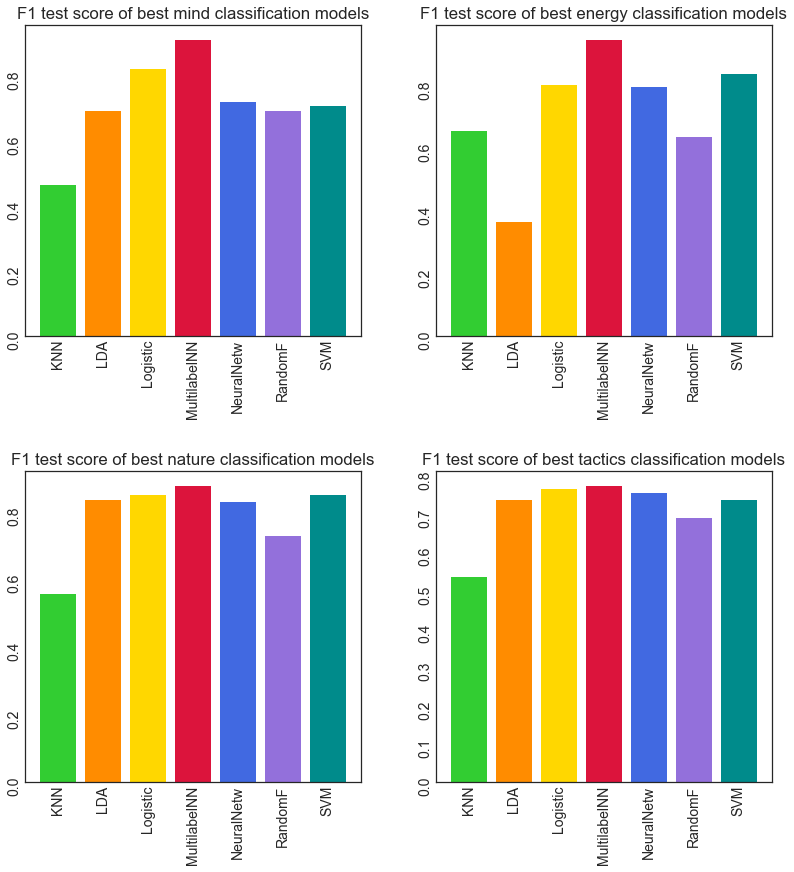

In [484]:
accu_m = [scr_log['mind_f1_test'], scores_knn['mind_f1_test'],
          scores_lda['mind_f1_test'], scores_svm['mind_f1_test'],
          scores_nn['mind_f1_test'], scores_rnf['mind_f1_test'],
          metrics.f1_score(y_test['I'], predict[0])]

accu_e = [scr_log['energy_f1_test'], scores_knn['energy_f1_test'],
          scores_lda['energy_f1_test'], scores_svm['energy_f1_test'],
          scores_nn['energy_f1_test'], scores_rnf['energy_f1_test'],
          metrics.f1_score(y_test['N'], predict[1])]

accu_n = [scr_log['nature_f1_test'], scores_knn['nature_f1_test'],
          scores_lda['nature_f1_test'], scores_svm['nature_f1_test'],
          scores_nn['nature_f1_test'], scores_rnf['nature_f1_test'],
          metrics.f1_score(y_test['F'], predict[2])]

accu_t = [scr_log['tactics_f1_test'], scores_knn['tactics_f1_test'],
          scores_lda['tactics_f1_test'], scores_svm['tactics_f1_test'],
          scores_nn['tactics_f1_test'], scores_rnf['tactics_f1_test'],
          metrics.f1_score(y_test['J'], predict[3])]

names = ['Logistic', 'KNN', 'LDA', 'SVM',
         'NeuralNetw', 'RandomF', 'MultilabelNN']

accu_mind = pd.DataFrame([accu_m, names], index=['score', 'clf']).T
accu_energy = pd.DataFrame([accu_e, names], index=['score', 'clf']).T
accu_nature = pd.DataFrame([accu_n, names], index=['score', 'clf']).T
accu_tactics = pd.DataFrame([accu_t, names], index=['score', 'clf']).T


f, ax = plt.subplots(figsize=(12, 12), nrows=2, ncols=2)
plt.tight_layout(pad=3, h_pad=8)
cols = ['gold', 'limegreen', 'darkorange',
        'darkcyan', 'royalblue', 'mediumpurple', 'crimson']
ax[0, 0].bar(accu_mind['clf'], accu_mind['score'], color=cols)
ax[0, 0].set_title('F1 test score of best mind classification models')
ax[0, 0].tick_params(rotation=90)

ax[0, 1].bar(accu_energy['clf'], accu_energy['score'], color=cols)
ax[0, 1].set_title('F1 test score of best energy classification models')
ax[0, 1].tick_params(rotation=90)

ax[1, 0].bar(accu_nature['clf'], accu_nature['score'], color=cols)
ax[1, 0].set_title('F1 test score of best nature classification models')
ax[1, 0].tick_params(rotation=90)

ax[1, 1].bar(accu_tactics['clf'], accu_tactics['score'], color=cols)
ax[1, 1].set_title('F1 test score of best tactics classification models')
ax[1, 1].tick_params(rotation=90);


These values were quite high, and we will be using this specific model to predict the test data.

# Import test data

In [292]:
test = pd.read_csv('../test.csv')


# Predict test data labels from winning model

In [294]:
predictions = pipeline.predict(test['posts'])


In [300]:
predict_df = pd.DataFrame(predictions)

mind = predict_df[0].map({1: 'I', 0: 'E'})
energy = predict_df[1].map({1: 'N', 0: 'S'})
nature = predict_df[2].map({1: 'F', 0: 'T'})
tactics = predict_df[3].map({1: 'J', 0: 'P'})

final_df = pd.DataFrame([mind, energy, nature, tactics],
                        index=['mind', 'energy', 'nature', 'tactics']).T

final_df.head(20)


,mind,energy,nature,tactics
0,I,N,F,P
1,I,N,F,P
2,I,N,F,J
3,I,N,F,P
4,I,N,F,J
5,E,N,F,P
6,I,N,T,J
7,I,N,F,P
8,I,N,F,J
9,I,N,T,P


In [299]:
final_df.to_csv('Andries_final_prediction.csv')


# List of above and beyond-ness

### Additional pre-processing and NLP

* Own preprocessing and tokenization function which can be added and omitted from NLP pipeline
* Gather of additional text features such as number of words per post, readability etc.
* Removal of URLs from the text and replacement with domains, allowing classifiers to recognize the websites most visited by which personalities.
* During exploratory analyses it was clear that the dataset is highly unbalanced, a subsampler function was implemented to account and subsample for there differences.

### More classification algorithms

* In addition to the prescribed algorithms I constructed the following:
* Numerous other classifiers were tested as base arguments (e.g., GaussianNB and DecisionTrees)
* Emsemble classifiers such as RandomForests, Adaboost and GradientBoost. 
* Neural netorks and RandomForests for which the hyper parameters were tuned.
* A neural network which functioned in a multi-label fashion to predict all four labels.

### Model Validation

* To validate models, gridsearch was performed to fine tune the hyper parameters. 
* Additinoally, the training data was split into train, validation and test sets. The train and validation sets were used in constructing the models and tuning the hyperparameters - through cross validations. The test sets were only used at the end to ensure no data leaked into the model, and the test scores are a true reflection unseen data.

### Other creative problem-solving

* The code above is fully modular. Each section function independently, and can be added or removed from any pipeline. 
* The used of pipelines in this fashion ensures that any data can now be used as input, and as long as all the custom functions and classes are defined, raw data can be classified within only a few lines of code.
* The use of a multi-label classifier allowed data to be classified in one single classifier with the same parameters. This is not only intuatively more simple, but also greatly reduces the computational time. 

#### Acknowledgements

Code on building a custom transformer were inspired by https://opendevincode.wordpress.com/2015/08/01/building-a-custom-python-scikit-learn-transformer-for-machine-learning/ and the very helpful post on http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

Other code, functions and classes may loosely be based on code found on Stackoverflow and SKLearn Documentation.